In [606]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Add project directory to sys.path
pdir = os.path.abspath(os.path.join(os.getcwd(), '.'))
sys.path.insert(1, pdir)
from myutils import *

# Other module imports
import ast, math, swifter, csv, json, itertools as it, portion as P

# Set plot style
# plt.style.use('ggplot')

# Functions & Methods

In [315]:
def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = [
            'seq', 'rpkg', 'frame_id', 'Timestamp', 'Timestamp_epoth', 'lost', 'excl', 'latency',
            'xmit_time', 'xmit_time_epoch', 'arr_time', 'arr_time_epoch',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['Timestamp_epoch', 'xmit_time_epoch', 'arr_time_epoch', 'latency']] = \
            df[['Timestamp_epoch', 'xmit_time_epoch', 'arr_time_epoch', 'latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

In [279]:
class Experiment():
    ID = 0
    
    def __init__(self, dirpath, setting):
        self.id = f"{Experiment.ID:02d}"
        self.dirpath = dirpath
        self.date = os.path.basename(os.path.dirname(dirpath))
        self.name = os.path.basename(dirpath)
        self.setting = json.loads(setting)
        self.dev_traces = {}
        self.traces = []
        self.rrc_paths = {}
        self.lte_paths = {}
        self.nr_paths = {}
        self.ul_paths = {}
        self.dl_paths = {}
        self.metadata = None
        self.metadata_dual = None
        self.ranking = {}
        self.ranking_dual = {}
        Experiment.ID += 1
    
    def __repr__(self):
        return f'Experiment {self.id}: ./{self.date}/{self.name} -> {self.setting}'

def build_experiment_list(md_files):
    exp_list = []
    
    for md_file in md_files:
        with open(md_file, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
        
        lines = lines[:lines.index('#endif')]
        
        for expr, sett in zip(lines[::2], lines[1::2]):
            parent_dir = os.path.dirname(md_file)
            experiment = Experiment(os.path.join(parent_dir, expr), sett)
            exp_list.append(experiment)
    
    return exp_list

# Main

In [280]:
### TODO: Check Root Folder
root = '/Users/jackbedford/Desktop/MOXA/Code/data'
# root = '/home/wmnlab/D/database'

paths = [
    os.path.join(root, s)
    for s in os.listdir(root)
    if s.startswith('202') and os.path.isdir(os.path.join(root, s))
]

md_files = sorted([os.path.join(path, s) for path in paths for s in os.listdir(path) if s.endswith('.md')])

# GLOBAL VARIABLE !!!
exp_list = build_experiment_list(md_files)

pprint(exp_list)

[Experiment 00: ./2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 01: ./2023-03-26/Bandlock_Udp_All_RM500Q -> {'qc00': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 02: ./2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q -> {'qc00': 'B1B3', 'qc01': 'B1B8', 'qc02': 'LTE', 'qc03': 'All'},
 Experiment 03: ./2023-04-01/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 04: ./2023-04-10/Experiment1 -> {'qc00': 'All', 'qc01': 'All', 'qc02': 'All', 'qc03': 'All'},
 Experiment 05: ./2023-04-10/Experiment2 -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 06: ./2023-04-10/Experiment3 -> {'qc00': 'LTE', 'qc01': 'All', 'qc02': 'B7B8', 'qc03': 'B7'},
 Experiment 07: ./2023-04-17/Bandlock_Udp_All_LTE_All_LTE_RM500Q -> {'qc00': 'All', 'qc01': 'LTE', 'qc02': 'All', 'qc03': 'LTE'},
 Experiment 08: ./2023-04-17/Bandlock_Udp_All_LTE_B1_B3_RM500Q -> {'qc00': 'All', 'qc01': 'L

In [281]:
### TODO: Select Experiments
selected_indices = [21, 22]

exp_list = [exp_list[i] for i in selected_indices]

# GLOBAL VARIABLE !!!
look_up_table = {expr.id: i for i, expr in enumerate(exp_list)}

print(look_up_table)
print(exp_list)

{'21': 0, '22': 1}
[Experiment 21: ./2023-06-15/Bandlock_All_B3_B7_B8_Dupl_Phone -> {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B3', 'sm04': 'B7', 'sm05': 'B7', 'sm06': 'B8', 'sm07': 'B8'}, Experiment 22: ./2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone -> {'sm00': 'LTE', 'sm01': 'LTE', 'sm02': 'B3', 'sm03': 'B3', 'sm04': 'B7', 'sm05': 'B7', 'sm06': 'B8', 'sm07': 'B8'}]


## Metadata

In [282]:
# GLOBAL VARIABLE !!!
nr_check_tables = []

for expr in exp_list:
    # Feed-In Metadata
    expr.dev_traces = {
        dev: ', '.join(traces)
        for dev in expr.setting.keys()
        for traces in [[s for s in sorted(os.listdir(os.path.join(expr.dirpath, dev))) if s.startswith('#')]]
    }
    expr.traces = list(expr.dev_traces.values())[0].split(', ')
    merged_dict = {key: (expr.setting[key], expr.dev_traces[key]) for key in expr.setting}
    expr.metadata = pd.DataFrame(merged_dict.values(), index=merged_dict.keys(), columns=['Schm', 'Traces']).reset_index().rename(columns={'index':'Device'})

    # Print Out Metadata
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)

    # Feed-In Data Path
    for dev in expr.setting.keys():
        expr.rrc_paths[dev], expr.lte_paths[dev], expr.nr_paths[dev], expr.ul_paths[dev], expr.dl_paths[dev] = [], [], [], [], []

        for trace in expr.traces:
            data_dir = os.path.join(expr.dirpath, dev, trace, 'data')
            expr.rrc_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_rrc.pkl')]
            expr.lte_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_ml1.pkl') and not s.endswith('_nr_ml1.pkl')]
            expr.nr_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_nr_ml1.pkl')]
            expr.ul_paths[dev] += [os.path.join(data_dir, 'udp_uplk_loss_latency.pkl')]
            expr.dl_paths[dev] += [os.path.join(data_dir, 'udp_dnlk_loss_latency.pkl')]

    # Check NR Alive
    nr_checktable_path = os.path.join(expr.dirpath, 'nr_alive_checktable.csv')
    if os.path.isfile(nr_checktable_path):
        table = pd.read_csv(nr_checktable_path)
    else:
        devices = expr.setting.keys()
        traces = expr.traces

        table = pd.DataFrame(columns=['Tr.', *devices])
        for i, trace in enumerate(tqdm(traces, ncols=1000)):
            check_list = [trace] + ['O'] * len(devices)
            for j, dev in enumerate(devices):
                rrc_data = expr.rrc_paths[dev][i]
                rrc_df, _, _ = mi_parse_ho(pd.read_pickle(rrc_data), tz=8)
                if sum(rrc_df['cause'] == 'rlc-MaxNumRetx (2)') > 0:
                    check_list[j+1] = '∆'
                nr_data = expr.nr_paths[dev][i]
                nr_df = pd.read_pickle(nr_data)
                if nr_df.empty:
                    check_list[j+1] = 'X'
            table.loc[len(table)] = check_list

        table.to_csv(nr_checktable_path, index=False)

    nr_check_tables.append(table)

    display(table)
    print('O: RF Module is always on.')
    print('∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!')
    print('X: RF Module has never been turned on. It could be under pure LTE or an anomaly.')
    print()

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces
0   sm00  All  #01, #02, #03, #04
1   sm01  All  #01, #02, #03, #04
2   sm02   B3  #01, #02, #03, #04
3   sm03   B3  #01, #02, #03, #04
4   sm04   B7  #01, #02, #03, #04
5   sm05   B7  #01, #02, #03, #04
6   sm06   B8  #01, #02, #03, #04
7   sm07   B8  #01, #02, #03, #04

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    O    O    O    O    O    O    O    O
1  #02    O    O    O    O    O    O    O    O
2  #03    O    O    O    O    O    O    O    O
3  #04    O    O    O    O    O    O    O    O

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces
0   sm00  LTE  #01, #02, #03, #04, #05, #06
1   sm01  LTE  #01, #02, #03, #04, #05, #06
2   sm02   B3  #01, #02, #03, #04, #05, #06
3   sm03   B3  #01, #02, #03, #04, #05, #06
4   sm04   B7  #01, #02, #03, #04, #05, #06
5   sm05   B7  #01, #02, #03, #04, #05, #06
6   sm06   B8  #01, #02, #03, #04, #05, #06
7   sm07   B8  #01, #02, #03, #04, #05, #06

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    X    X    O    O    O    O    O    O
1  #02    X    X    O    O    O    ∆    ∆    O
2  #03    X    X    O    O    O    O    O    O
3  #04    X    X    O    O    O    O    O    O
4  #05    X    X    O    O    O    O    O    O
5  #06    X    X    O    O    O    O    O    O

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.



In [283]:
def remove_expr_element(remove_list):
    for id, dev, tr in remove_list:
        try:
            index = look_up_table[id]
        except:
            id_not_found = 1
            for i, expr in enumerate(exp_list):
                if f"{id:02d}" == expr.id:
                    id_not_found = 0
                    look_up_table[id] = i
                    index = i
                    break
            if id_not_found:
                print(f'Exp id: {id} not found!')
                continue
            
        if isinstance(tr, str):
            tr_name = tr
            tr_index = exp_list[index].traces.index(tr)
        else:
            tr_name = exp_list[index].traces[tr]
            tr_index = tr
        
        for path_list in [exp_list[index].rrc_paths[dev], exp_list[index].lte_paths[dev], exp_list[index].nr_paths[dev], exp_list[index].ul_paths[dev], exp_list[index].dl_paths[dev]]:
            path_list[tr_index] = ''
        
        exp_list[index].dev_traces[dev] = ', '.join([s for s in exp_list[index].dev_traces[dev].split(', ') if s != tr_name])
    
    for expr in exp_list:
        merged_dict = {key: (expr.setting[key], expr.dev_traces[key]) for key in expr.setting}
        expr.metadata = pd.DataFrame(merged_dict.values(), index=merged_dict.keys(), columns=['Schm', 'Traces']).reset_index().rename(columns={'index':'Device'})

# TODO: Remove Abnormal Data
remove_expr_element([(22, 'sm05', 1), (22, 'sm06', '#02')])

## Selected Data Preview

In [284]:
for expr, nr_table in zip(exp_list, nr_check_tables):
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)

    path_list = [
        # ('rrc_paths', expr.rrc_paths),
        # ('lte_paths', expr.lte_paths),
        # ('nr_paths', expr.nr_paths),
        # ('ul_paths', expr.ul_paths),
        # ('dl_paths', expr.dl_paths),
    ]
    for path_type, paths in path_list:
        print(path_type)
        pprint(paths)

    display(nr_table)
    print('O: RF Module is always on.')
    print('∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!')
    print('X: RF Module has never been turned on. It could be under pure LTE or an anomaly.')
    print()

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces
0   sm00  All  #01, #02, #03, #04
1   sm01  All  #01, #02, #03, #04
2   sm02   B3  #01, #02, #03, #04
3   sm03   B3  #01, #02, #03, #04
4   sm04   B7  #01, #02, #03, #04
5   sm05   B7  #01, #02, #03, #04
6   sm06   B8  #01, #02, #03, #04
7   sm07   B8  #01, #02, #03, #04

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    O    O    O    O    O    O    O    O
1  #02    O    O    O    O    O    O    O    O
2  #03    O    O    O    O    O    O    O    O
3  #04    O    O    O    O    O    O    O    O

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces
0   sm00  LTE  #01, #02, #03, #04, #05, #06
1   sm01  LTE  #01, #02, #03, #04, #05, #06
2   sm02   B3  #01, #02, #03, #04, #05, #06
3   sm03   B3  #01, #02, #03, #04, #05, #06
4   sm04   B7  #01, #02, #03, #04, #05, #06
5   sm05   B7       #01, #03, #04, #05, #06
6   sm06   B8       #01, #03, #04, #05, #06
7   sm07   B8  #01, #02, #03, #04, #05, #06

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    X    X    O    O    O    O    O    O
1  #02    X    X    O    O    O    ∆    ∆    O
2  #03    X    X    O    O    O    O    O    O
3  #04    X    X    O    O    O    O    O    O
4  #05    X    X    O    O    O    O    O    O
5  #06    X    X    O    O    O    O    O    O

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.



# Single Radio

In [285]:
import numpy as np

my_list = [9, 3, 7, 1, 5]

# 獲取按值升冪排序的索引列表
# sorted_indices = [i for i, x in sorted(enumerate(my_list), key=lambda x: x[1])]
sorted_indices = list(np.argsort(my_list))

print("原始列表:", my_list)
print("按值進行升冪排序的索引列表:", sorted_indices)

# 利用索引列表計算ranking
# ranking = np.zeros(len(my_list))
# ranking[sorted_indices] = np.arange(1, len(my_list) + 1)
ranking = list(np.argsort(sorted_indices) + 1)

print("升冪排名:", ranking)

原始列表: [9, 3, 7, 1, 5]
按值進行升冪排序的索引列表: [3, 1, 4, 2, 0]
升冪排名: [5, 2, 4, 1, 3]


In [286]:
def calc_loss_excl_rate(filepath):
    if not os.path.isfile(filepath):
        return -1, -1
    
    df = pd.read_pickle(filepath) if filepath.endswith('.pkl') else pd.read_csv(filepath)
    
    # Calculate PLR & ELR
    loss_rate = df['lost'].mean() * 100
    
    excl_threshold = 100e-3
    excl_rate = (df[~df['lost']]['latency'] > excl_threshold).mean() * 100
    
    return loss_rate, excl_rate

# GLOBAL VARIABLE !!!
single_metrics_list = []

for expr in exp_list:
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    # display(expr.metadata)
    
    metrics_dict = {}
    
    for (dev, ul_paths), dl_paths in tqdm(zip(expr.ul_paths.items(), expr.dl_paths.values()), ncols=1000):
        metrics_dict[dev] = {'ul_loss': [], 'ul_excl': [], 'dl_loss': [], 'dl_excl': []}
        
        for ul_path, dl_path in zip(ul_paths, dl_paths):
            ul_loss_rate, ul_excl_rate = calc_loss_excl_rate(ul_path)
            dl_loss_rate, dl_excl_rate = calc_loss_excl_rate(dl_path)
            
            metrics_dict[dev]['ul_loss'].append(ul_loss_rate)
            metrics_dict[dev]['ul_excl'].append(ul_excl_rate)
            metrics_dict[dev]['dl_loss'].append(dl_loss_rate)
            metrics_dict[dev]['dl_excl'].append(dl_excl_rate)
    
    single_metrics_list.append(metrics_dict)
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR']

    ### Display Table
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])

    ### Ranking
    for tag in tags:
        data = [np.mean([num for num in v[tag] if num >= 0]) for v in metrics_dict.values()]
        ranking = np.argsort(np.argsort(data)) + 1
        
        expr.metadata[f'avg_{tag}'] = data
        expr.metadata[f'{tag}_rank'] = ranking
    
    print('Single Radio Ranking:')
    display(expr.metadata)

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


0it [00:00, ?it/s]

Single Radio Ranking:


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


0it [00:00, ?it/s]

Single Radio Ranking:


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             5   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             3   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             4   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7       #01, #03, #04, #05, #06     1.278359             7   
6   sm06   B8       #01, #03, #04, #05, #06     1.185786             6   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             2   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             6     0.831878   
5     2.532447             8     2.604340             5     0.461063   
6     1.190465             3     1.640298             3     0.531022   
7     1.476035             4     2.474258             4     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             1  
6             3  
7             4

## Box Plot

In [287]:
def add_suffix_to_duplicate_category(strings):
    # 創建一個字典來記錄每個字串符號的出現次數
    string_counts = {}
    
    # 加上后缀
    result_strings = []
    for s in strings:
        string_counts[s] = string_counts.get(s, 0) + 1
        if string_counts[s] > 1:
            result_strings.append(f"{s}_{string_counts[s] - 1}")
        else:
            result_strings.append(s)
    
    for s, count in string_counts.items():
        if count > 1:
            index = result_strings.index(s)
            result_strings[index] = f'{s}_0'

    return result_strings

my_list = ['A', 'B', 'A', 'C', 'B', 'D', 'A', 'E', 'E']
print(add_suffix_to_duplicate_category(my_list))

['A_0', 'B_0', 'A_1', 'C', 'B_1', 'D', 'A_2', 'E_0', 'E_1']


Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

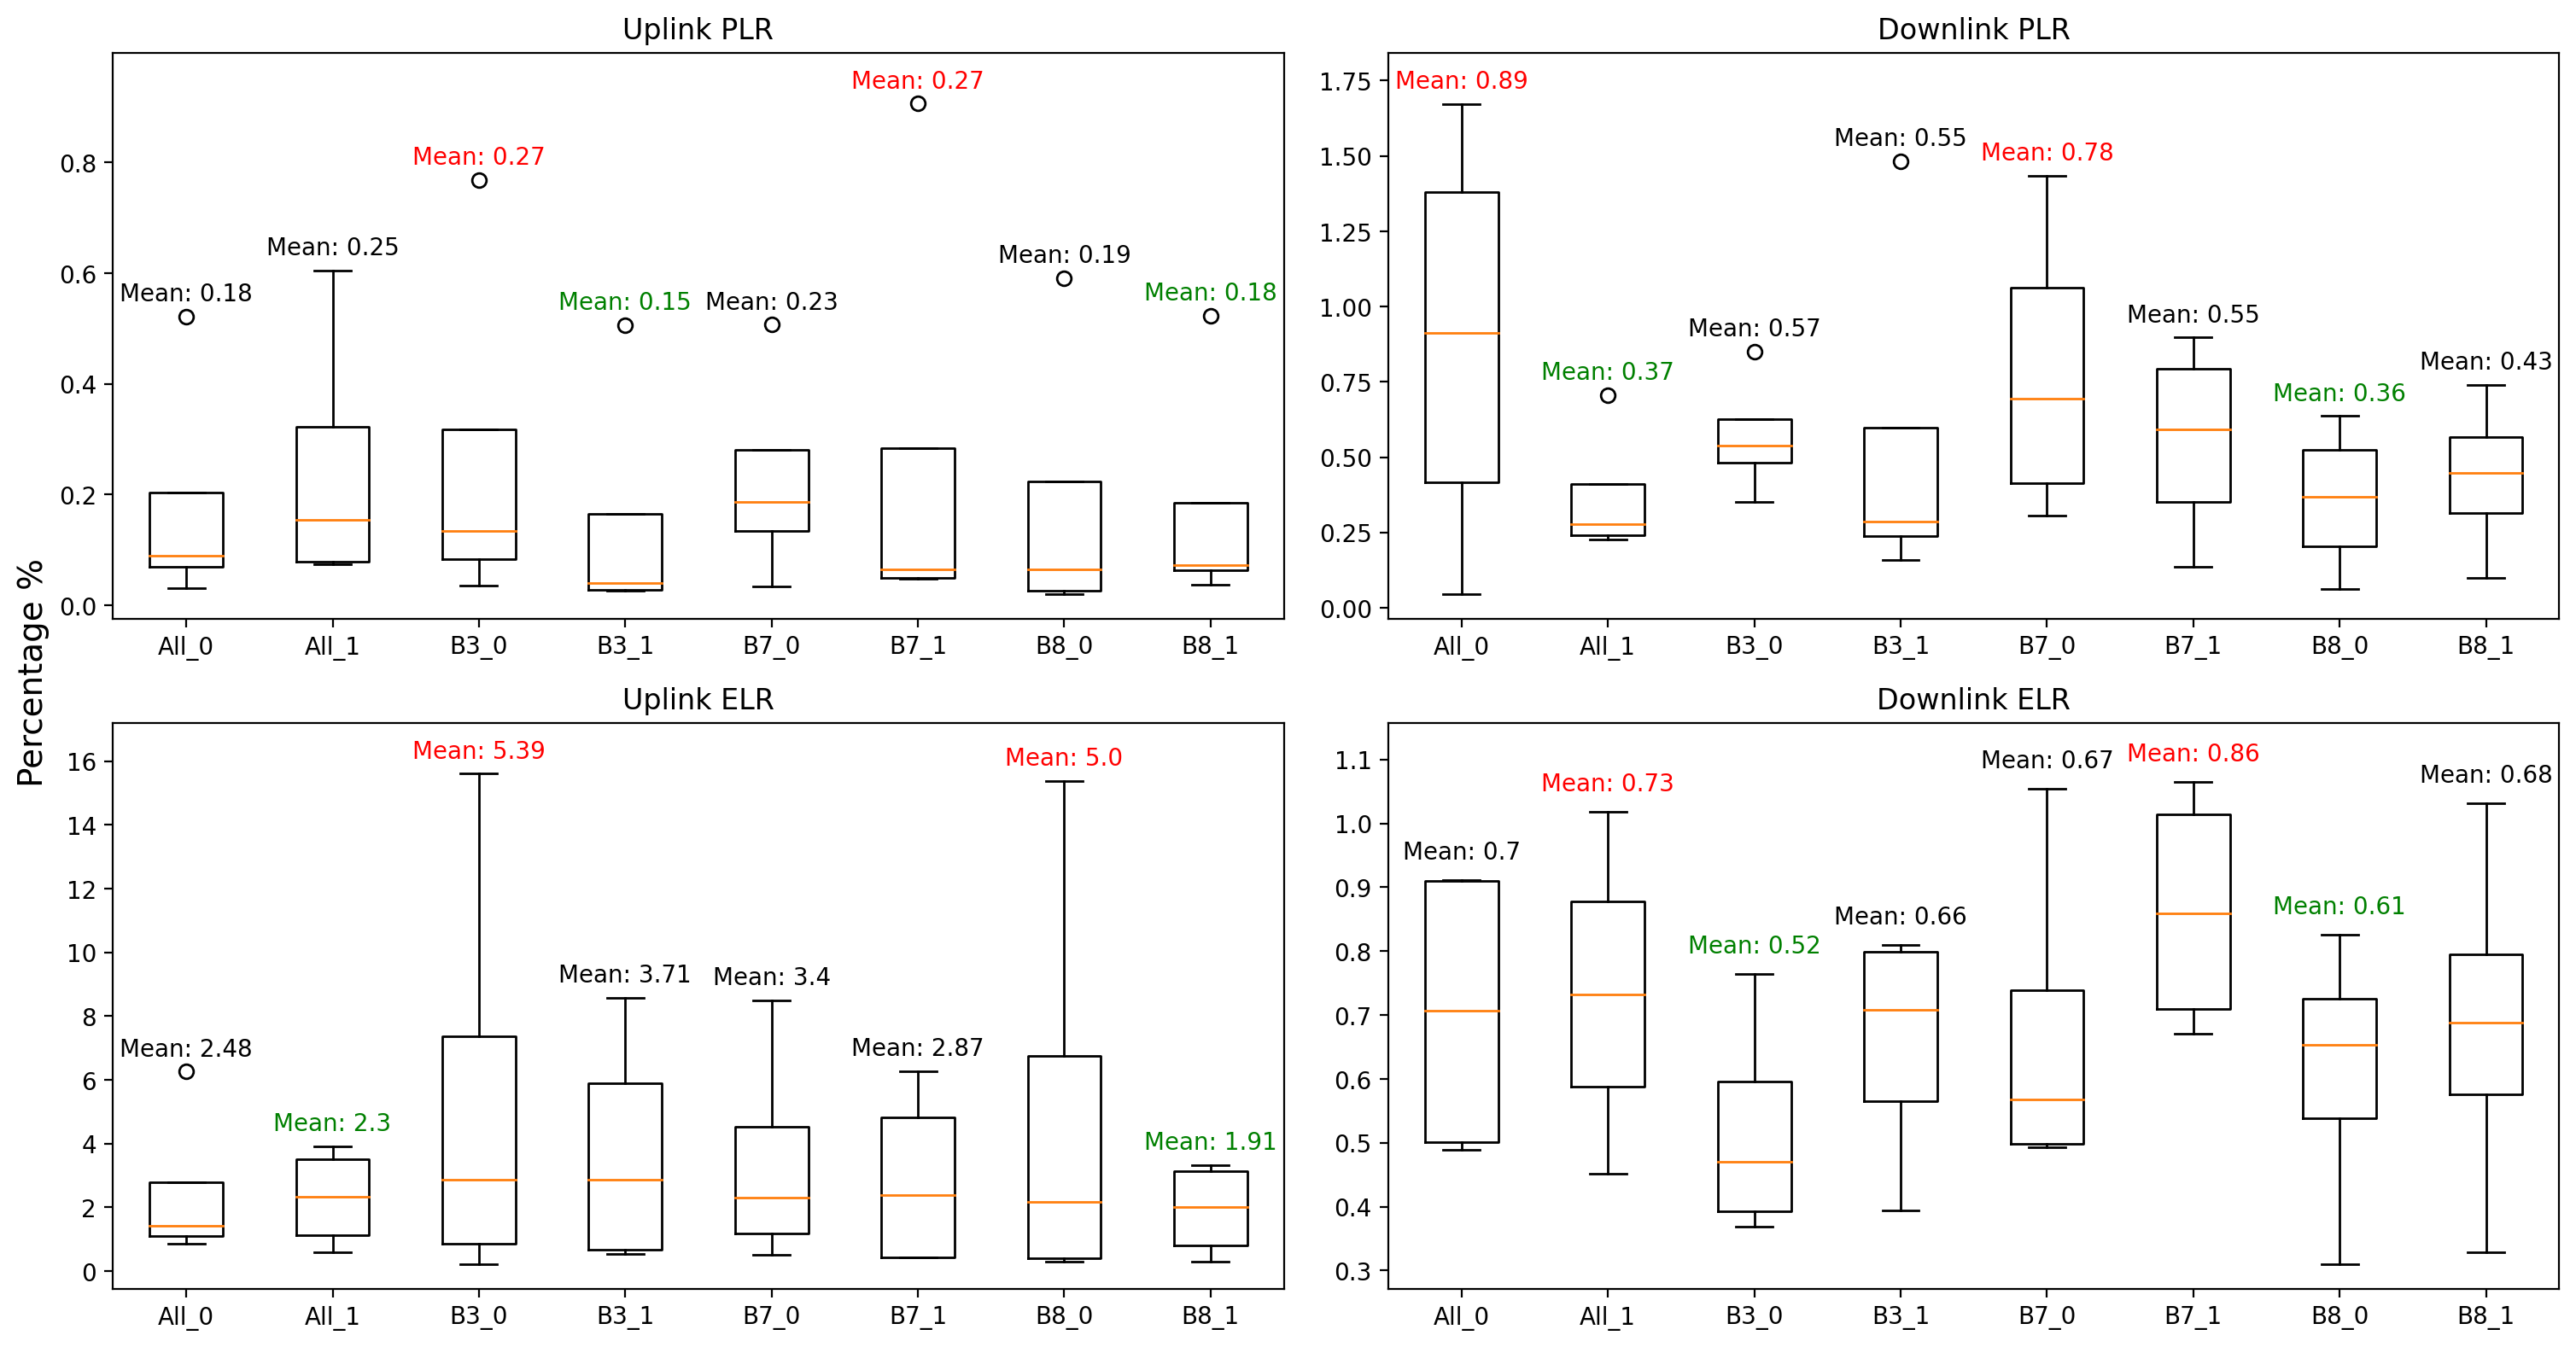

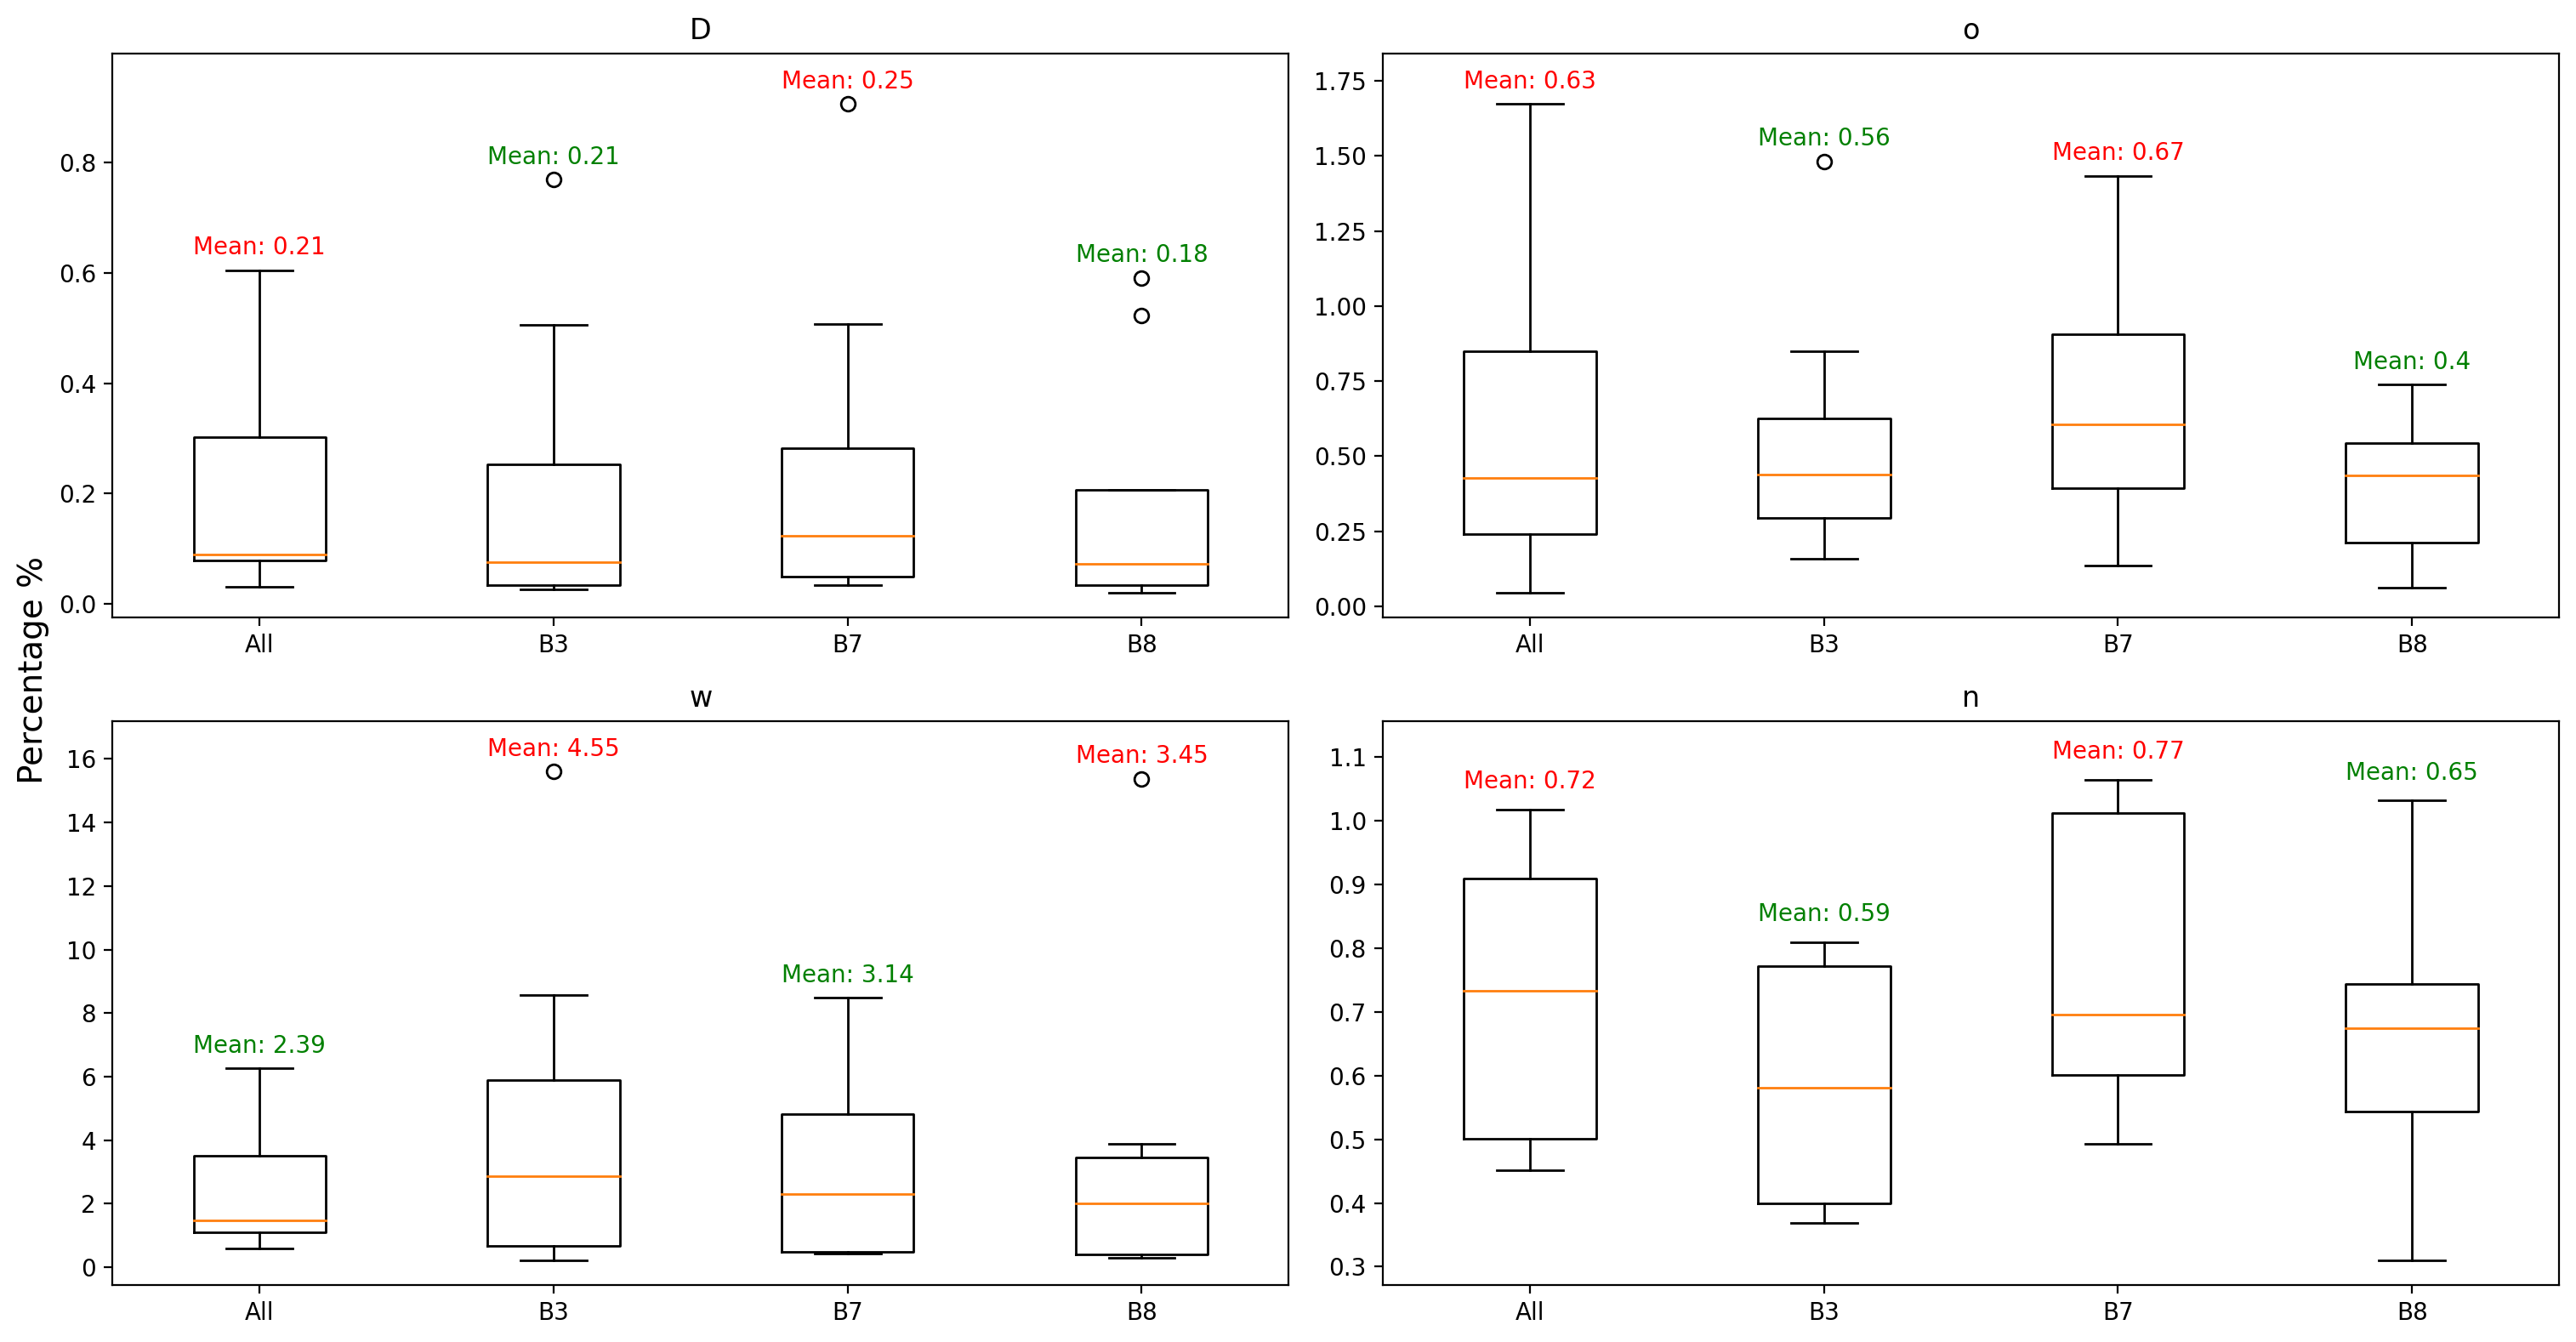

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             5   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             3   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             4   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7       #01, #03, #04, #05, #06     1.278359             7   
6   sm06   B8       #01, #03, #04, #05, #06     1.185786             6   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             2   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             6     0.831878   
5     2.532447             8     2.604340             5     0.461063   
6     1.190465             3     1.640298             3     0.531022   
7     1.476035             4     2.474258             4     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             1  
6             3  
7             4

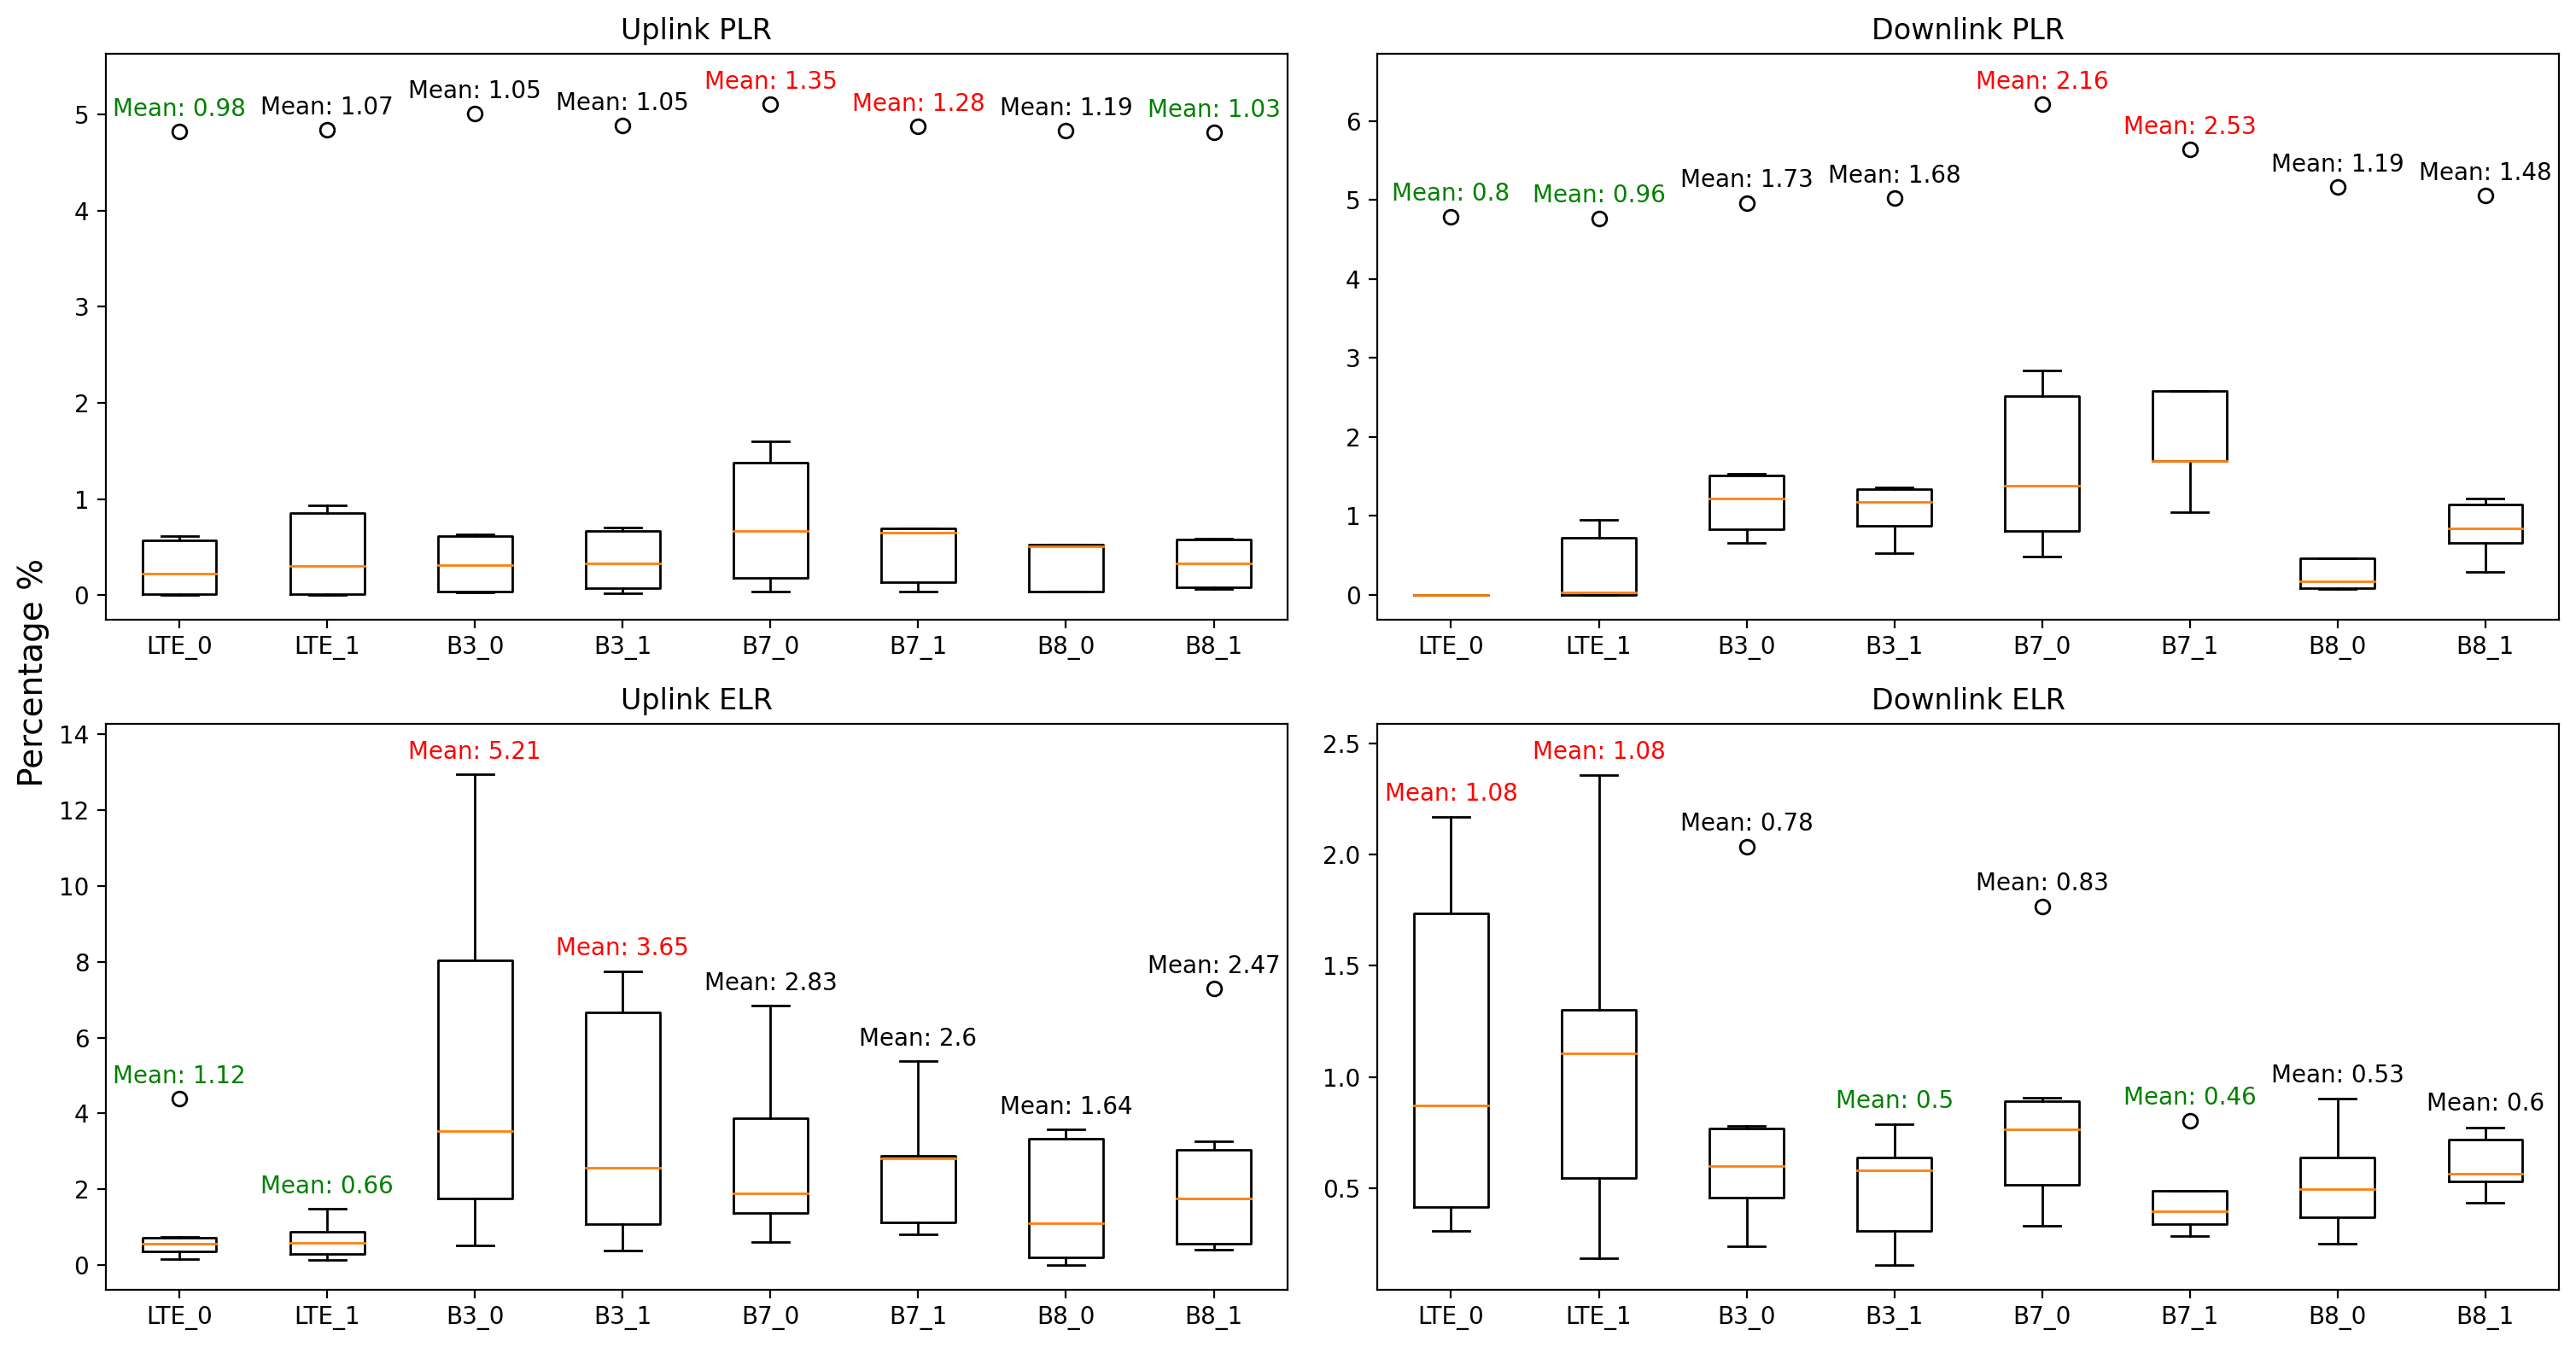

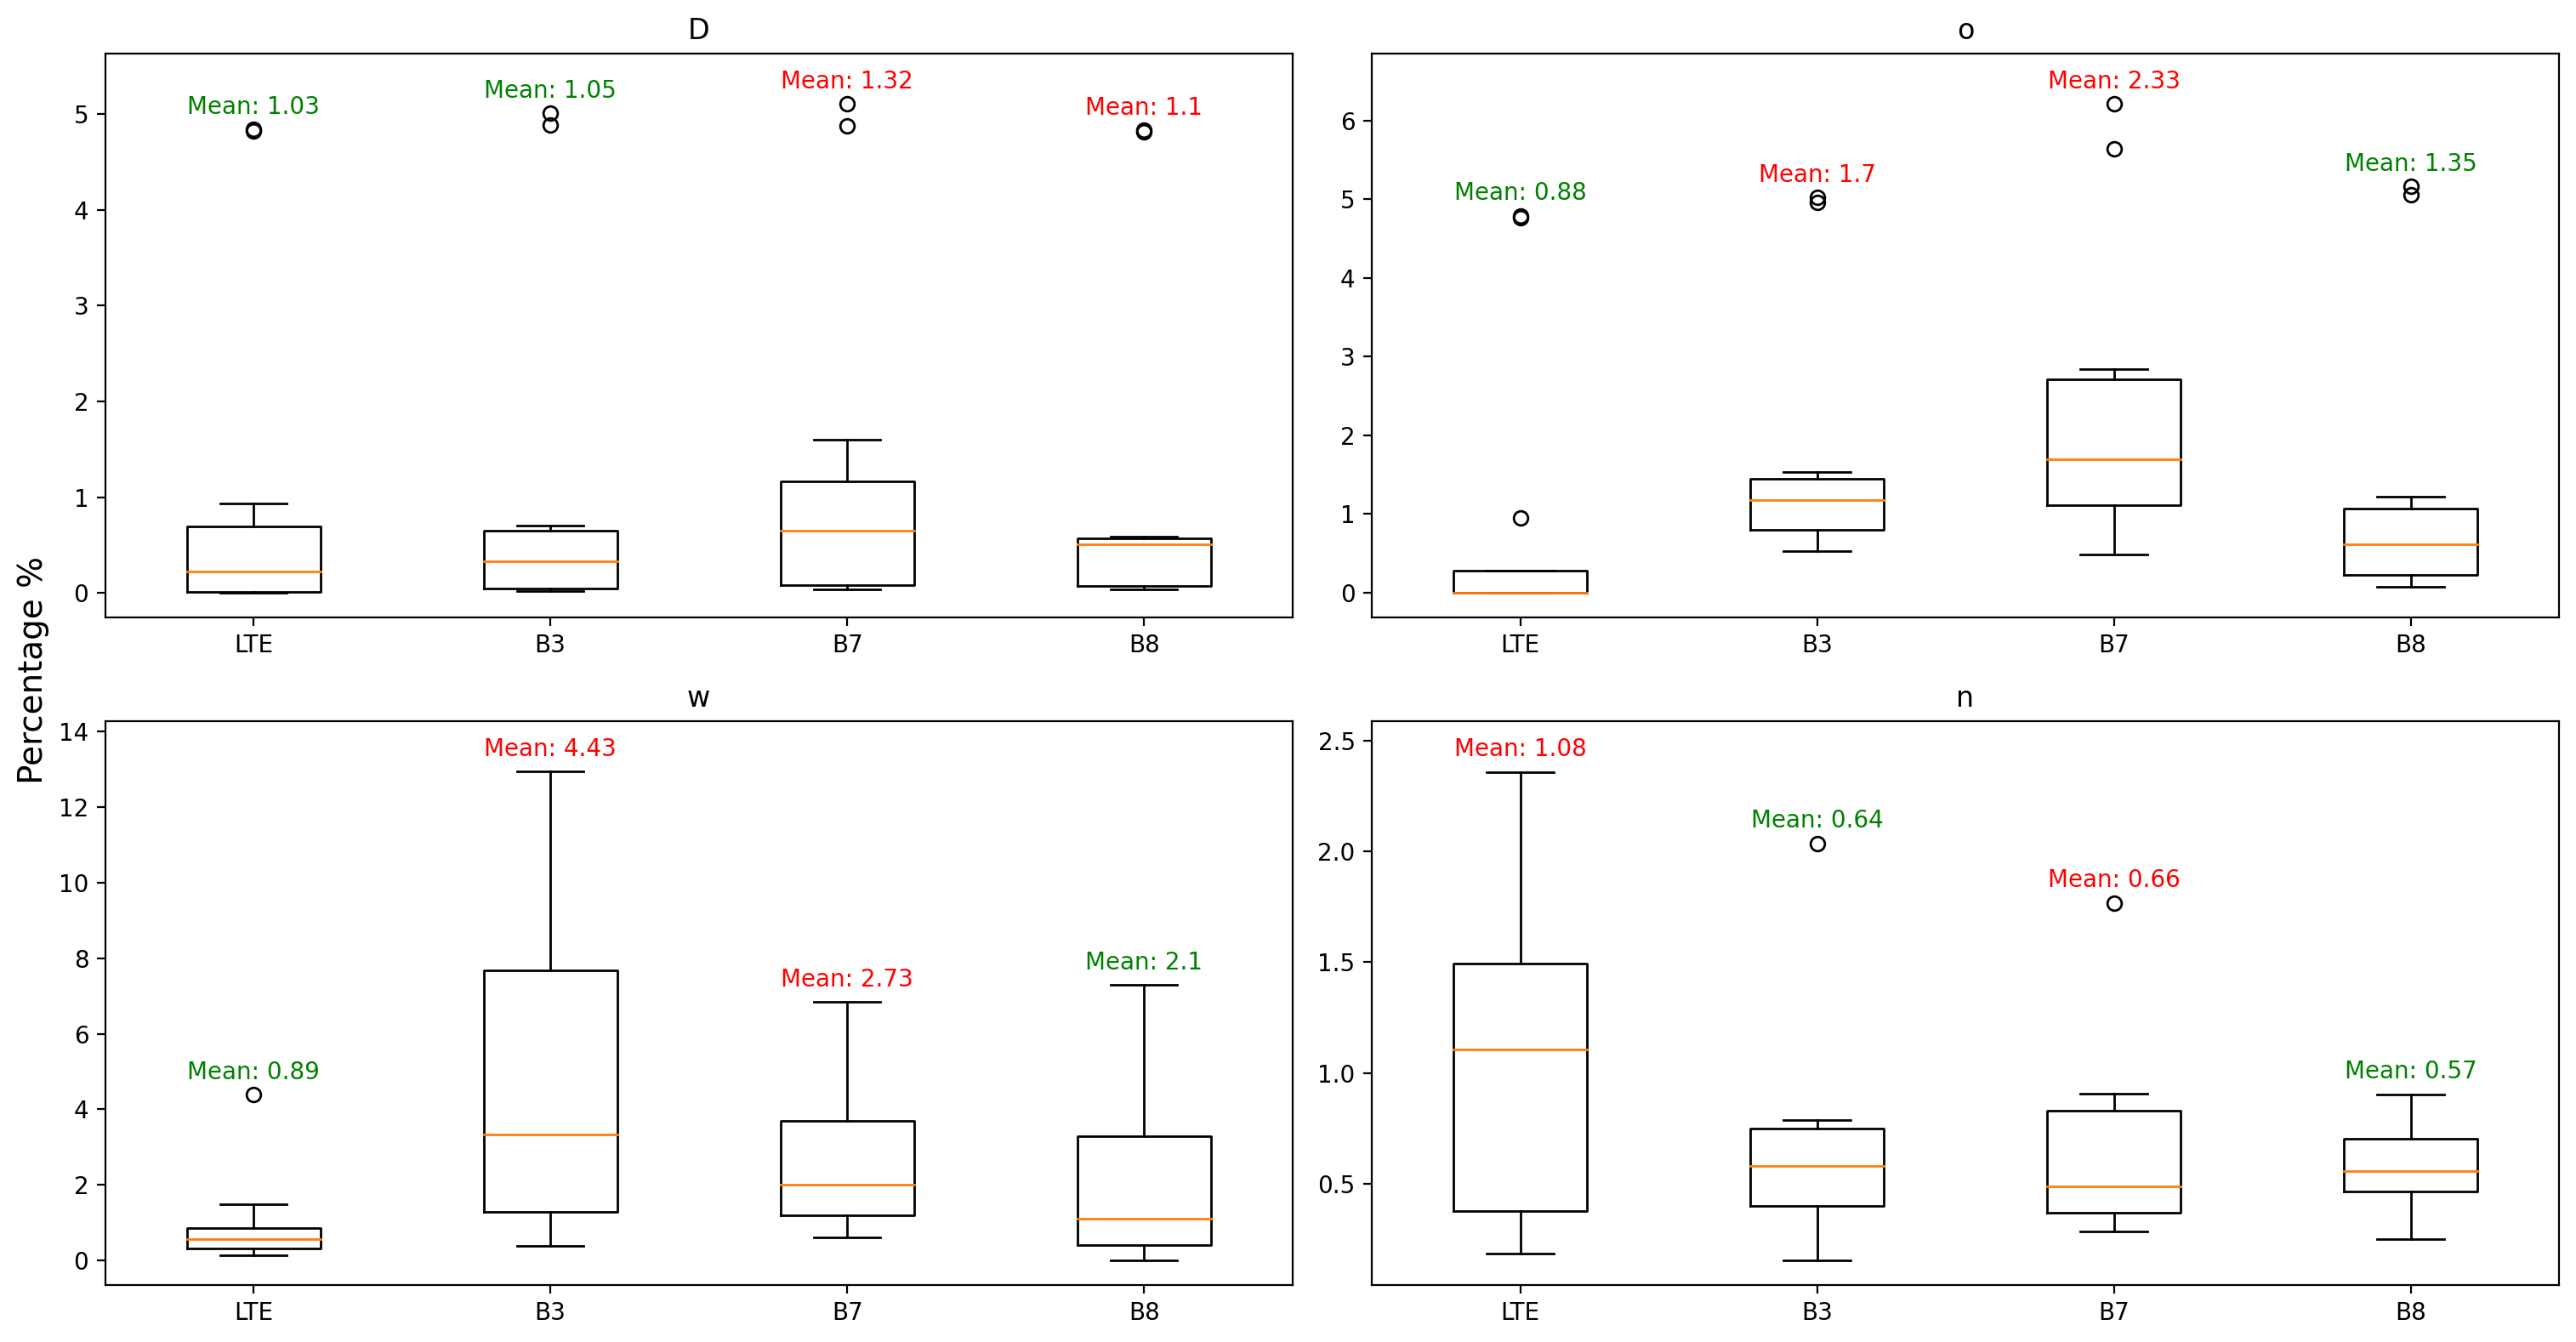

In [288]:
from collections import defaultdict

def remove_outliers(data_list):
    # 計算四分位數和四分位距
    Q1, Q3 = np.percentile(data_list, [25, 75])
    IQR = Q3 - Q1
    
    # 計算上下限
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 去除異常值
    cleaned_list = [x for x in data_list if lower_bound <= x <= upper_bound]
    
    return cleaned_list

def plot_box_plot(ax, title, boxes, labels, top_n=2):
    
    ax.boxplot(boxes, labels=labels)
    ax.set_title(title)
    
    offset = ax.get_ylim()[1] * 0.03
    box_maximals = [max(sub_list) for sub_list in boxes]
    # TODO: remove outliers or not?
    # boxes = [remove_outliers(box_data) for box_data in boxes]
    
    box_means = [np.mean(sub_list) for sub_list in boxes]
    sorted_indices = np.argsort(box_means)
    for k, (mean_value, max_value) in enumerate(zip(box_means, box_maximals)):
        mean_value = round(mean_value, 2)
        
        if k in sorted_indices[:top_n]: # the smallest two schemes
            text_color = 'green'
        elif k in sorted_indices[-top_n:]: # the largest two schemes
            text_color = 'red'
        else:
            text_color = 'black'
            
        ax.text(k + 1, max_value + offset, f'Mean: {mean_value}', ha='center', fontsize=10, color=text_color)
        
    ax.set_ylim(top=ax.get_ylim()[1] * 1.05)

for expr, metrics_dict in zip(exp_list, single_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR']
    
    ### 繪製 Box Plot (1) 對每個 “device” 的數據繪圖
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    
    for ax, tag, title in zip(axes.flatten(), tags, titles):
        boxes = [[num for num in v[tag] if num >= 0] for v in metrics_dict.values()]
        labels = add_suffix_to_duplicate_category([expr.setting[k] for k in metrics_dict.keys()])
        
        plot_box_plot(ax, title, boxes, labels)

    fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    ### 繪製 Box Plot (2) 將相同 “設定” 不同 “device” 的數據合併繪圖
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    
    for ax, tag, title in zip(axes.flatten(), tags, title):
        new_dict = defaultdict(list)
        for dev, val in metrics_dict.items():
            schm = expr.setting[dev]
            new_dict[schm] += [num for num in val[tag] if num >= 0]

        boxes = list(new_dict.values())
        labels = new_dict.keys()
        
        plot_box_plot(ax, title, boxes, labels)

    fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout()
    plt.show()

## Bar Chart: Per Round

In [289]:
data = {'#01': {'sm00': 8.0, 'sm01': 7.0, 'sm02': 5.0, 'sm03': 1.0, 'sm04': 3.0, 'sm05': 6.0, 'sm06': 2.0, 'sm07': 4.0}, 
 '#02': {'sm00': 5.0, 'sm01': 6.0, 'sm02': 1.0, 'sm03': 3.0, 'sm04': 4.0, 'sm05':  np.nan, 'sm06':  np.nan, 'sm07': 2.0}, 
 '#03': {'sm00': 2.0, 'sm01': 6.0, 'sm02': 8.0, 'sm03': 1.0, 'sm04': 7.0, 'sm05': 3.0, 'sm06': 5.0, 'sm07': 4.0}, 
 '#04': {'sm00': 2.0, 'sm01': 8.0, 'sm02': 7.0, 'sm03': 6.0, 'sm04': 4.0, 'sm05': 3.0, 'sm06': 1.0, 'sm07': 5.0}, 
 '#05': {'sm00': 8.0, 'sm01': 1.0, 'sm02': 4.0, 'sm03': 5.0, 'sm04': 7.0, 'sm05': 6.0, 'sm06': 2.0, 'sm07': 3.0}, 
 '#06': {'sm00': 4.0, 'sm01': 2.0, 'sm02': 3.0, 'sm03': 5.0, 'sm04': 7.0, 'sm05': 1.0, 'sm06': 6.0, 'sm07': 8.0}, 
 'Score': {'sm00': -3, 'sm01': -2, 'sm02': -1, 'sm03': 4, 'sm04': -3, 'sm05': 2, 'sm06': 4, 'sm07': -1}, 
 'Ranking': {'sm00': 7, 'sm01': 6, 'sm02': 4, 'sm03': 1, 'sm04': 8, 'sm05': 3, 'sm06': 2, 'sm07': 5}}

devices = ['sm00', 'sm01', 'sm02', 'sm03', 'sm04', 'sm05', 'sm06', 'sm07']
schemes = ['LTE_0', 'LTE_1', 'B3_0', 'B3_1', 'B7_0', 'B7_1', 'B8_0', 'B8_1']

updated_data = {k: {(dev, schm): v[dev] for dev, schm in zip(devices, schemes)}
                for k, v in data.items()}

# 轉換成 DataFrame 並設置兩層標頭
df = pd.DataFrame(updated_data).T
# df.columns = pd.MultiIndex.from_tuples(df.columns)

display(df)

sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       8.0   7.0  5.0  1.0  3.0  6.0  2.0  4.0
#02       5.0   6.0  1.0  3.0  4.0  NaN  NaN  2.0
#03       2.0   6.0  8.0  1.0  7.0  3.0  5.0  4.0
#04       2.0   8.0  7.0  6.0  4.0  3.0  1.0  5.0
#05       8.0   1.0  4.0  5.0  7.0  6.0  2.0  3.0
#06       4.0   2.0  3.0  5.0  7.0  1.0  6.0  8.0
Score    -3.0  -2.0 -1.0  4.0 -3.0  2.0  4.0 -1.0
Ranking   7.0   6.0  4.0  1.0  8.0  3.0  2.0  5.0

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Uplink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01         3     7    8    2    4    5    1    6
#02         5     8    6    1    7    3    2    4
#03         3     6    7    1    2    8    5    4
#04         6     5    1    3    8    4    7    2
Score       0    -3   -1    5   -2   -2    2    1
Ranking     3     2    6    7    1    5    8    4

Downlink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01         8     3    5    2    4    1    6    7
#02         8     3    4    7    6    5    1    2
#03         1     5    6    3    4    8    2    7
#04         7     2    6    4    8    5    3    1
Score      -3     1    0    0   -2    0    3    1
Ranking     2     1    4    7    5    6    3    8

Uplink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01         6     7    5    3    8    2    1    4
#02         3     2    8    6    5    4    7    1
#03         8     6    1    7    5    3    4    2
#04         1     5    7    8    3    6    4    2
Score       0     0   -1   -3   -2    1    1    4
Ranking     1     2    3    7    8    6    4    5

Downlink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01         5     6    3    4    8    2    1    7
#02         3     8    1    2    5    7    4    6
#03         7     4    3    5    2    8    6    1
#04         4     2    1    5    3    8    7    6
Score      -1    -1    4    1   -1   -4    1    1
Ranking     2     3    8    5    4    1    6    7

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #01


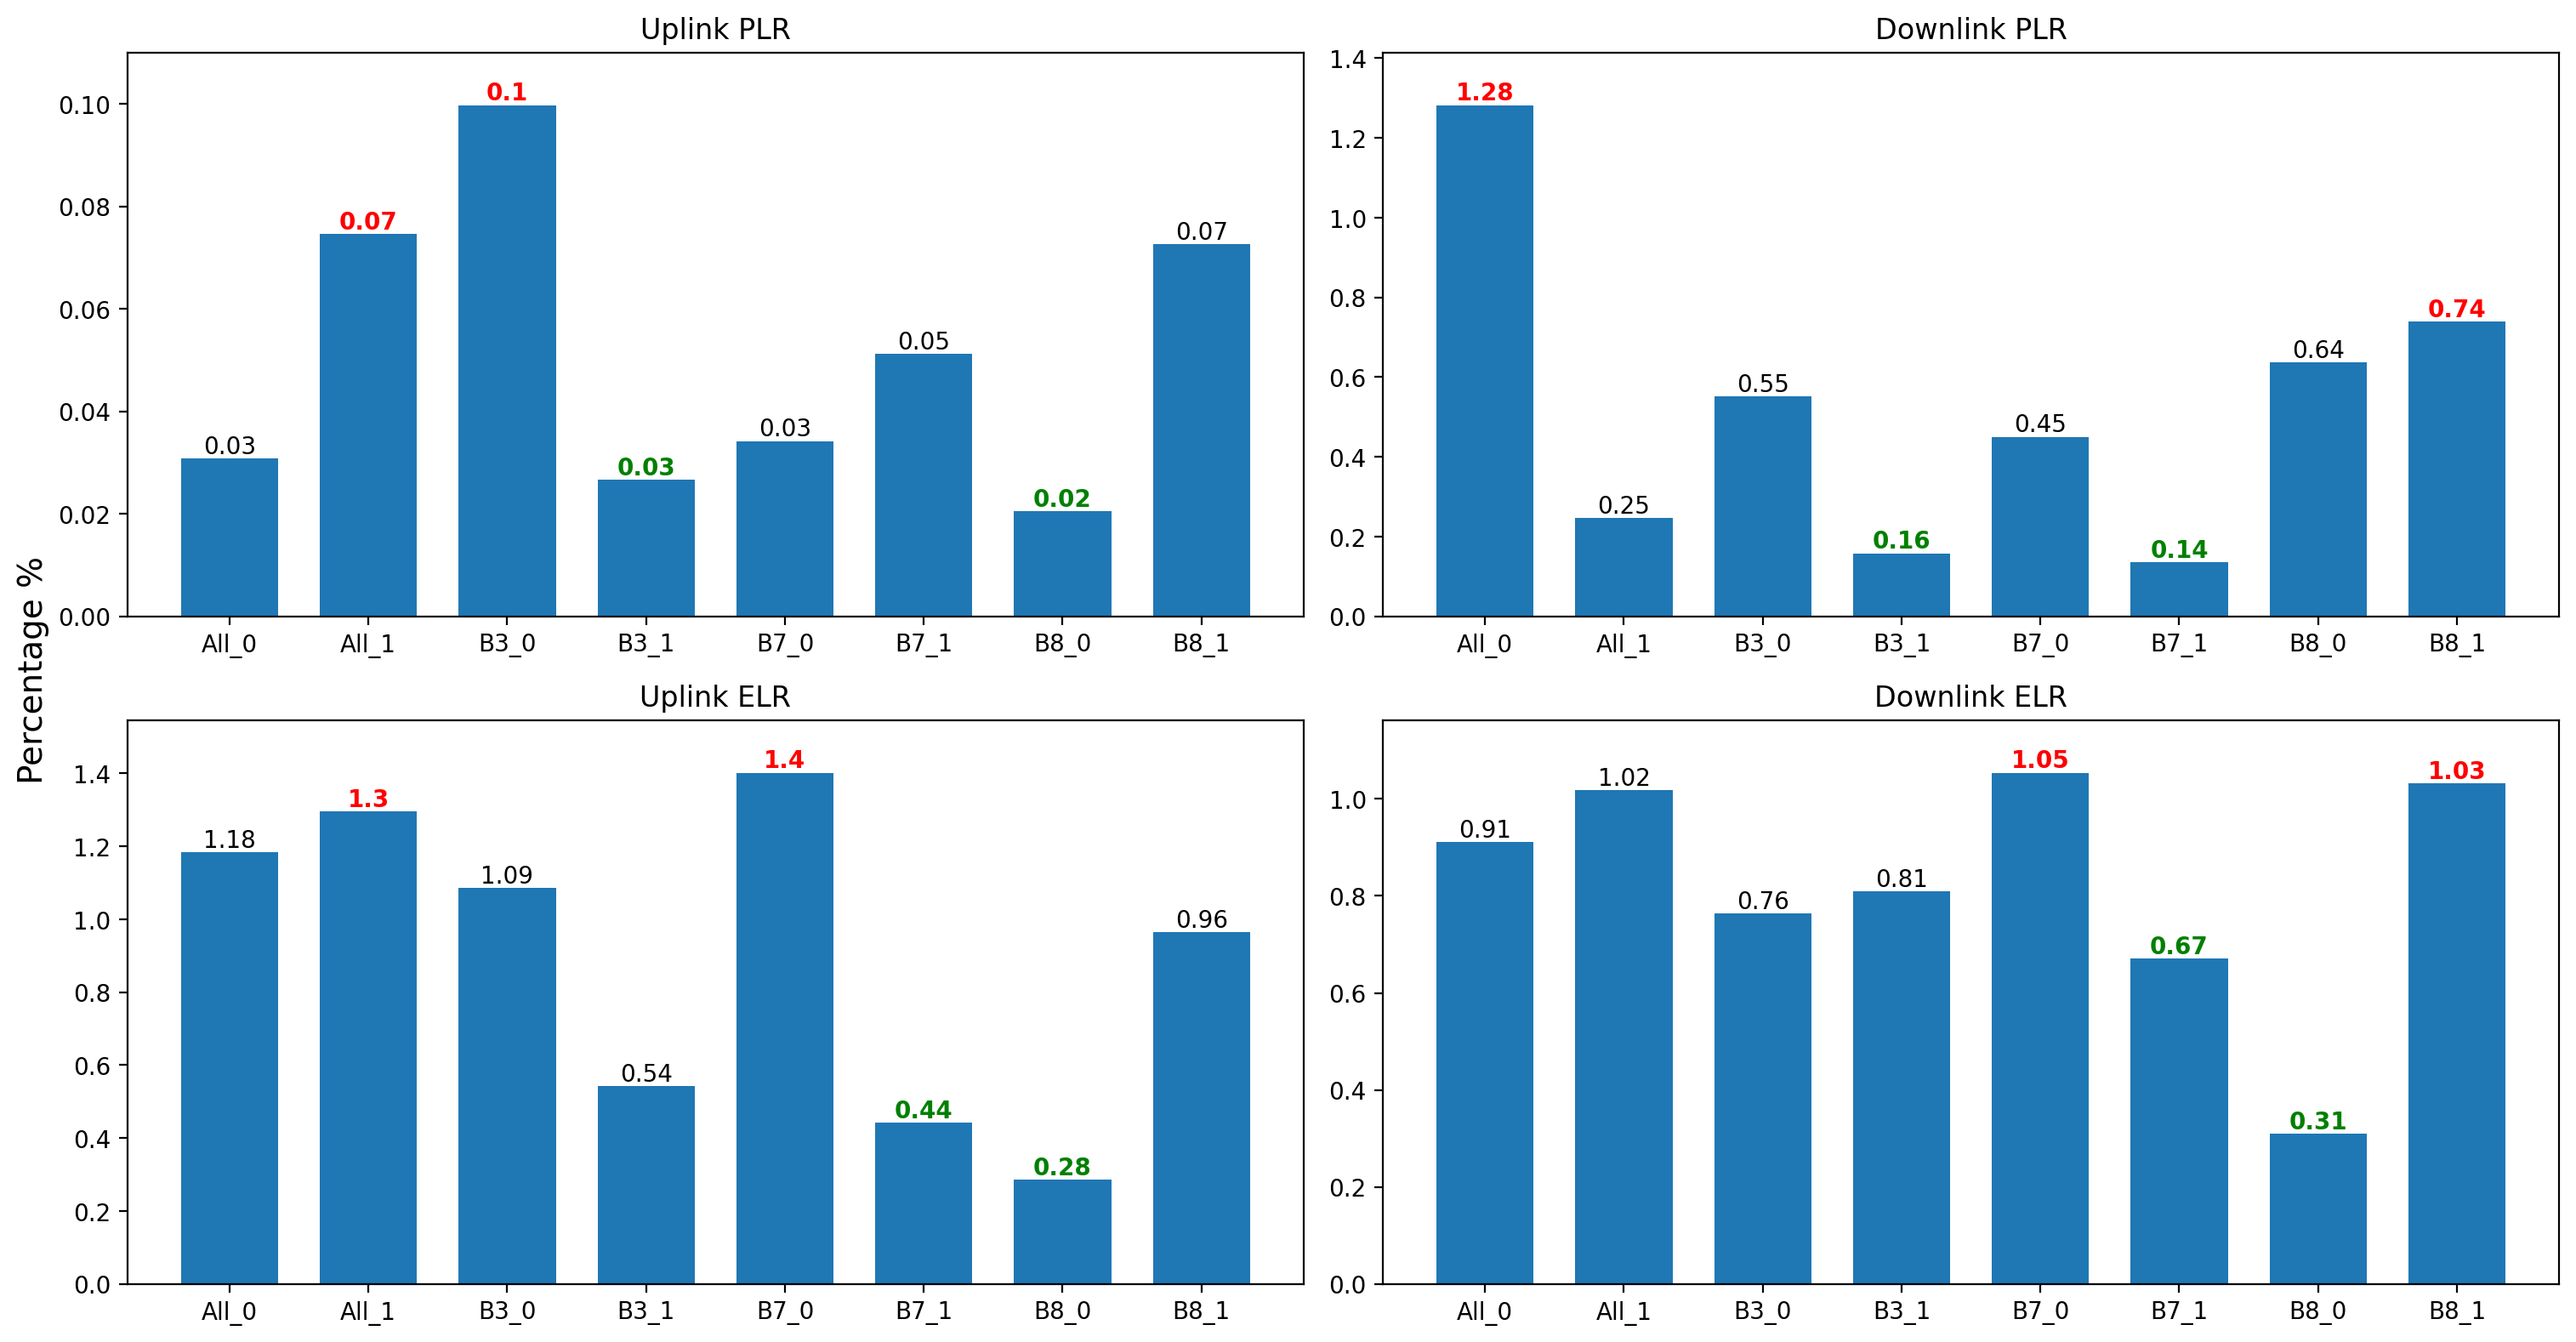

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #02


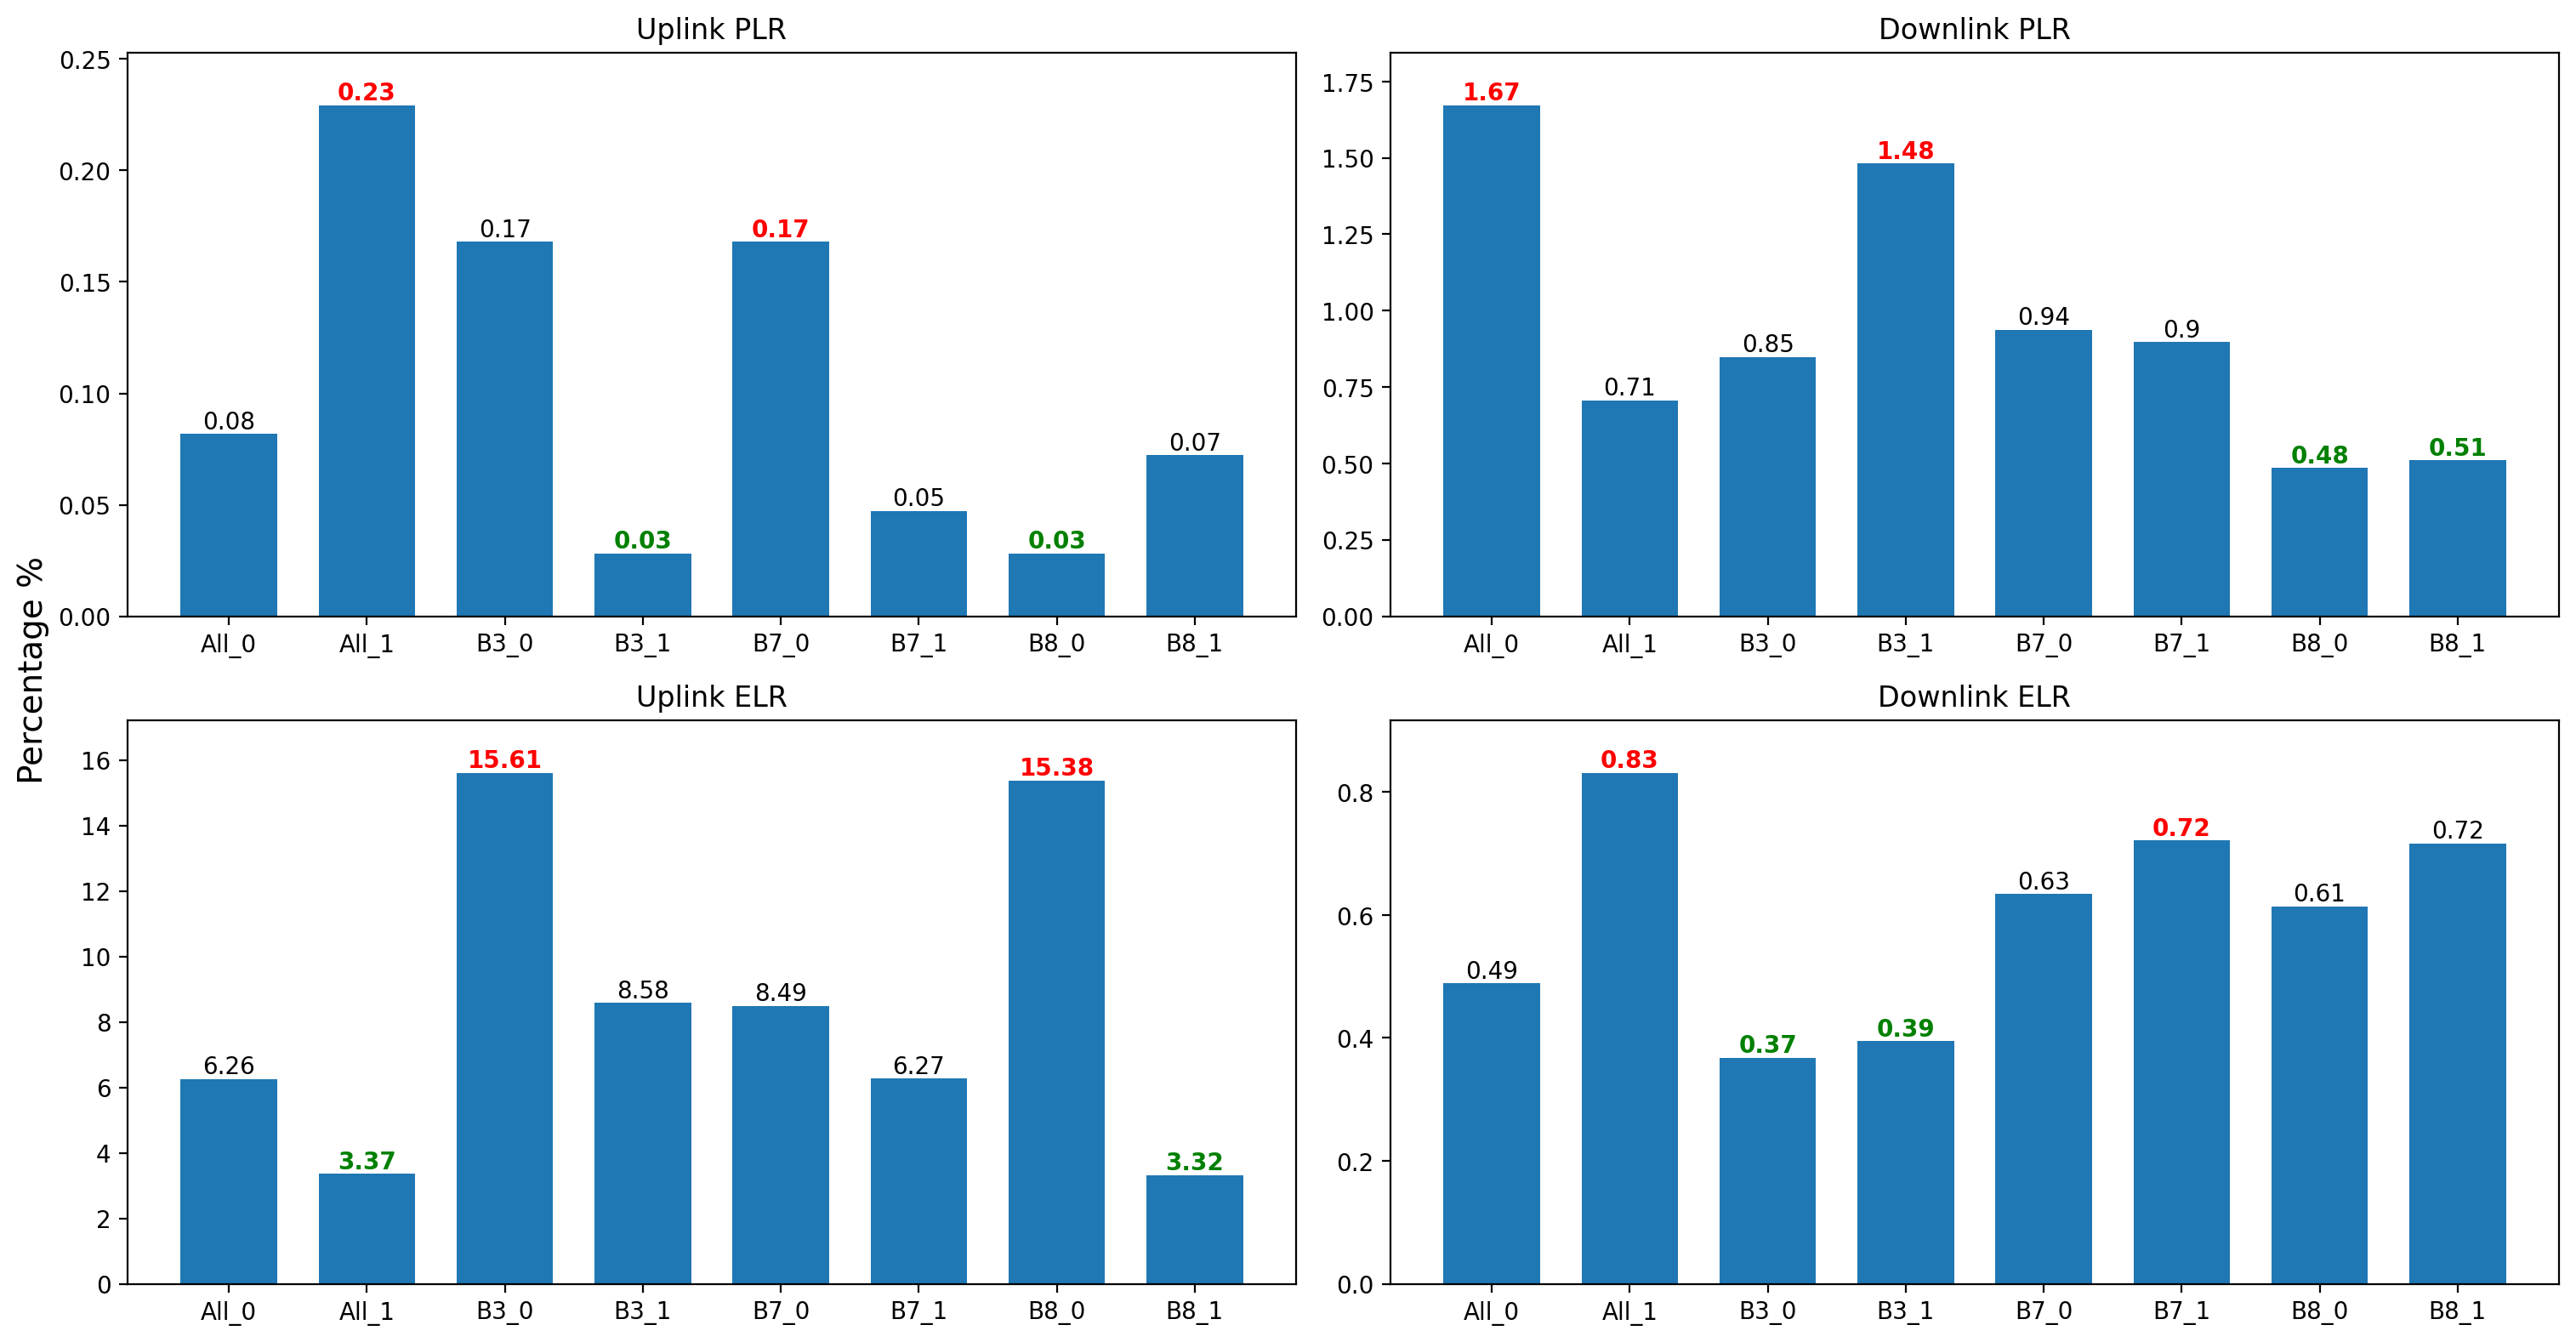

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #03


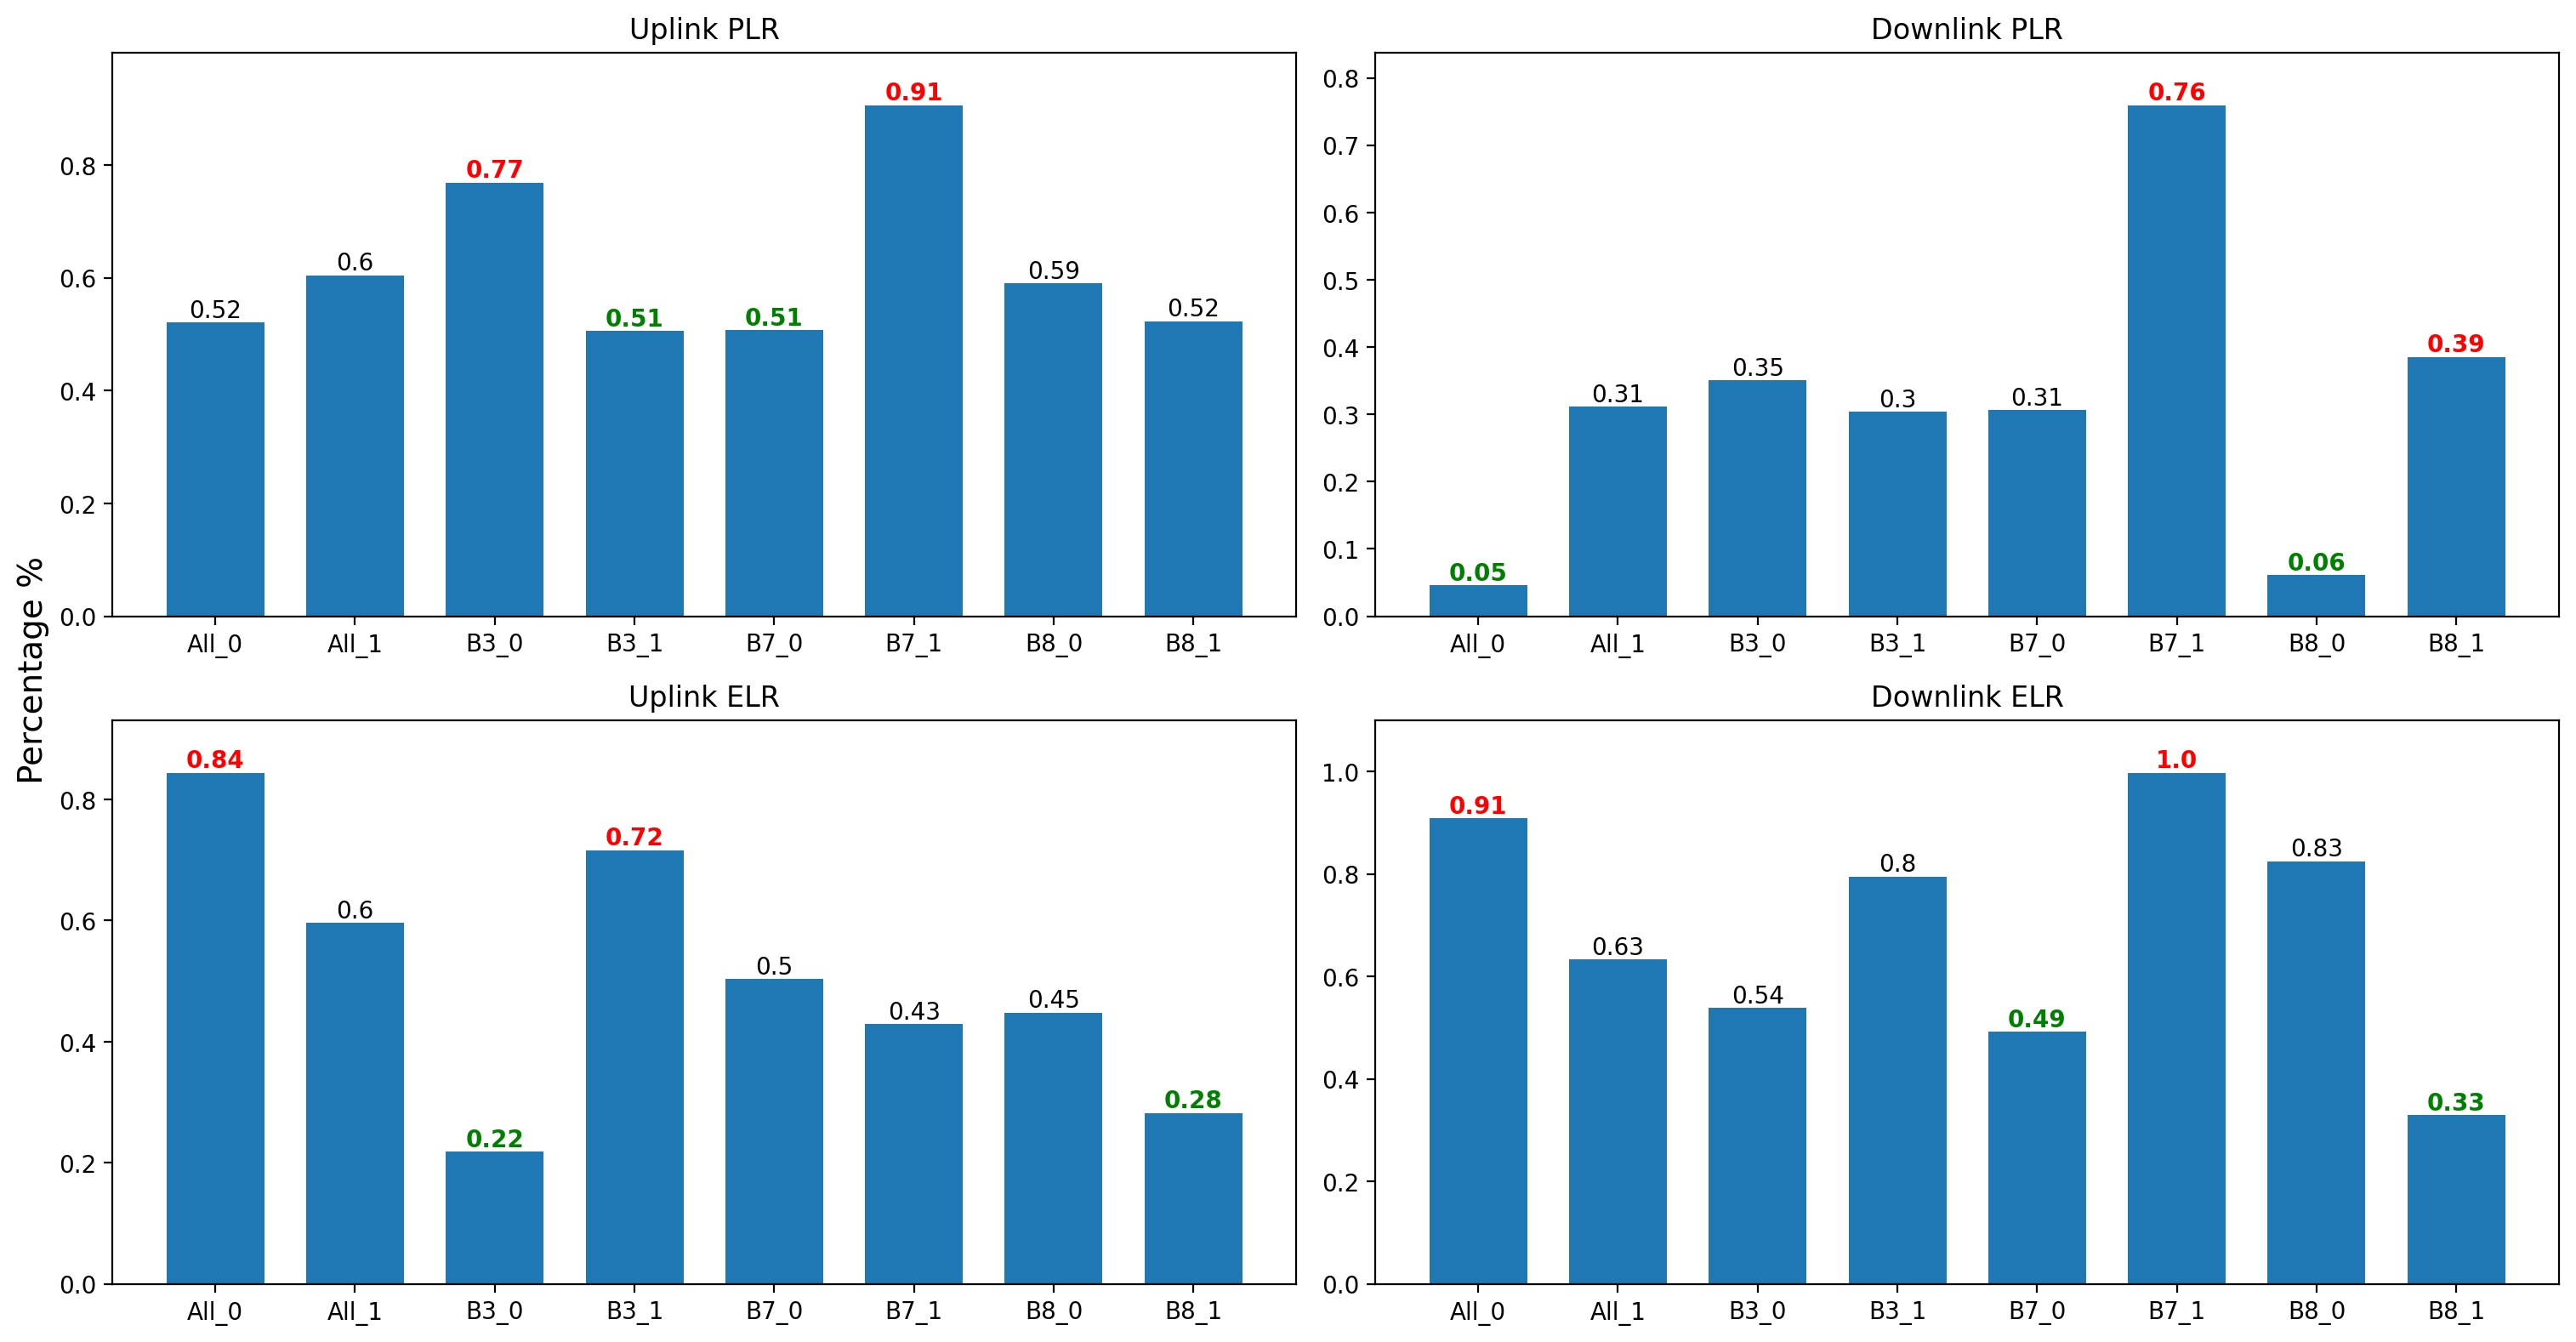

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #04


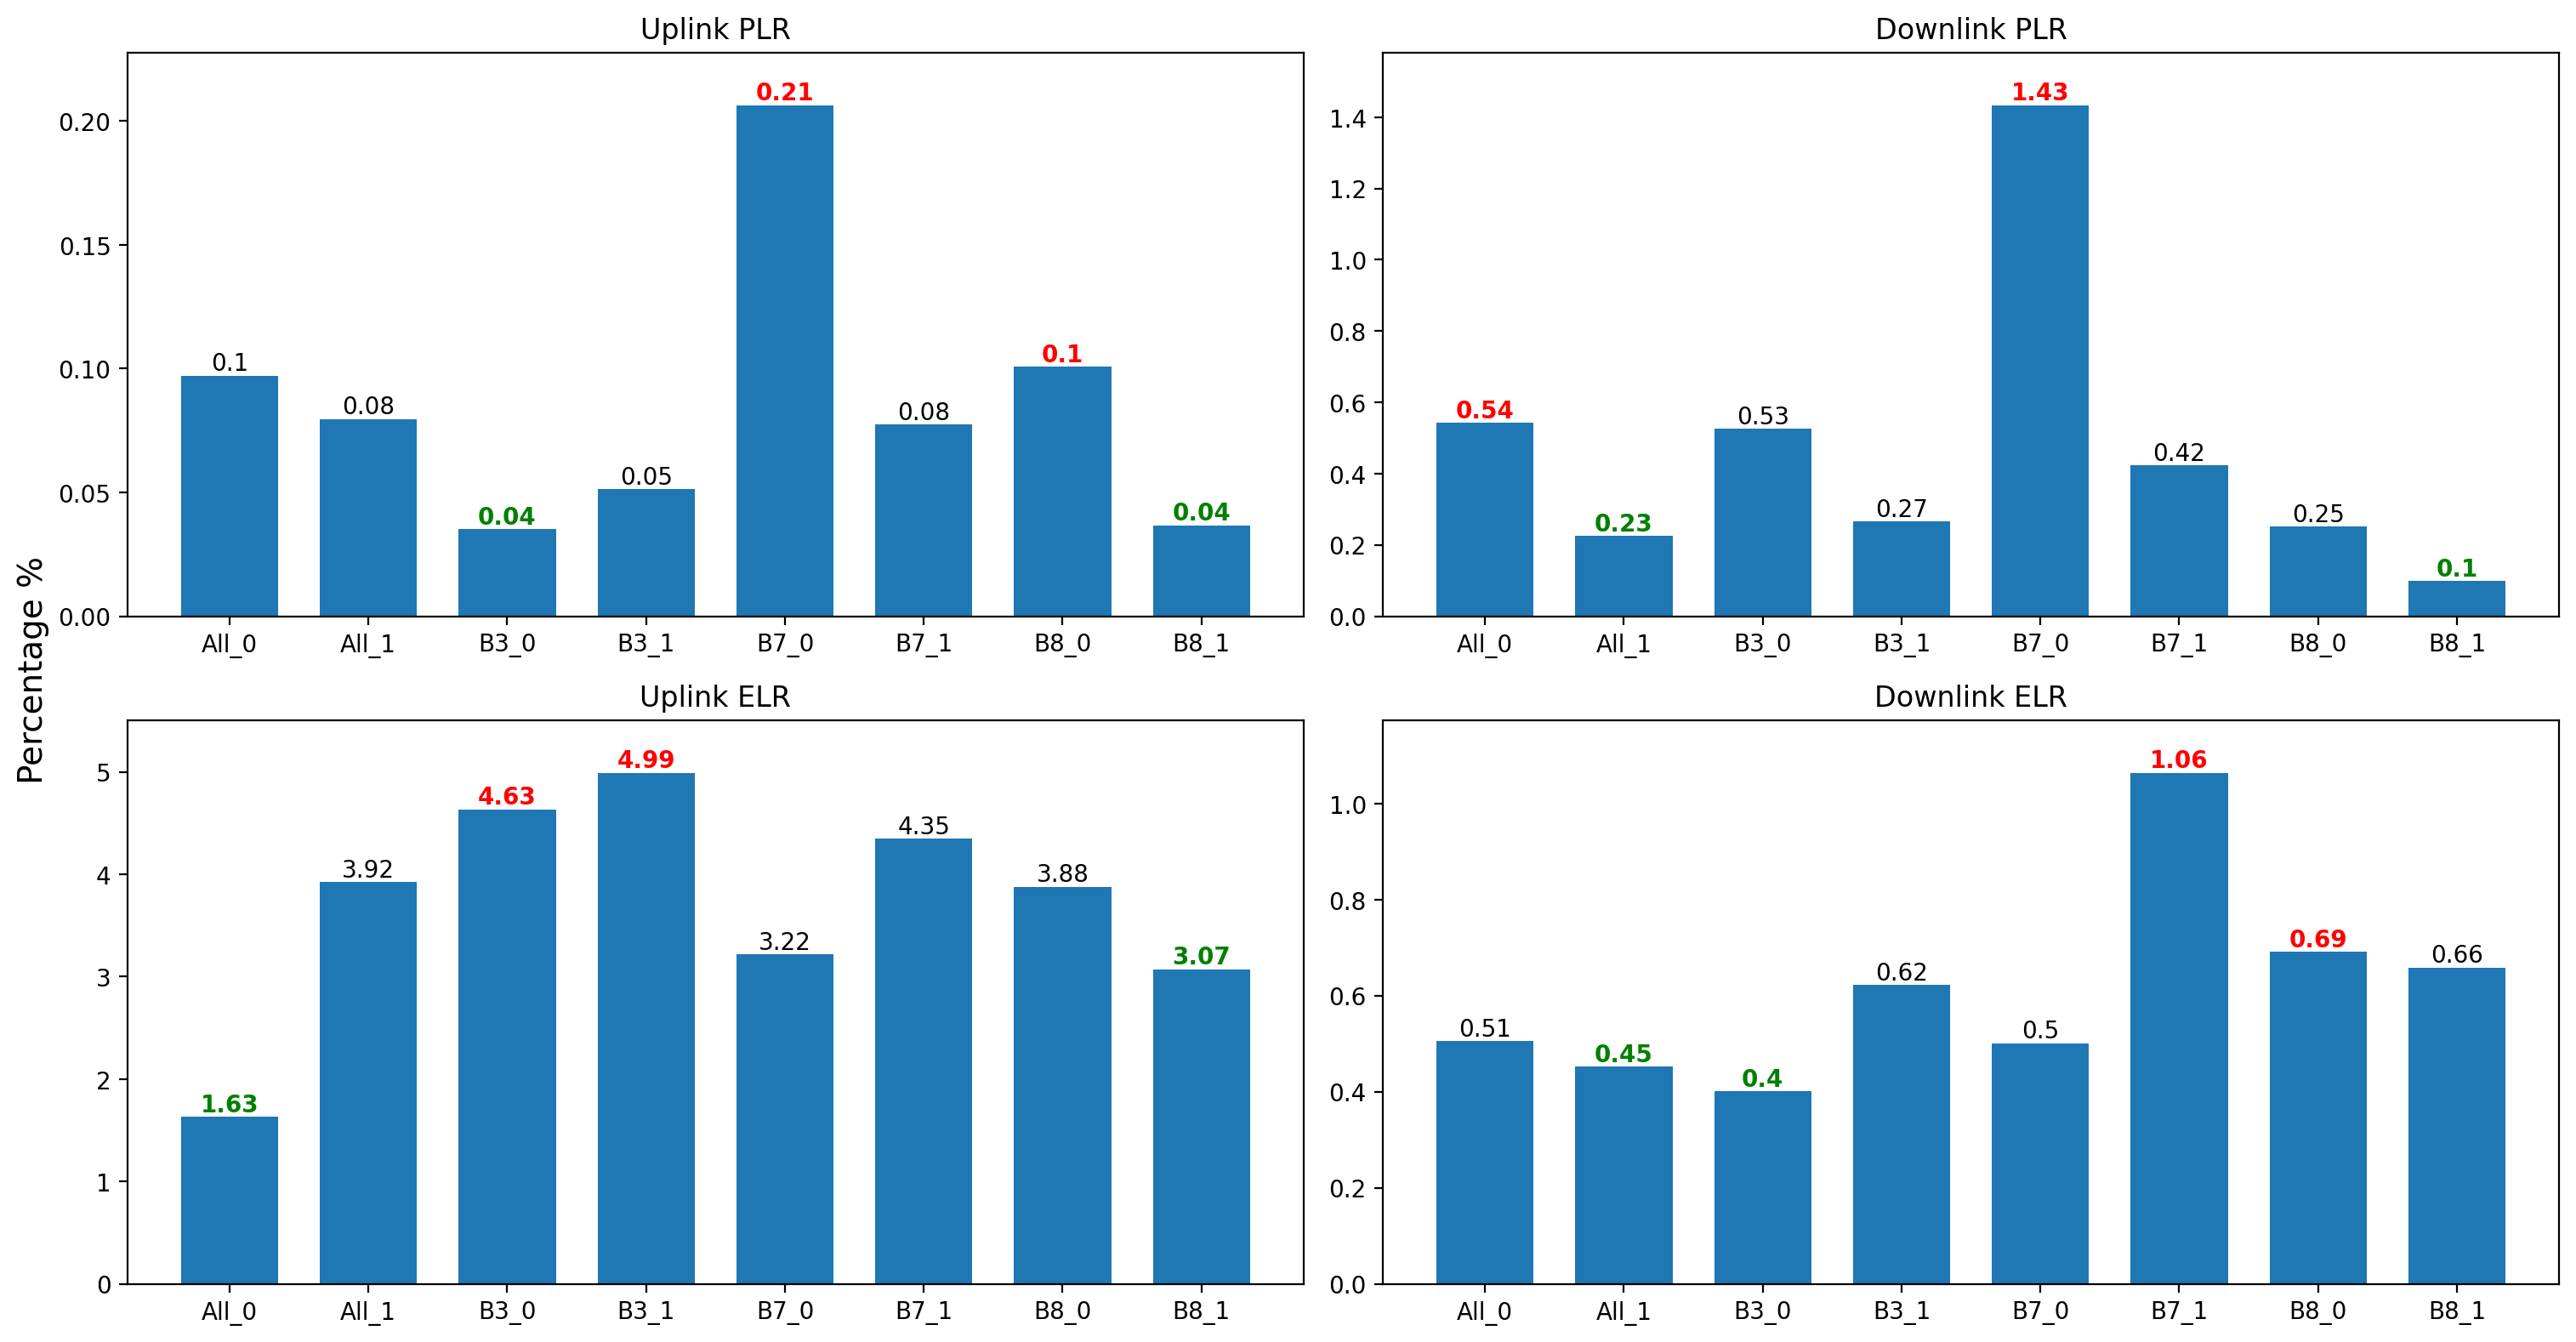

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             5   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             3   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             4   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7       #01, #03, #04, #05, #06     1.278359             7   
6   sm06   B8       #01, #03, #04, #05, #06     1.185786             6   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             2   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             6     0.831878   
5     2.532447             8     2.604340             5     0.461063   
6     1.190465             3     1.640298             3     0.531022   
7     1.476035             4     2.474258             4     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             1  
6             3  
7             4

Uplink PLR Ranking:


sm00  sm01 sm02 sm03 sm04  sm05  sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0  B7_1  B8_0 B8_1
#01         5     3    6    8    4     7     1    2
#02         2     1    3    4    6  <NA>  <NA>    5
#03         1     2    7    3    5     4     6    8
#04         1     7    4    3    8     6     2    5
#05         2     4    7    6    8     5     3    1
#06         2     1    3    7    4     8     5    6
Score       7     4   -2   -3   -6    -3     3    0
Ranking     4     3    6    8    7     5     2    1

Downlink PLR Ranking:


sm00  sm01 sm02 sm03 sm04  sm05  sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0  B7_1  B8_0 B8_1
#01         1     2    4    7    6     8     3    5
#02         1     2    5    3    6  <NA>  <NA>    4
#03         1     2    7    5    6     8     4    3
#04         1     5    4    6    7     8     2    3
#05         2     1    3    4    8     7     6    5
#06         1     2    7    6    4     8     3    5
Score      11     6   -3   -1   -5    -9     1    0
Ranking     4     3    8    7    5     6     2    1

Uplink ELR Ranking:


sm00  sm01 sm02 sm03 sm04  sm05  sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0  B7_1  B8_0 B8_1
#01         5     6    3    7    4     8     1    2
#02         1     2    6    5    3  <NA>  <NA>    4
#03         1     2    7    5    8     6     4    3
#04         1     2    8    7    3     6     5    4
#05         5     1    8    3    7     6     2    4
#06         8     1    5    7    2     4     6    3
Score       4     7   -7   -4   -2    -2     3    1
Ranking     4     3    5    6    7     8     1    2

Downlink ELR Ranking:


sm00  sm01 sm02 sm03 sm04  sm05  sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0  B7_1  B8_0 B8_1
#01         8     7    5    1    3     6     2    4
#02         5     6    1    3    4  <NA>  <NA>    2
#03         2     6    8    1    7     3     5    4
#04         2     8    7    6    4     3     1    5
#05         8     1    4    5    7     6     2    3
#06         4     2    3    5    7     1     6    8
Score      -3    -2   -1    4   -3     2     4   -1
Ranking     4     1    3    7    2     5     6    8

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #01


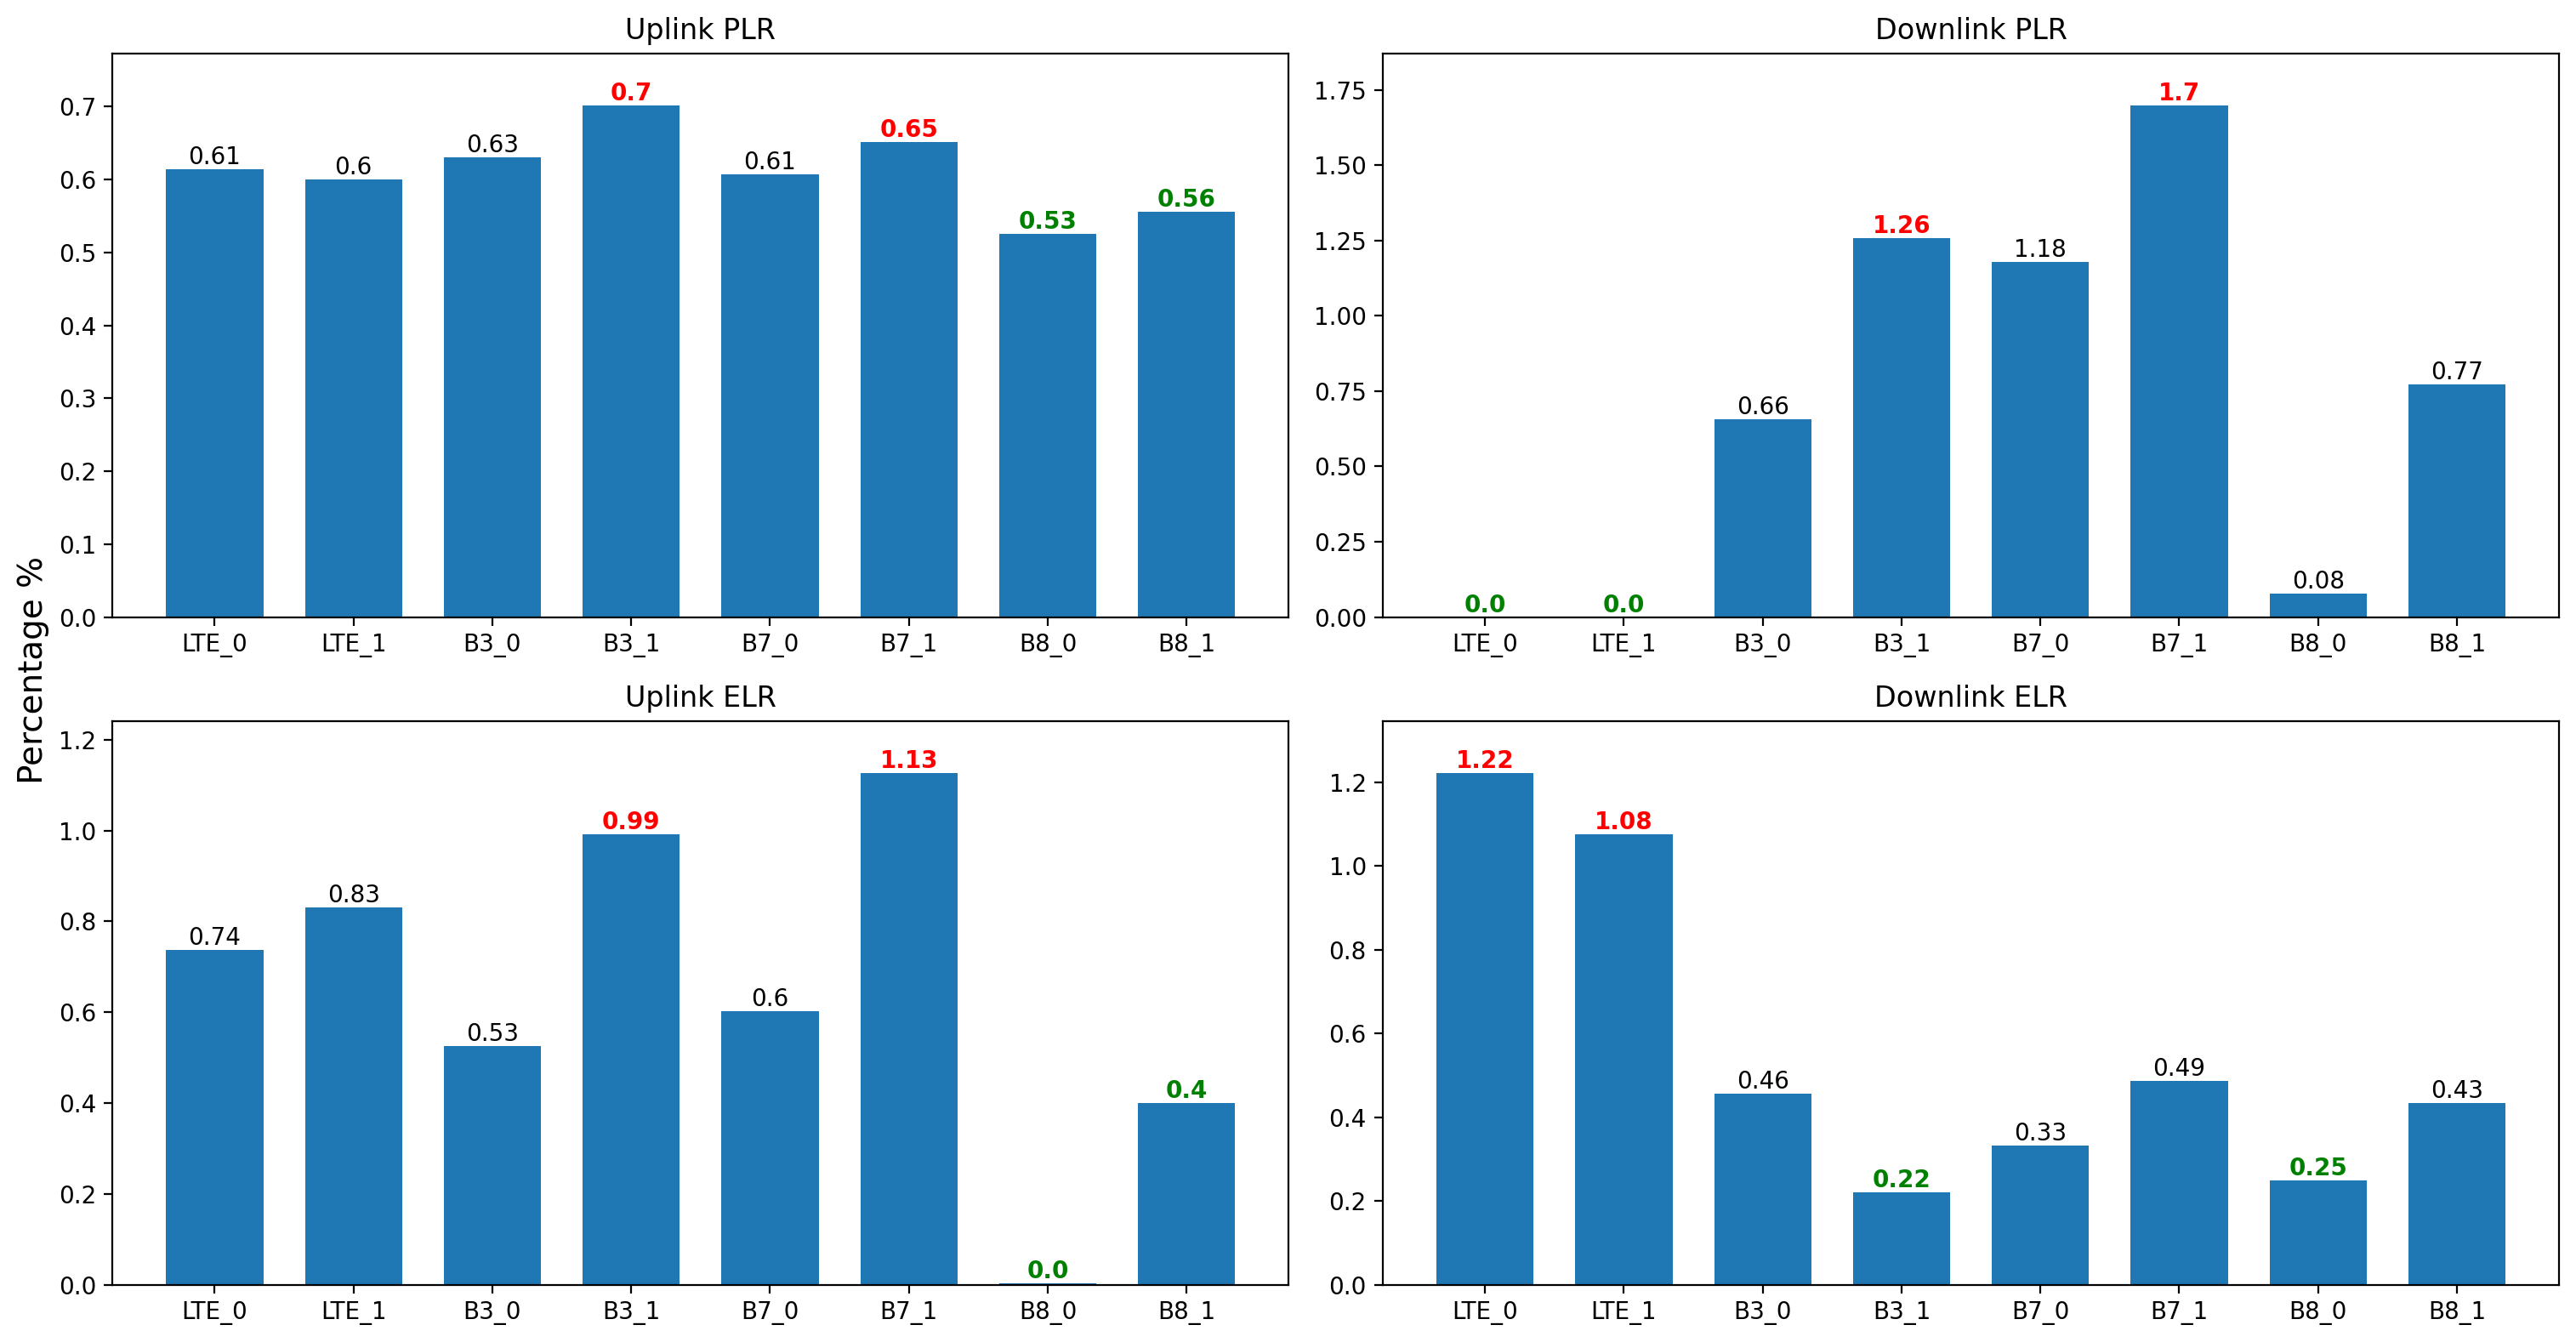

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #02


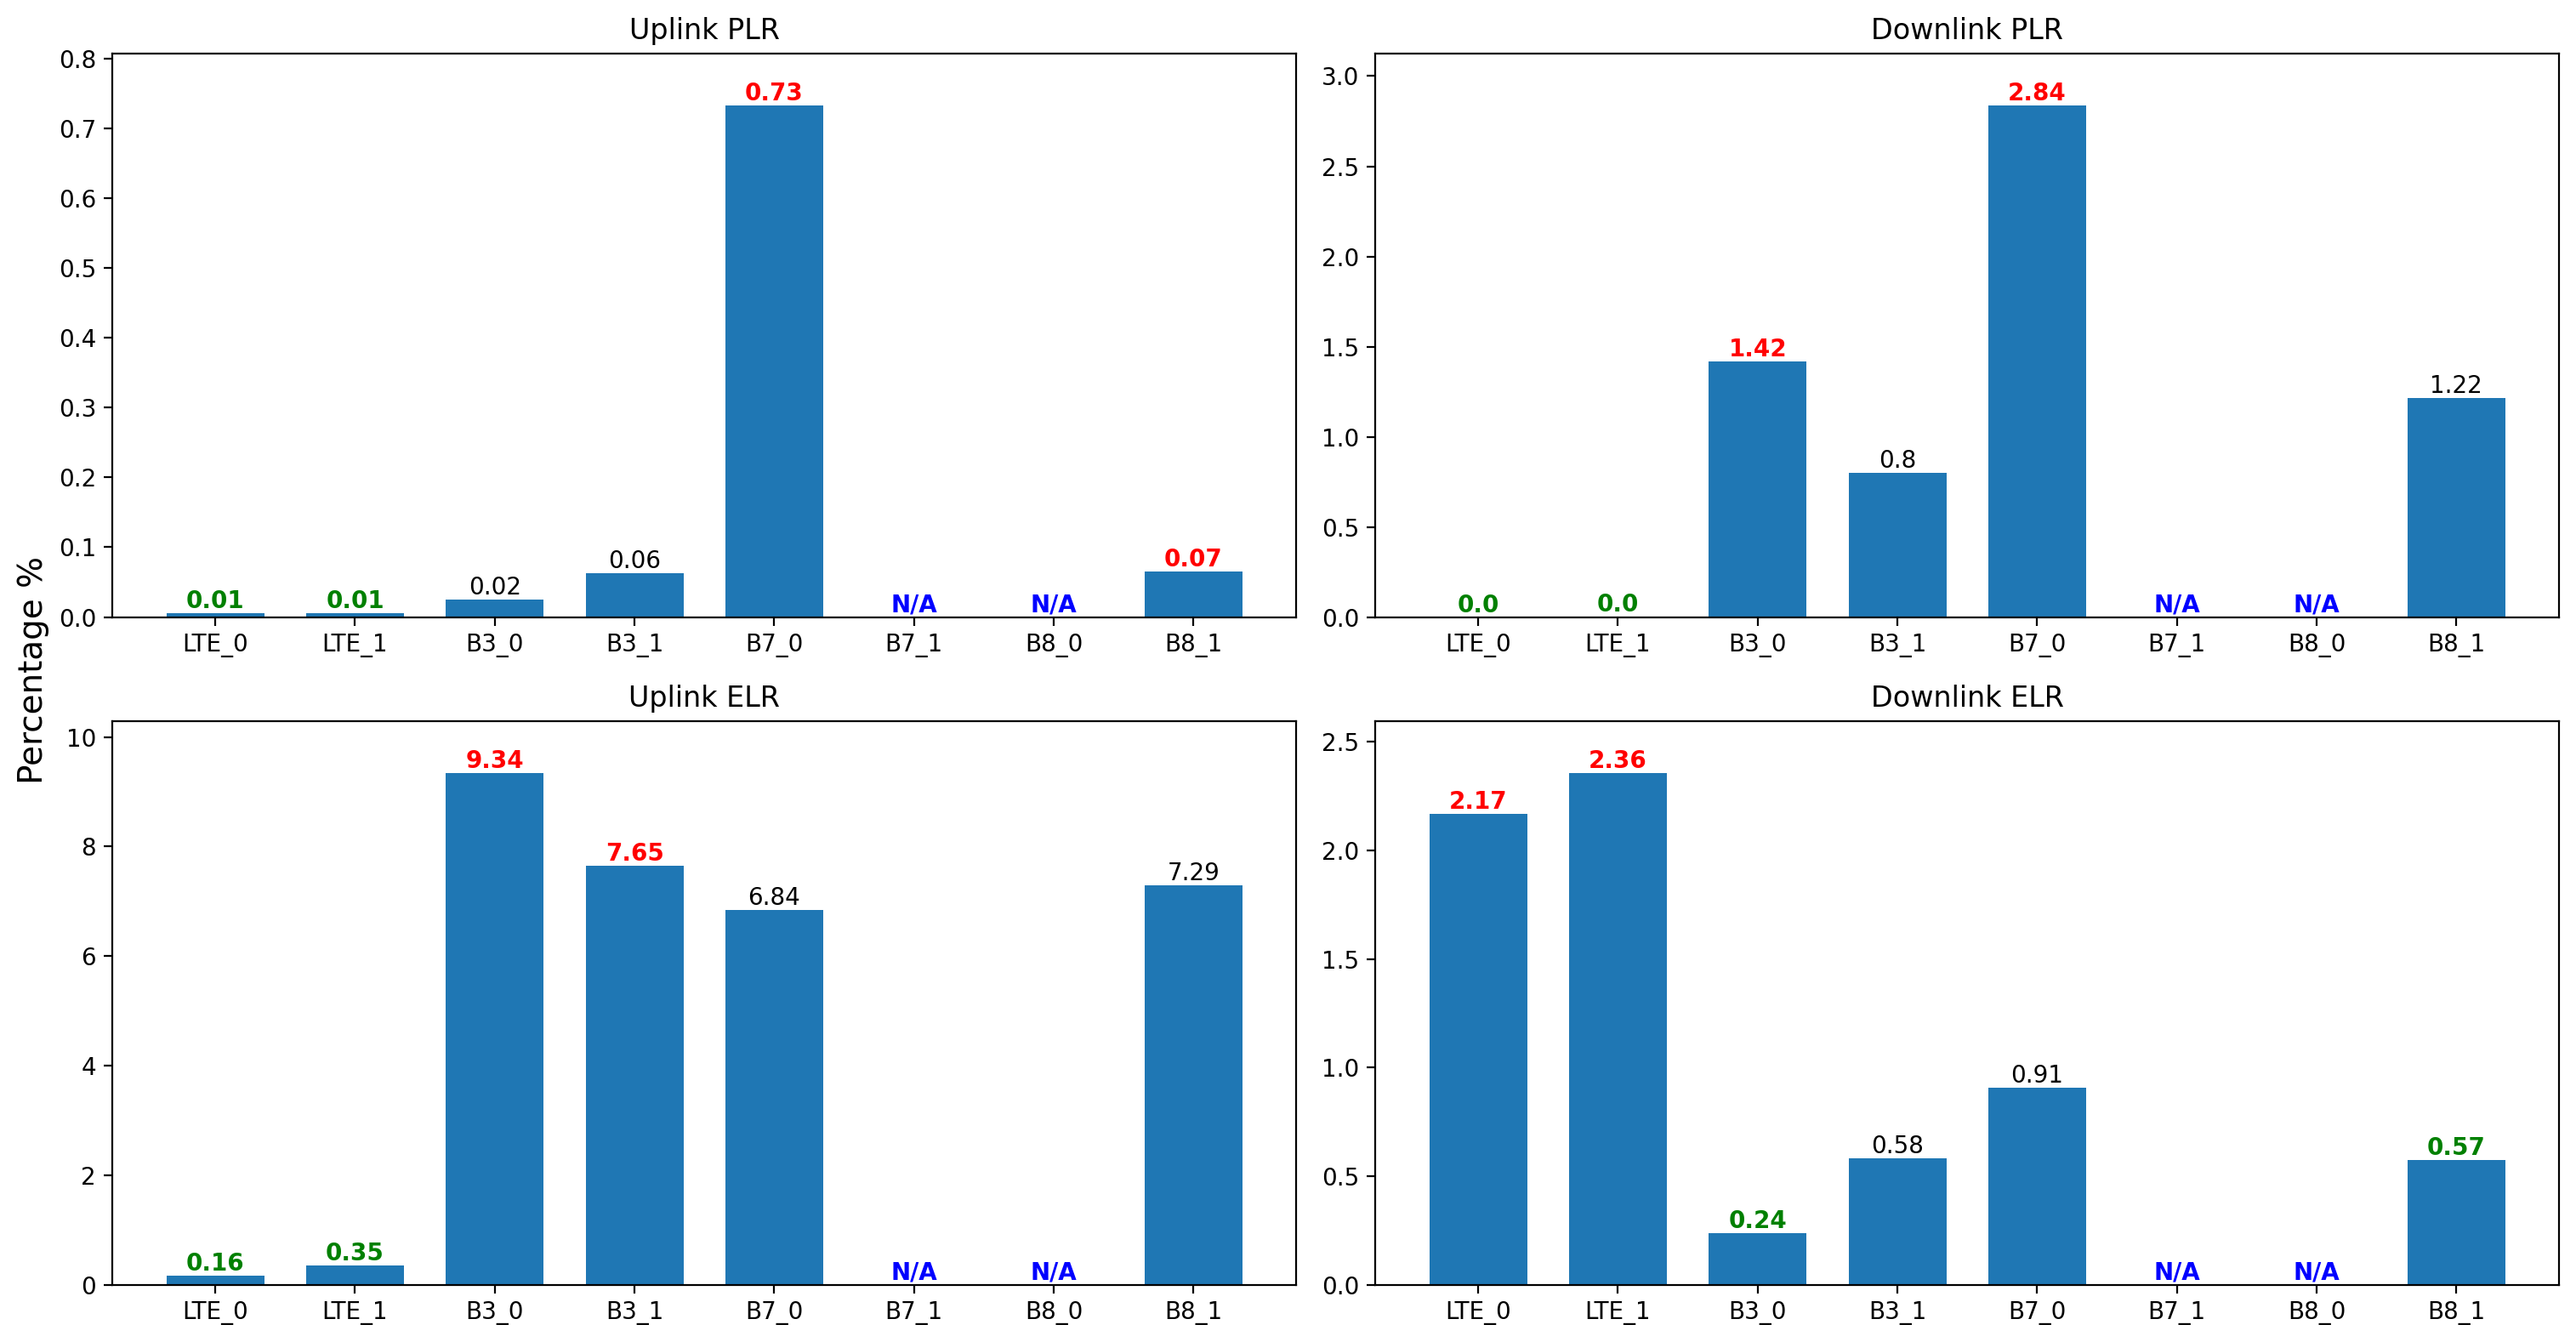

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #03


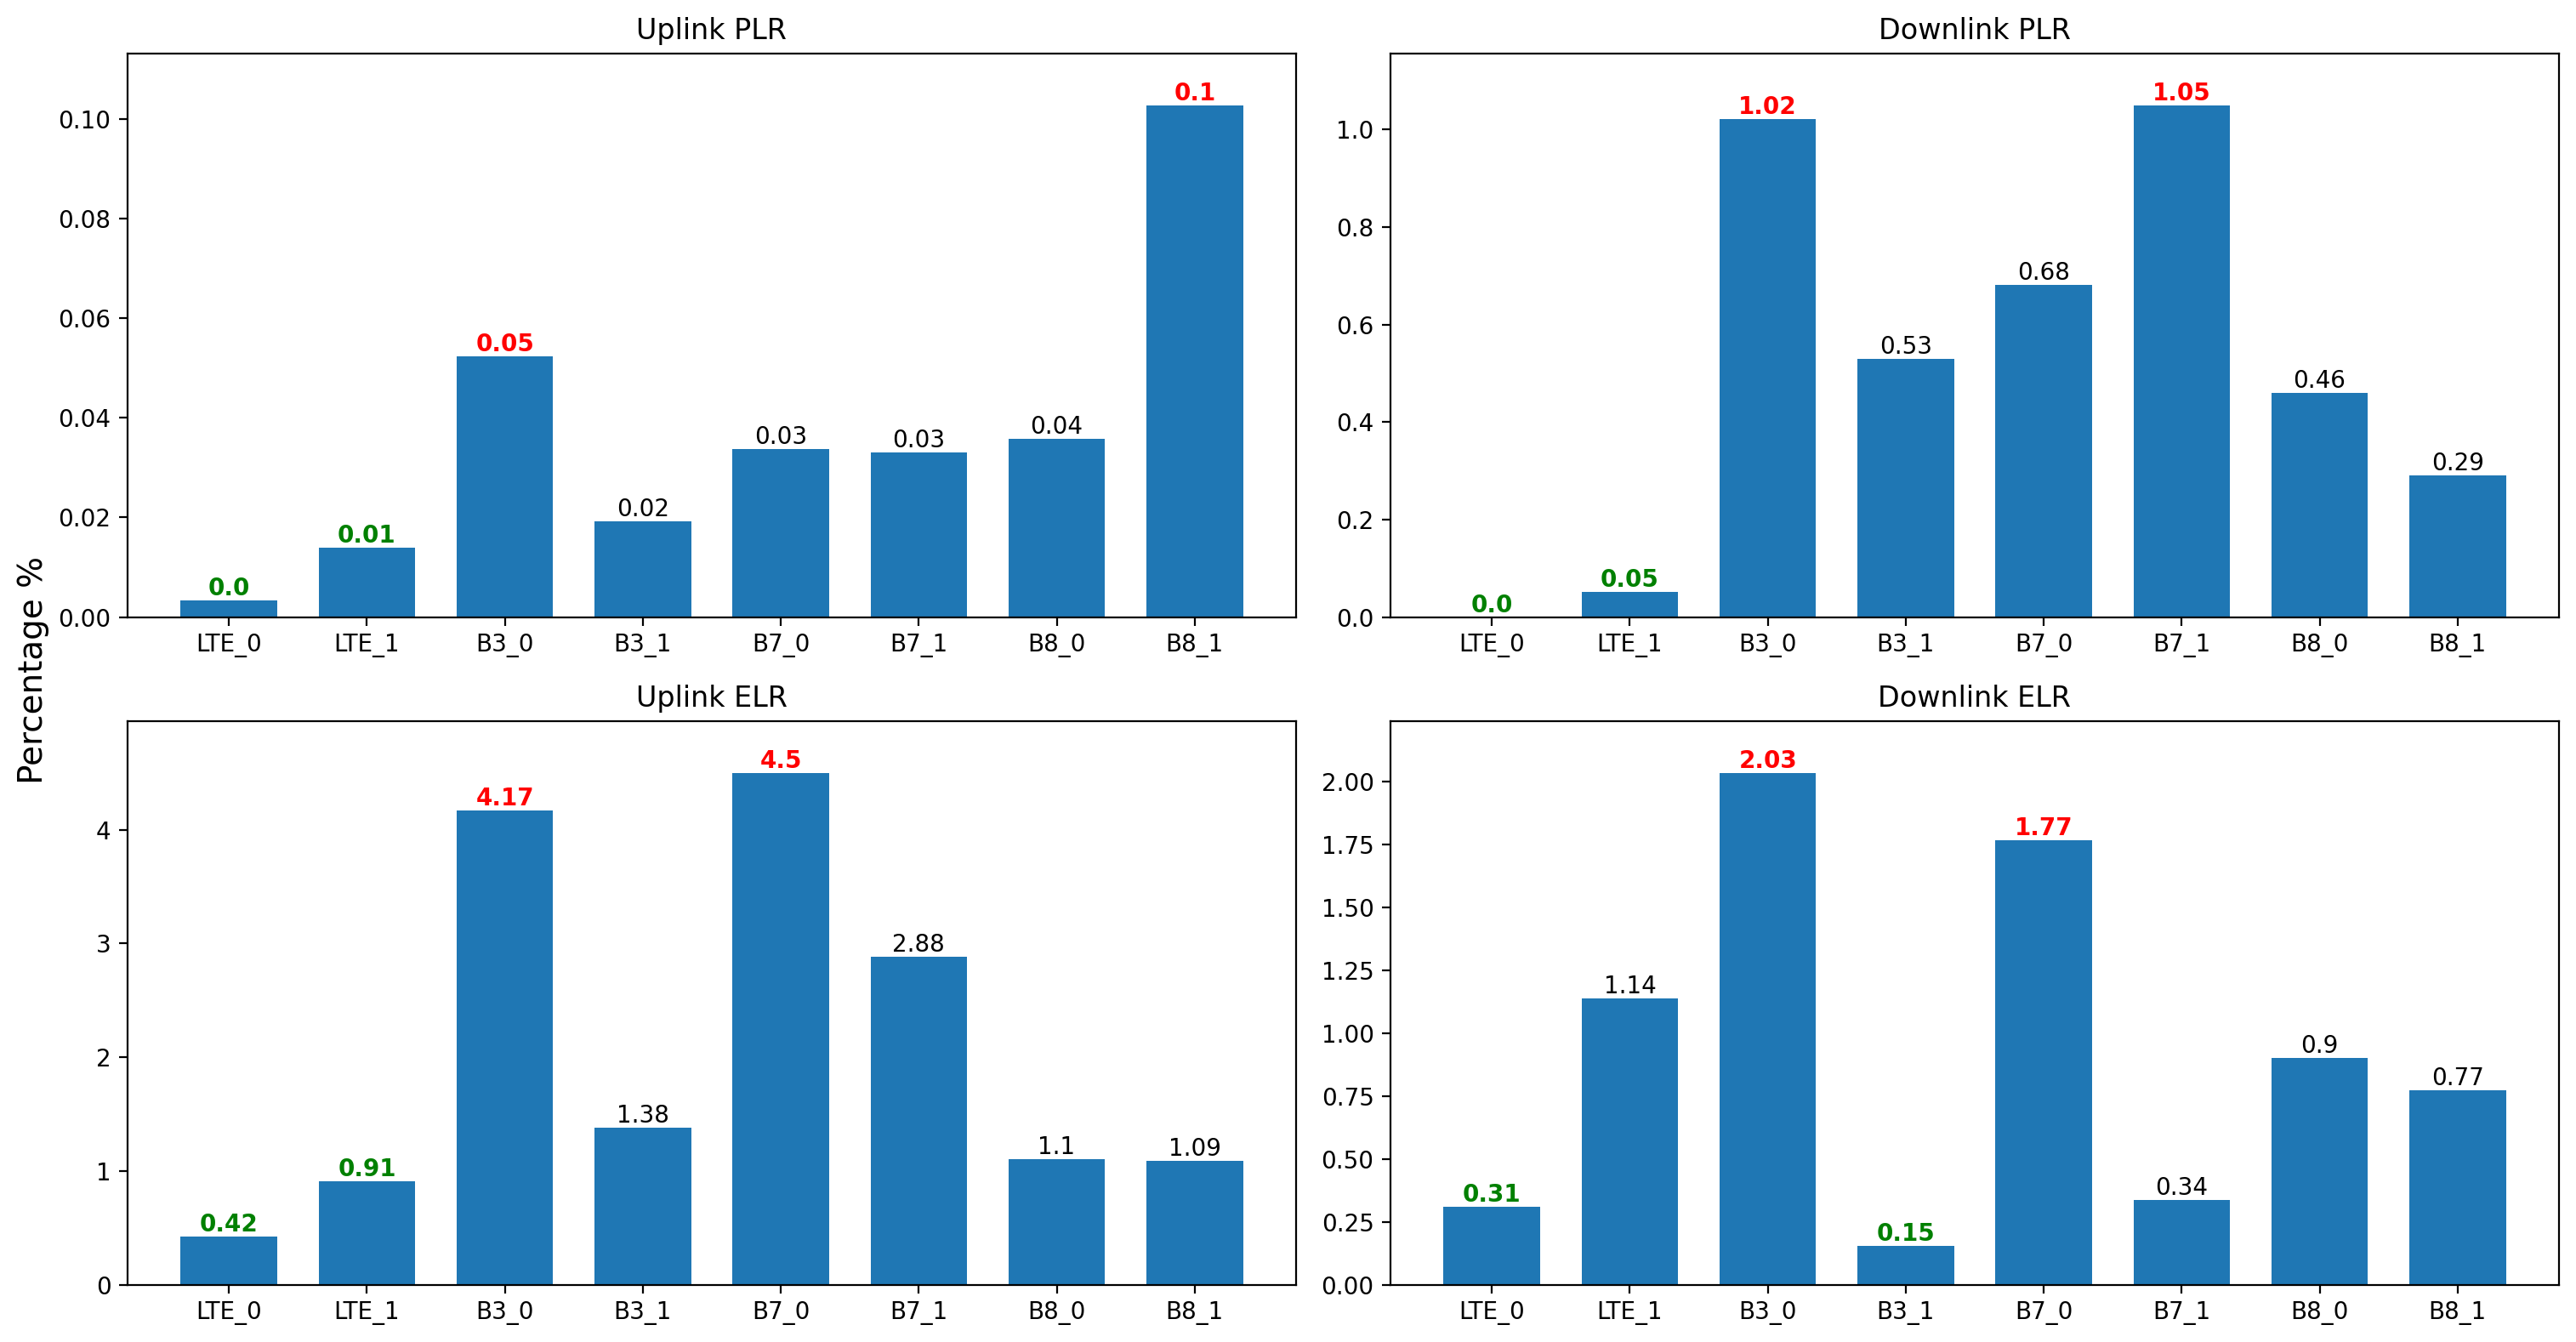

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #04


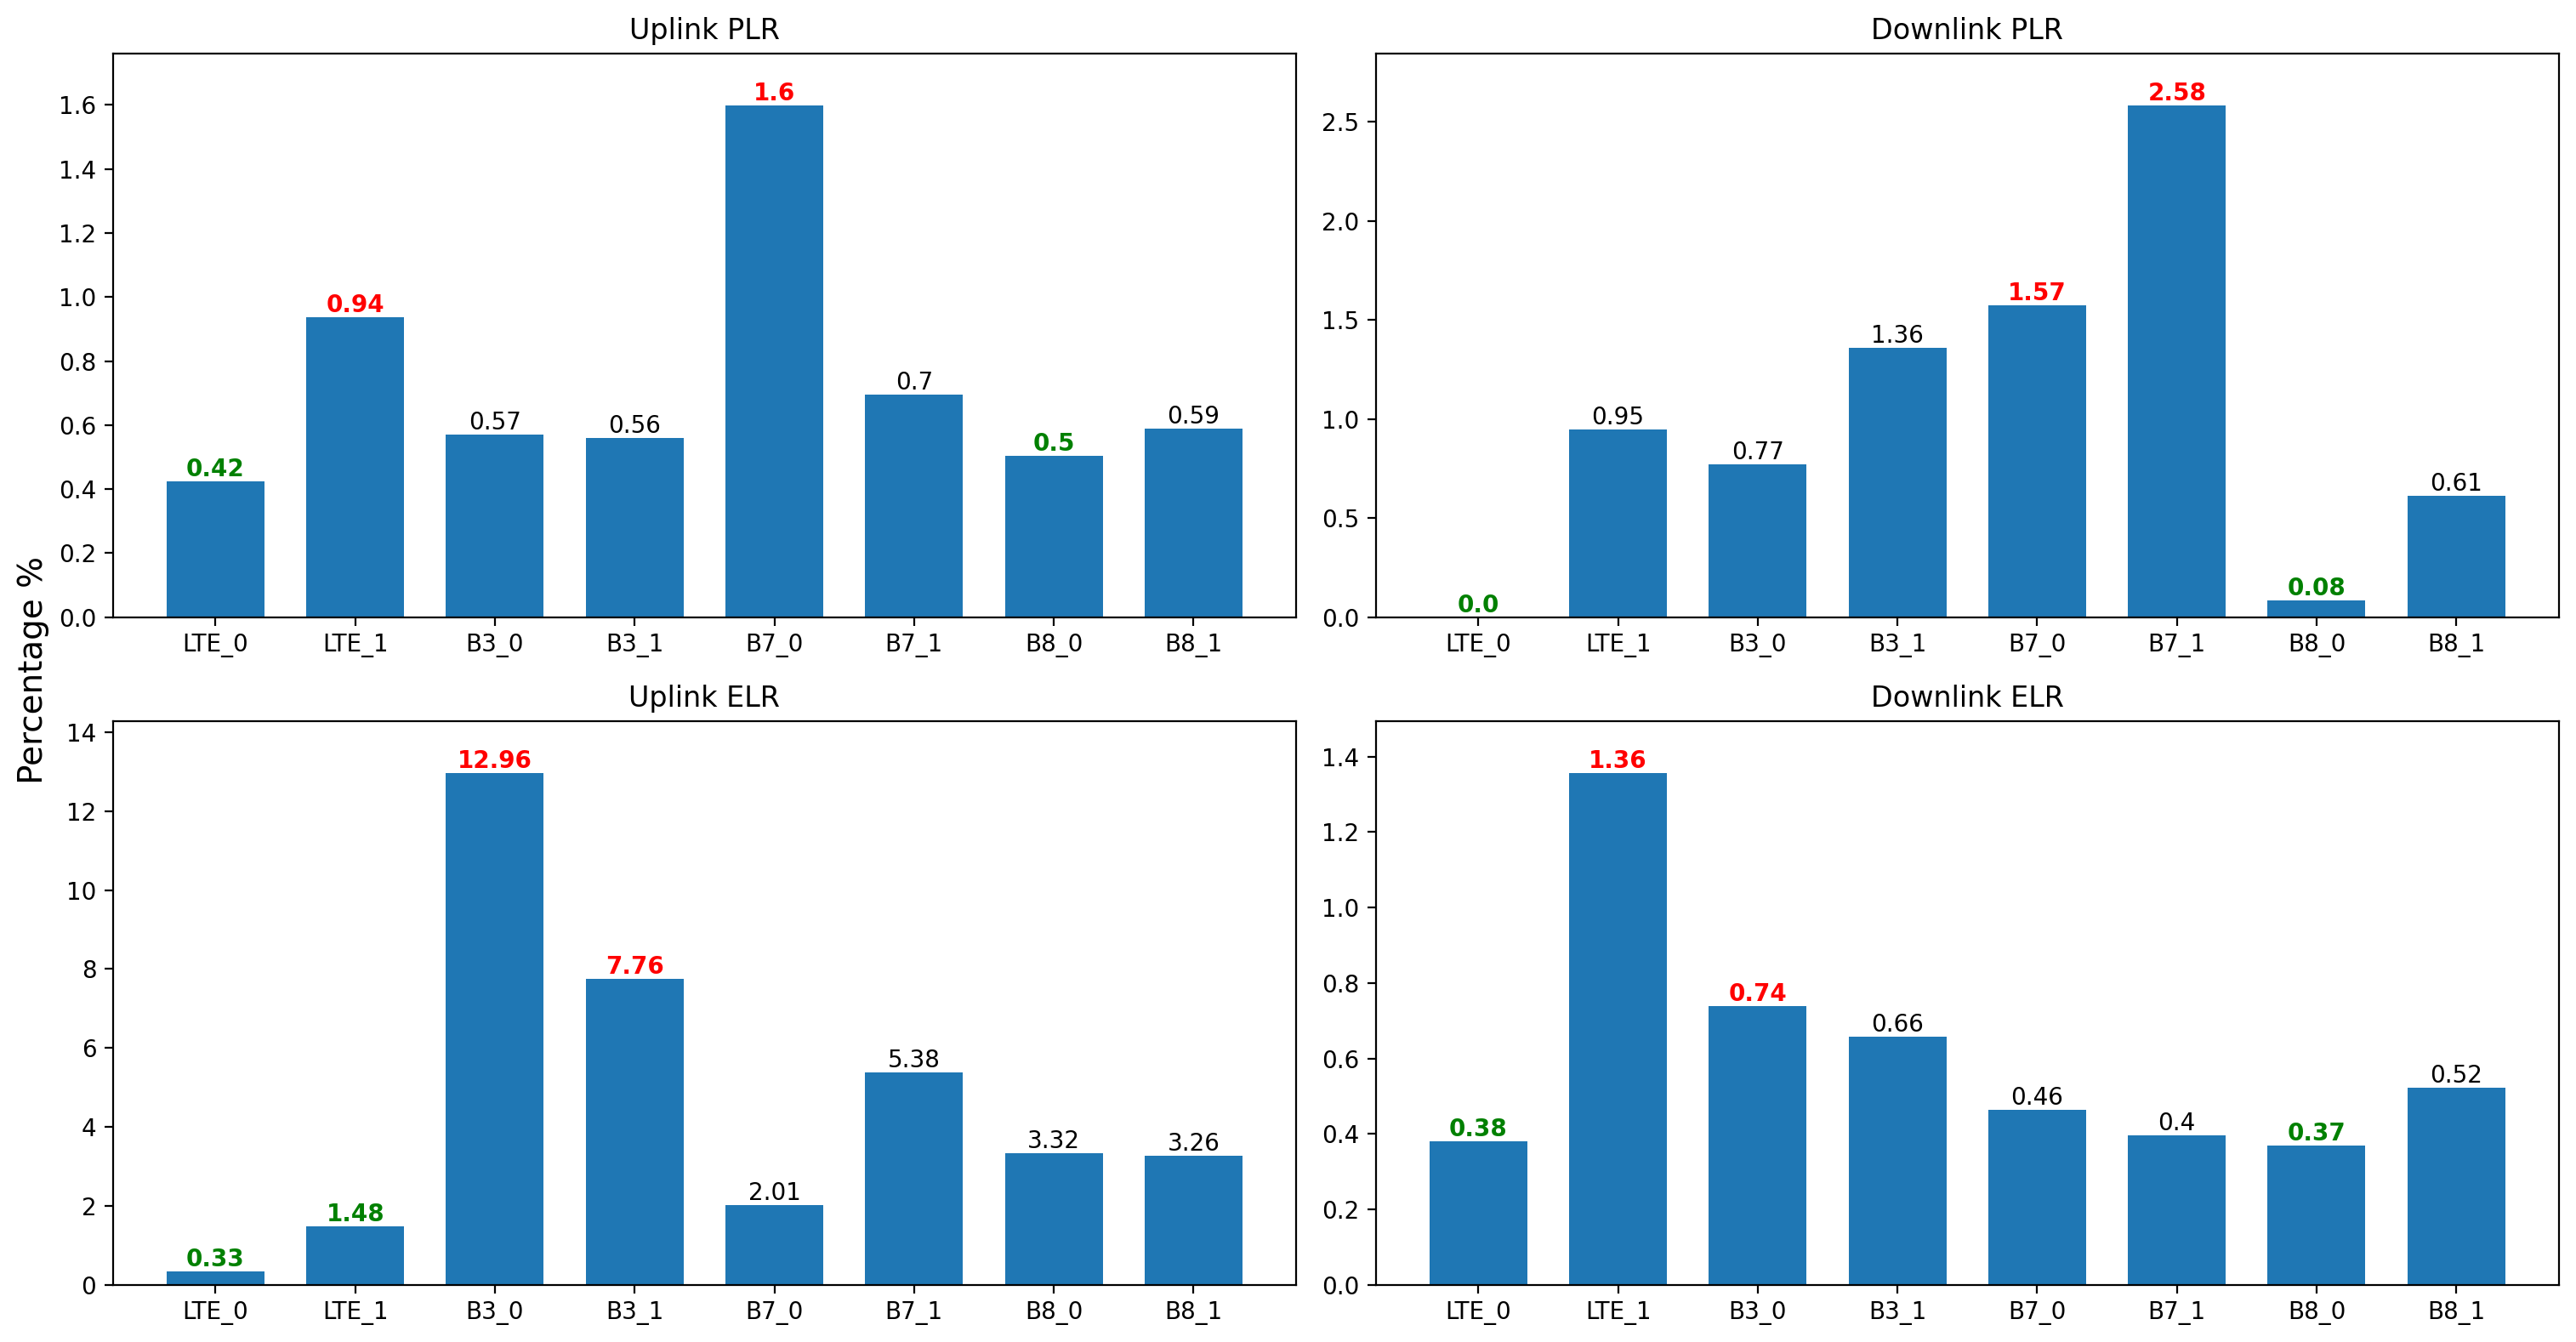

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #05


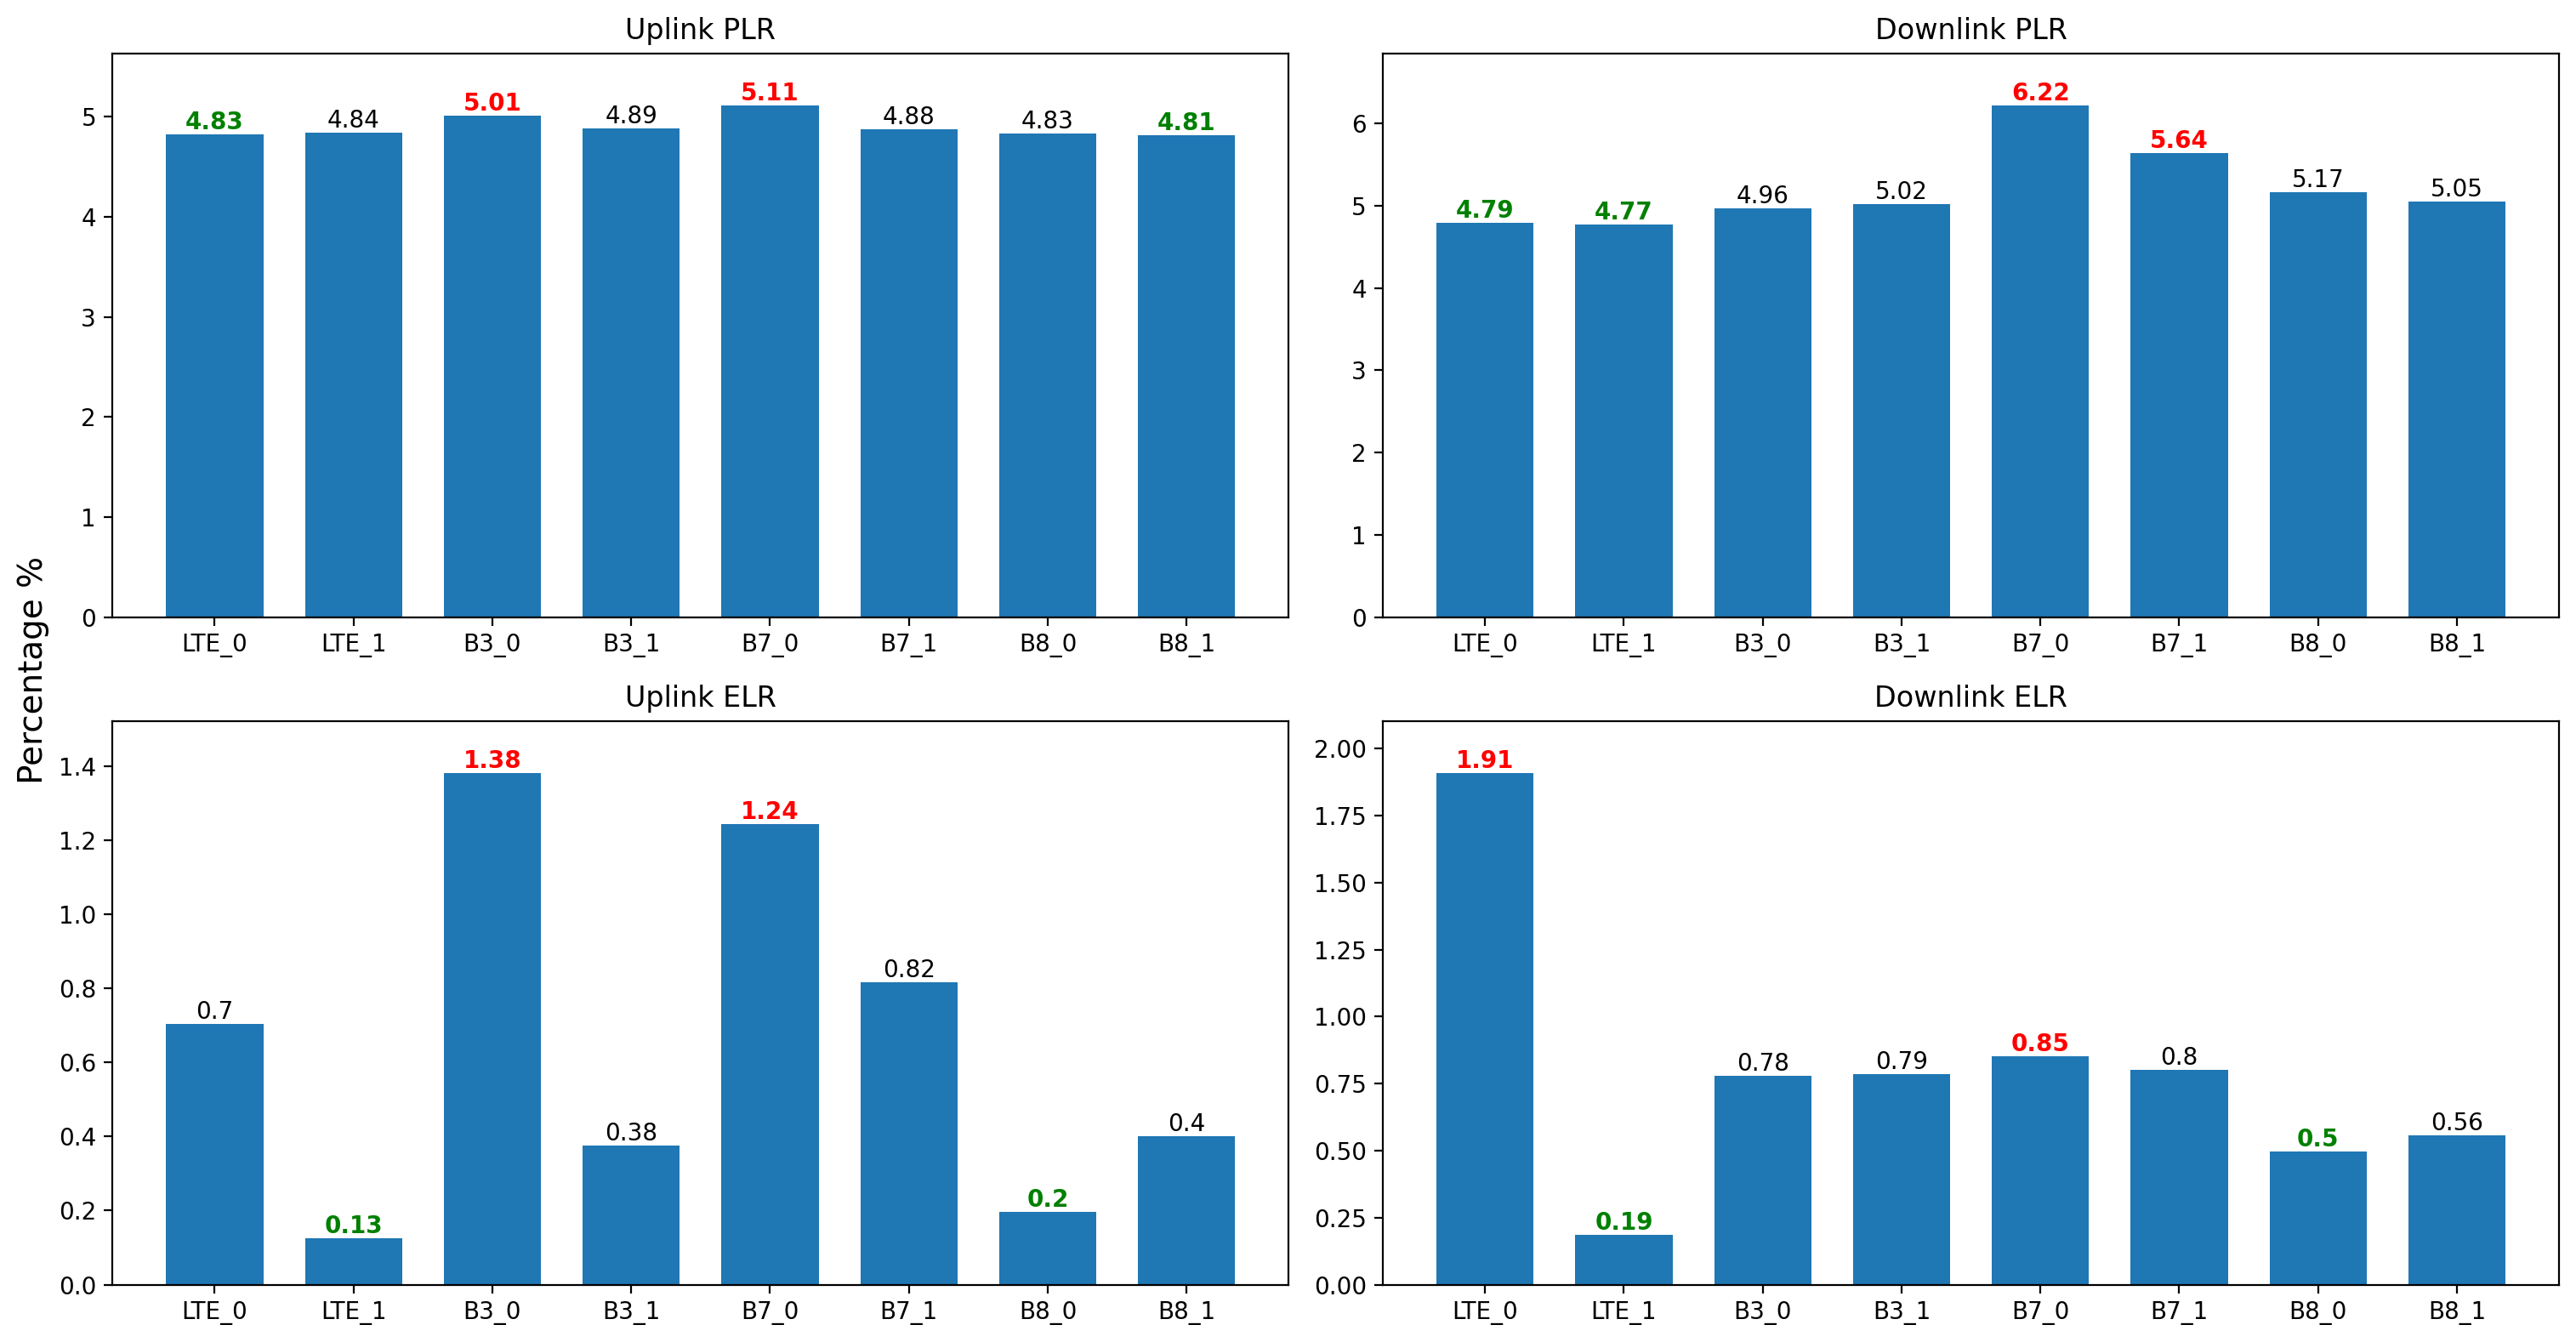

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #06


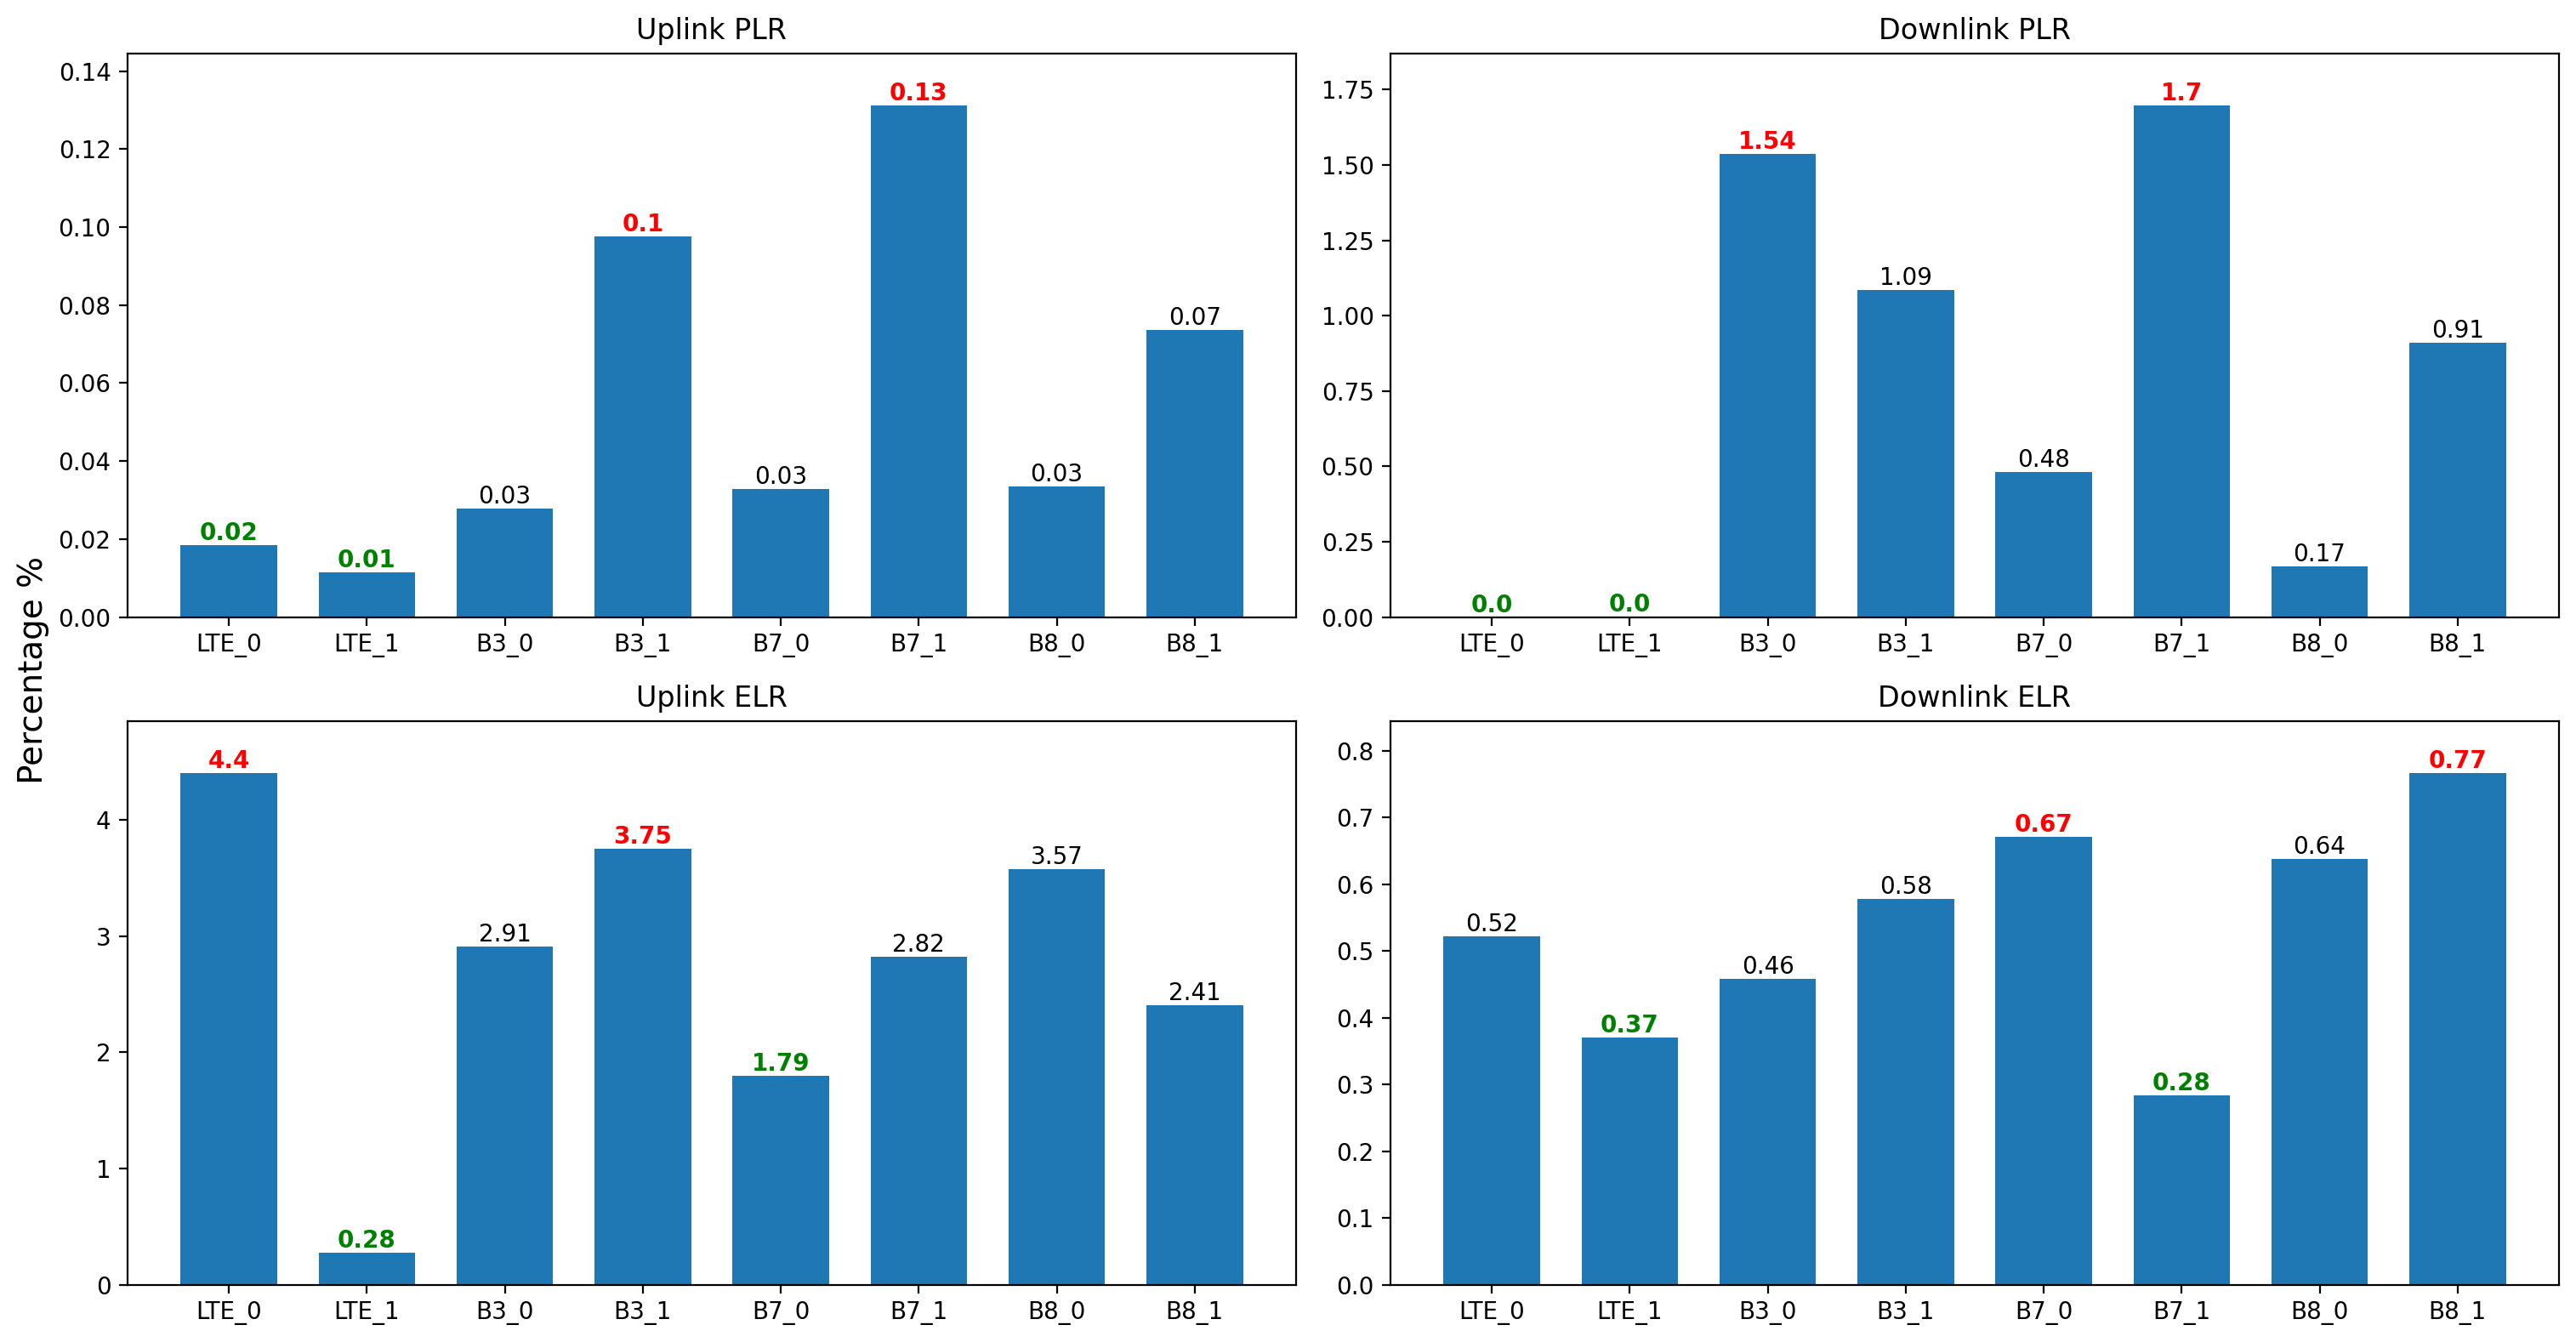

In [290]:
for expr, metrics_dict in zip(exp_list, single_metrics_list):
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR']

    ### Score & Ranking
    devices = expr.setting.keys()
    for tag, title in zip(tags, titles):
        print(f'{title} Ranking:')
        
        data_dict = {k: v[tag] for k, v in metrics_dict.items()}
        ranking_dict = {}
        score_dict = {k: [] for k in devices}
        
        for i, tr in enumerate(expr.traces):
            # print(i, tr)
            data = [v[i] for v in data_dict.values()]
            data = [num if num >= 0 else np.inf for num in data]
            na_indices = [i for i, num in enumerate(data) if np.isinf(num)]
            
            ranking = np.argsort(np.argsort(data)) + 1
            ranking[na_indices] = -1
            ranking_dict[tr] = {k: v for k, v in zip(devices, ranking)}
            
            _ranking = [num for num in ranking if num != -1]
            _max = max(_ranking); _min = min(_ranking)
            for k, rank in zip(devices, ranking):
                if rank == _min: score_dict[k].append(2)
                elif rank == _min + 1: score_dict[k].append(1)
                elif rank == _max - 1: score_dict[k].append(-1)
                elif rank == _max: score_dict[k].append(-2)
                else: score_dict[k].append(0)
        
        score = [sum(v) for v in score_dict.values()]
        ranking_dict['Score'] = {k: v for k, v in zip(devices, score)}
        
        # 降冪排列
        score_ranking = np.argsort(np.argsort(score)[::-1])[::-1] + 1
        ranking_dict['Ranking'] = {k: v for k, v in zip(devices, score_ranking)}
        
        # 轉換成兩層標頭的 DataFrame
        devices = expr.setting.keys()
        schemes = add_suffix_to_duplicate_category(expr.setting.values())
        updated_data = {k: {(dev, schm): v[dev] for dev, schm in zip(devices, schemes)}
                        for k, v in ranking_dict.items()}
        ranking_table = pd.DataFrame(updated_data).T
        
        # 將 -1 改成 pd.NA
        rows_to_check = ranking_table.index[:-2]
        ranking_table.loc[rows_to_check] = ranking_table.loc[rows_to_check].applymap(lambda x: pd.NA if x == -1 else x)
        
        expr.ranking[tag] = ranking_table
        display(ranking_table)
    
    ### 建立表格方便製圖
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
        
    ### 繪製 Bar Charts
    for idx, tr in enumerate(expr.traces):
        print(f'{expr.date} | {expr.name} -> {tr}')
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 8))
        for ax, tag, title in zip(axes.flatten(), tags, titles):
            
            # Sample data including N/A values
            categories = add_suffix_to_duplicate_category([expr.setting[k] for k in metrics_dict.keys()])
            values = [num if num != '-' else np.nan for num in metrics_table[tag].iloc[idx].tolist()[1:]]
            
            # Create a bar chart using ax.bar()
            ax.bar(categories, values, width=0.7)
            ax.set_title(title)
            
            top_n = 2
            min_values = sorted([v for v in values if not np.isnan(v)])[:top_n]
            max_values = sorted([v for v in values if not np.isnan(v)], reverse=True)[:top_n]
            
            for k, v in enumerate(values):
                if not np.isnan(v):
                    label_color = 'green' if v in min_values else ('red' if v in max_values else 'black')
                    label_fontweight = 'bold' if v in min_values else ('bold' if v in max_values else 'normal')
                    
                    ax.text(k, v, str(round(v, 2)), ha='center', va='bottom', color=label_color, fontweight=label_fontweight)

                if np.isnan(v):
                    ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
            
            ax.set_ylim(top=ax.get_ylim()[1]*1.05)
        
        fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
    
        plt.tight_layout()
        plt.show()

In [245]:
import pandas as pd
import numpy as np

# 假設有一個 ranking table
data = {'Tr1': {'Dev1': 2, 'Dev2': 1, 'Score': 3, 'Ranking': 2},
        'Tr2': {'Dev1': -1, 'Dev2': 3, 'Score': -1, 'Ranking': -1},
        'Tr3': {'Dev1': 1, 'Dev2': 2, 'Score': -1, 'Ranking': 3}}

ranking_table = pd.DataFrame.from_dict(data, orient='index')

# 檢查除了最後兩列的每一列，將 -1 改成 pd.NA
rows_to_check = ranking_table.index[:-1]
ranking_table.loc[rows_to_check] = ranking_table.loc[rows_to_check].applymap(lambda x: pd.NA if x == -1 else x)

print(ranking_table)


     Dev1  Dev2 Score Ranking
Tr1     2     1     3       2
Tr2  <NA>     3  <NA>    <NA>
Tr3     1     2    -1       3


# Dual Radio

In [305]:
def calc_dual_loss_excl_rate(filepath1, filepath2):
    
    if not (os.path.isfile(filepath1) and os.path.isfile(filepath2)):
        return -1, -1
    
    df1 = pd.read_pickle(filepath1) if filepath1.endswith('.pkl') else pd.read_csv(filepath1)
    df2 = pd.read_pickle(filepath2) if filepath2.endswith('.pkl') else pd.read_csv(filepath2)

    st_seq = max([df1['seq'].array[0], df2['seq'].array[0]])
    ed_seq = min([df1['seq'].array[-1], df2['seq'].array[-1]])
    df1 = df1[(df1['seq'] >= st_seq) & (df1['seq'] <= ed_seq)].reset_index(drop=True)
    df2 = df2[(df2['seq'] >= st_seq) & (df2['seq'] <= ed_seq)].reset_index(drop=True)
    
    # Calculate system PLR & ELR
    loss_condition = df1['lost'] & df2['lost']
    system_loss_rate = loss_condition.mean() * 100

    excl_threshold = 100e-3
    excl_condition = (df1[~loss_condition]['latency'] > excl_threshold) & (df2[~loss_condition]['latency'] > excl_threshold)
    system_excl_rate = excl_condition.mean() * 100
    
    return system_loss_rate, system_excl_rate

# GLOBAL VARIABLE !!!
dual_metrics_list = []

for expr in exp_list:
    metrics_dict = {}
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    
    ### Single Radio
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    for (dev, ul_paths), dl_paths, schm in tqdm(zip(expr.ul_paths.items(), expr.dl_paths.values(), schemes), ncols=1000):
        # print(dev)
        
        metrics_dict[schm] = {}
        ul_loss_rates, ul_excl_rates = [], []
        dl_loss_rates, dl_excl_rates = [], []
        
        for ul_path, dl_path in zip(ul_paths, dl_paths):
            ul_loss_rate, ul_excl_rate = calc_loss_excl_rate(ul_path)
            dl_loss_rate, dl_excl_rate = calc_loss_excl_rate(dl_path)
            
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
            
        metrics_dict[schm]['ul_loss'] = ul_loss_rates
        metrics_dict[schm]['ul_excl'] = ul_excl_rates
        metrics_dict[schm]['dl_loss'] = dl_loss_rates
        metrics_dict[schm]['dl_excl'] = dl_excl_rates
    
    ### Dual Radio
    devices = list(it.combinations(expr.setting.keys(), 2))
    schemes = list(it.combinations(add_suffix_to_duplicate_category(expr.setting.values()), 2))
    for (dev1, dev2), schm in tqdm(zip(devices, schemes), ncols=1000):
        # print(dev1, dev2)
        schm = '+'.join(schm)
        
        ul_paths1 = expr.ul_paths[dev1]; ul_paths2 = expr.ul_paths[dev2]
        dl_paths1 = expr.dl_paths[dev1]; dl_paths2 = expr.dl_paths[dev2]
        
        metrics_dict[schm] = {}
        ul_loss_rates, ul_excl_rates = [], []
        dl_loss_rates, dl_excl_rates = [], []
        
        for ul_path1, ul_path2, dl_path1, dl_path2 in zip(ul_paths1, ul_paths2, dl_paths1, dl_paths2):
            ul_loss_rate, ul_excl_rate = calc_dual_loss_excl_rate(ul_path1, ul_path2)
            dl_loss_rate, dl_excl_rate = calc_dual_loss_excl_rate(dl_path1, dl_path2)
            
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
        
        metrics_dict[schm]['ul_loss'] = ul_loss_rates
        metrics_dict[schm]['ul_excl'] = ul_excl_rates
        metrics_dict[schm]['dl_loss'] = dl_loss_rates
        metrics_dict[schm]['dl_excl'] = dl_excl_rates
    
    dual_metrics_list.append(metrics_dict)
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR']
    
    ### Display Table
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    ### Single Ranking
    print('Single Radio Ranking')
    display(expr.metadata)
    
    ### Dual Ranking
    size = len(expr.setting)
    expr.metadata_dual = None
    
    for tag in ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']:
        data = [np.mean([num for num in v[tag] if num >= 0]) for v in metrics_dict.values()][size:]
        ranking = np.argsort(np.argsort(data)) + 1

        if expr.metadata_dual is None:
            schemes = metrics_table[tag].columns[1:size+1]
            schm_list = metrics_table[tag].columns[size+1:]
            
            traces = []
            traces_dict = {k: v.split(', ') for k, v in zip(schemes, expr.dev_traces.values())}
            for schms in schm_list:
                schm1 = schms.split('+')[0]; schm2 = schms.split('+')[1]
                traces.append(', '.join(sorted(list(set(traces_dict[schm1]) & set(traces_dict[schm2])))))
            
            expr.metadata_dual = pd.DataFrame({'Schm': schm_list, 'Traces': traces})
            # ... (生成 expr.metadata_dual)
        
        expr.metadata_dual[f'avg_{tag}'] = data
        expr.metadata_dual[f'{tag}_rank'] = ranking

    print('Dual Radio Ranking:')
    display(expr.metadata_dual)

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Single Radio Ranking


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Dual Radio Ranking:


Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   All_0+All_1  #01, #02, #03, #04     0.017132            25     0.009754   
1    All_0+B3_0  #01, #02, #03, #04     0.009782            11     0.100379   
2    All_0+B3_1  #01, #02, #03, #04     0.009306             9     0.109208   
3    All_0+B7_0  #01, #02, #03, #04     0.011298            15     0.212467   
4    All_0+B7_1  #01, #02, #03, #04     0.014524            22     0.156036   
5    All_0+B8_0  #01, #02, #03, #04     0.016483            24     0.008374   
6    All_0+B8_1  #01, #02, #03, #04     0.009144             7     0.017000   
7    All_1+B3_0  #01, #02, #03, #04     0.014850            23     0.023164   
8    All_1+B3_1  #01, #02, #03, #04     0.013385            19     0.022727   
9    All_1+B7_0  #01, #02, #03, #04     0.012074            16     0.082244   
10   All_1+B7_1  #01, #02, #03, #04     0.012567            17     0.063534   
11   All_1+B8_0  #01, #02, #03, #04     0.022538            27     0.066177   
12   All_1+B8_1  #01, #02, #03, #04     0.009144             8     0.003086   
13    B3_0+B3_1  #01, #02, #03, #04     0.011085            14     0.154154   
14    B3_0+B7_0  #01, #02, #03, #04     0.010279            12     0.131356   
15    B3_0+B7_1  #01, #02, #03, #04     0.082872            28     0.091406   
16    B3_0+B8_0  #01, #02, #03, #04     0.020405            26     0.004052   
17    B3_0+B8_1  #01, #02, #03, #04     0.006390             1     0.037390   
18    B3_1+B7_0  #01, #02, #03, #04     0.007995             2     0.036802   
19    B3_1+B7_1  #01, #02, #03, #04     0.014228            20     0.031035   
20    B3_1+B8_0  #01, #02, #03, #04     0.014392            21     0.003700   
21    B3_1+B8_1  #01, #02, #03, #04     0.008164             3     0.037212   
22    B7_0+B7_1  #01, #02, #03, #04     0.008537             6     0.150562   
23    B7_0+B8_0  #01, #02, #03, #04     0.010932            13     0.002643   
24    B7_0+B8_1  #01, #02, #03, #04     0.008349             4     0.026321   
25    B7_1+B8_0  #01, #02, #03, #04     0.013230            18     0.048492   
26    B7_1+B8_1  #01, #02, #03, #04     0.009516            10     0.038884   
27    B8_0+B8_1  #01, #02, #03, #04     0.008401             5     0.069271   

    dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0              6     1.060746             3     0.251097            27  
1             22     1.333517            11     0.058754             3  
2             23     1.327328            10     0.125105            10  
3             28     1.322553             9     0.199198            23  
4             27     1.364544            12     0.195594            22  
5              5     1.321083             8     0.126338            11  
6              7     0.764731             1     0.208866            25  
7              9     1.438489            15     0.067973             4  
8              8     1.511727            16     0.191392            19  
9             20     1.410283            13     0.205839            24  
10            17     1.598695            17     0.296444            28  
11            18     1.601976            18     0.118767             9  
12             2     1.039685             2     0.185483            18  
13            26     2.864911            27     0.082260             6  
14            24     2.470136            24     0.070277             5  
15            21     2.169666            21     0.147499            13  
16             4     4.437835            28     0.050003             1  
17            14     1.318347             7     0.107196             8  
18            12     2.339875            23     0.129240            12  
19            11     2.172002            22     0.193380            21  
20             3     2.755402            26     0.057578             2  
21            13     1.312336             6     0.097666             7  
22            25     2.104571           

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Single Radio Ranking


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             5   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             3   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             4   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7       #01, #03, #04, #05, #06     1.278359             7   
6   sm06   B8       #01, #03, #04, #05, #06     1.185786             6   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             2   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             6     0.831878   
5     2.532447             8     2.604340             5     0.461063   
6     1.190465             3     1.640298             3     0.531022   
7     1.476035             4     2.474258             4     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             1  
6             3  
7             4

Dual Radio Ranking:


Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   LTE_0+LTE_1  #01, #02, #03, #04, #05, #06     0.799353            11   
1    LTE_0+B3_0  #01, #02, #03, #04, #05, #06     0.792909             3   
2    LTE_0+B3_1  #01, #02, #03, #04, #05, #06     0.793947             5   
3    LTE_0+B7_0  #01, #02, #03, #04, #05, #06     0.792712             2   
4    LTE_0+B7_1       #01, #03, #04, #05, #06     0.951510            20   
5    LTE_0+B8_0       #01, #03, #04, #05, #06     0.949237            16   
6    LTE_0+B8_1  #01, #02, #03, #04, #05, #06     0.798440            10   
7    LTE_1+B3_0  #01, #02, #03, #04, #05, #06     0.795283             8   
8    LTE_1+B3_1  #01, #02, #03, #04, #05, #06     0.793711             4   
9    LTE_1+B7_0  #01, #02, #03, #04, #05, #06     0.808278            13   
10   LTE_1+B7_1       #01, #03, #04, #05, #06     0.955717            26   
11   LTE_1+B8_0       #01, #03, #04, #05, #06     0.955204            25   
12   LTE_1+B8_1  #01, #02, #03, #04, #05, #06     0.798366             9   
13    B3_0+B3_1  #01, #02, #03, #04, #05, #06     0.801080            12   
14    B3_0+B7_0  #01, #02, #03, #04, #05, #06     0.811982            15   
15    B3_0+B7_1       #01, #03, #04, #05, #06     0.957650            27   
16    B3_0+B8_0       #01, #03, #04, #05, #06     0.950611            18   
17    B3_0+B8_1  #01, #02, #03, #04, #05, #06     0.794188             7   
18    B3_1+B7_0  #01, #02, #03, #04, #05, #06     0.794039             6   
19    B3_1+B7_1       #01, #03, #04, #05, #06     0.953878            23   
20    B3_1+B8_0       #01, #03, #04, #05, #06     0.951018            19   
21    B3_1+B8_1  #01, #02, #03, #04, #05, #06     0.792049             1   
22    B7_0+B7_1       #01, #03, #04, #05, #06     0.989299            28   
23    B7_0+B8_0       #01, #03, #04, #05, #06     0.954692            24   
24    B7_0+B8_1  #01, #02, #03, #04, #05, #06     0.811029            14   
25    B7_1+B8_0       #01, #03, #04, #05, #06     0.953738            22   
26    B7_1+B8_1       #01, #03, #04, #05, #06     0.949414            17   
27    B8_0+B8_1       #01, #03, #04, #05, #06     0.952265            21   

    avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0      0.792646             1     0.028843             3     0.294806   
1      0.792950             3     0.039773             5     0.044183   
2      0.792854             2     0.048648             6     0.046718   
3      0.798591             5     0.082327             7     0.227947   
4      0.951220            10     0.024165             2     0.142134   
5      0.951470            11     0.032411             4     0.016132   
6      0.795002             4     0.022611             1     0.068341   
7      0.875096             6     0.197426            12     0.023538   
8      0.893729             8     0.187152            11     0.014780   
9      0.900598             9     0.170452            10     0.095096   
10     1.084260            23     0.230328            13     0.073510   
11     0.953761            12     0.112465             8     0.023326   
12     0.887442             7     0.131847             9     0.020412   
13     1.086348            24     2.813977            28     0.135948   
14     0.998914            19     1.823793            27     0.291474   
15     1.175339            25     1.384540            22     0.087777   
16     0.978195            15     1.137209            19     0.083050   
17     1.036675            21     1.556509            25     0.062557   
18     0.982675            17     1.546468            24     0.118466   
19     1.218258            26     1.538249            23     0.094161   
20     0.983505            18     1.160644            20     0.125751   
21     1.024718            20     1.689115            26     0.107599   
22     1.320688            28     0.729845            15     0.083088   
23     0.954165            13     0.527476            

## Heatmap

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   All_0+All_1  #01, #02, #03, #04     0.017132            25     0.009754   
1    All_0+B3_0  #01, #02, #03, #04     0.009782            11     0.100379   
2    All_0+B3_1  #01, #02, #03, #04     0.009306             9     0.109208   
3    All_0+B7_0  #01, #02, #03, #04     0.011298            15     0.212467   
4    All_0+B7_1  #01, #02, #03, #04     0.014524            22     0.156036   
5    All_0+B8_0  #01, #02, #03, #04     0.016483            24     0.008374   
6    All_0+B8_1  #01, #02, #03, #04     0.009144             7     0.017000   
7    All_1+B3_0  #01, #02, #03, #04     0.014850            23     0.023164   
8    All_1+B3_1  #01, #02, #03, #04     0.013385            19     0.022727   
9    All_1+B7_0  #01, #02, #03, #04     0.012074            16     0.082244   
10   All_1+B7_1  #01, #02, #03, #04     0.012567            17     0.063534   
11   All_1+B8_0  #01, #02, #03, #04     0.022538            27     0.066177   
12   All_1+B8_1  #01, #02, #03, #04     0.009144             8     0.003086   
13    B3_0+B3_1  #01, #02, #03, #04     0.011085            14     0.154154   
14    B3_0+B7_0  #01, #02, #03, #04     0.010279            12     0.131356   
15    B3_0+B7_1  #01, #02, #03, #04     0.082872            28     0.091406   
16    B3_0+B8_0  #01, #02, #03, #04     0.020405            26     0.004052   
17    B3_0+B8_1  #01, #02, #03, #04     0.006390             1     0.037390   
18    B3_1+B7_0  #01, #02, #03, #04     0.007995             2     0.036802   
19    B3_1+B7_1  #01, #02, #03, #04     0.014228            20     0.031035   
20    B3_1+B8_0  #01, #02, #03, #04     0.014392            21     0.003700   
21    B3_1+B8_1  #01, #02, #03, #04     0.008164             3     0.037212   
22    B7_0+B7_1  #01, #02, #03, #04     0.008537             6     0.150562   
23    B7_0+B8_0  #01, #02, #03, #04     0.010932            13     0.002643   
24    B7_0+B8_1  #01, #02, #03, #04     0.008349             4     0.026321   
25    B7_1+B8_0  #01, #02, #03, #04     0.013230            18     0.048492   
26    B7_1+B8_1  #01, #02, #03, #04     0.009516            10     0.038884   
27    B8_0+B8_1  #01, #02, #03, #04     0.008401             5     0.069271   

    dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0              6     1.060746             3     0.251097            27  
1             22     1.333517            11     0.058754             3  
2             23     1.327328            10     0.125105            10  
3             28     1.322553             9     0.199198            23  
4             27     1.364544            12     0.195594            22  
5              5     1.321083             8     0.126338            11  
6              7     0.764731             1     0.208866            25  
7              9     1.438489            15     0.067973             4  
8              8     1.511727            16     0.191392            19  
9             20     1.410283            13     0.205839            24  
10            17     1.598695            17     0.296444            28  
11            18     1.601976            18     0.118767             9  
12             2     1.039685             2     0.185483            18  
13            26     2.864911            27     0.082260             6  
14            24     2.470136            24     0.070277             5  
15            21     2.169666            21     0.147499            13  
16             4     4.437835            28     0.050003             1  
17            14     1.318347             7     0.107196             8  
18            12     2.339875            23     0.129240            12  
19            11     2.172002            22     0.193380            21  
20             3     2.755402            26     0.057578             2  
21            13     1.312336             6     0.097666             7  
22            25     2.104571           

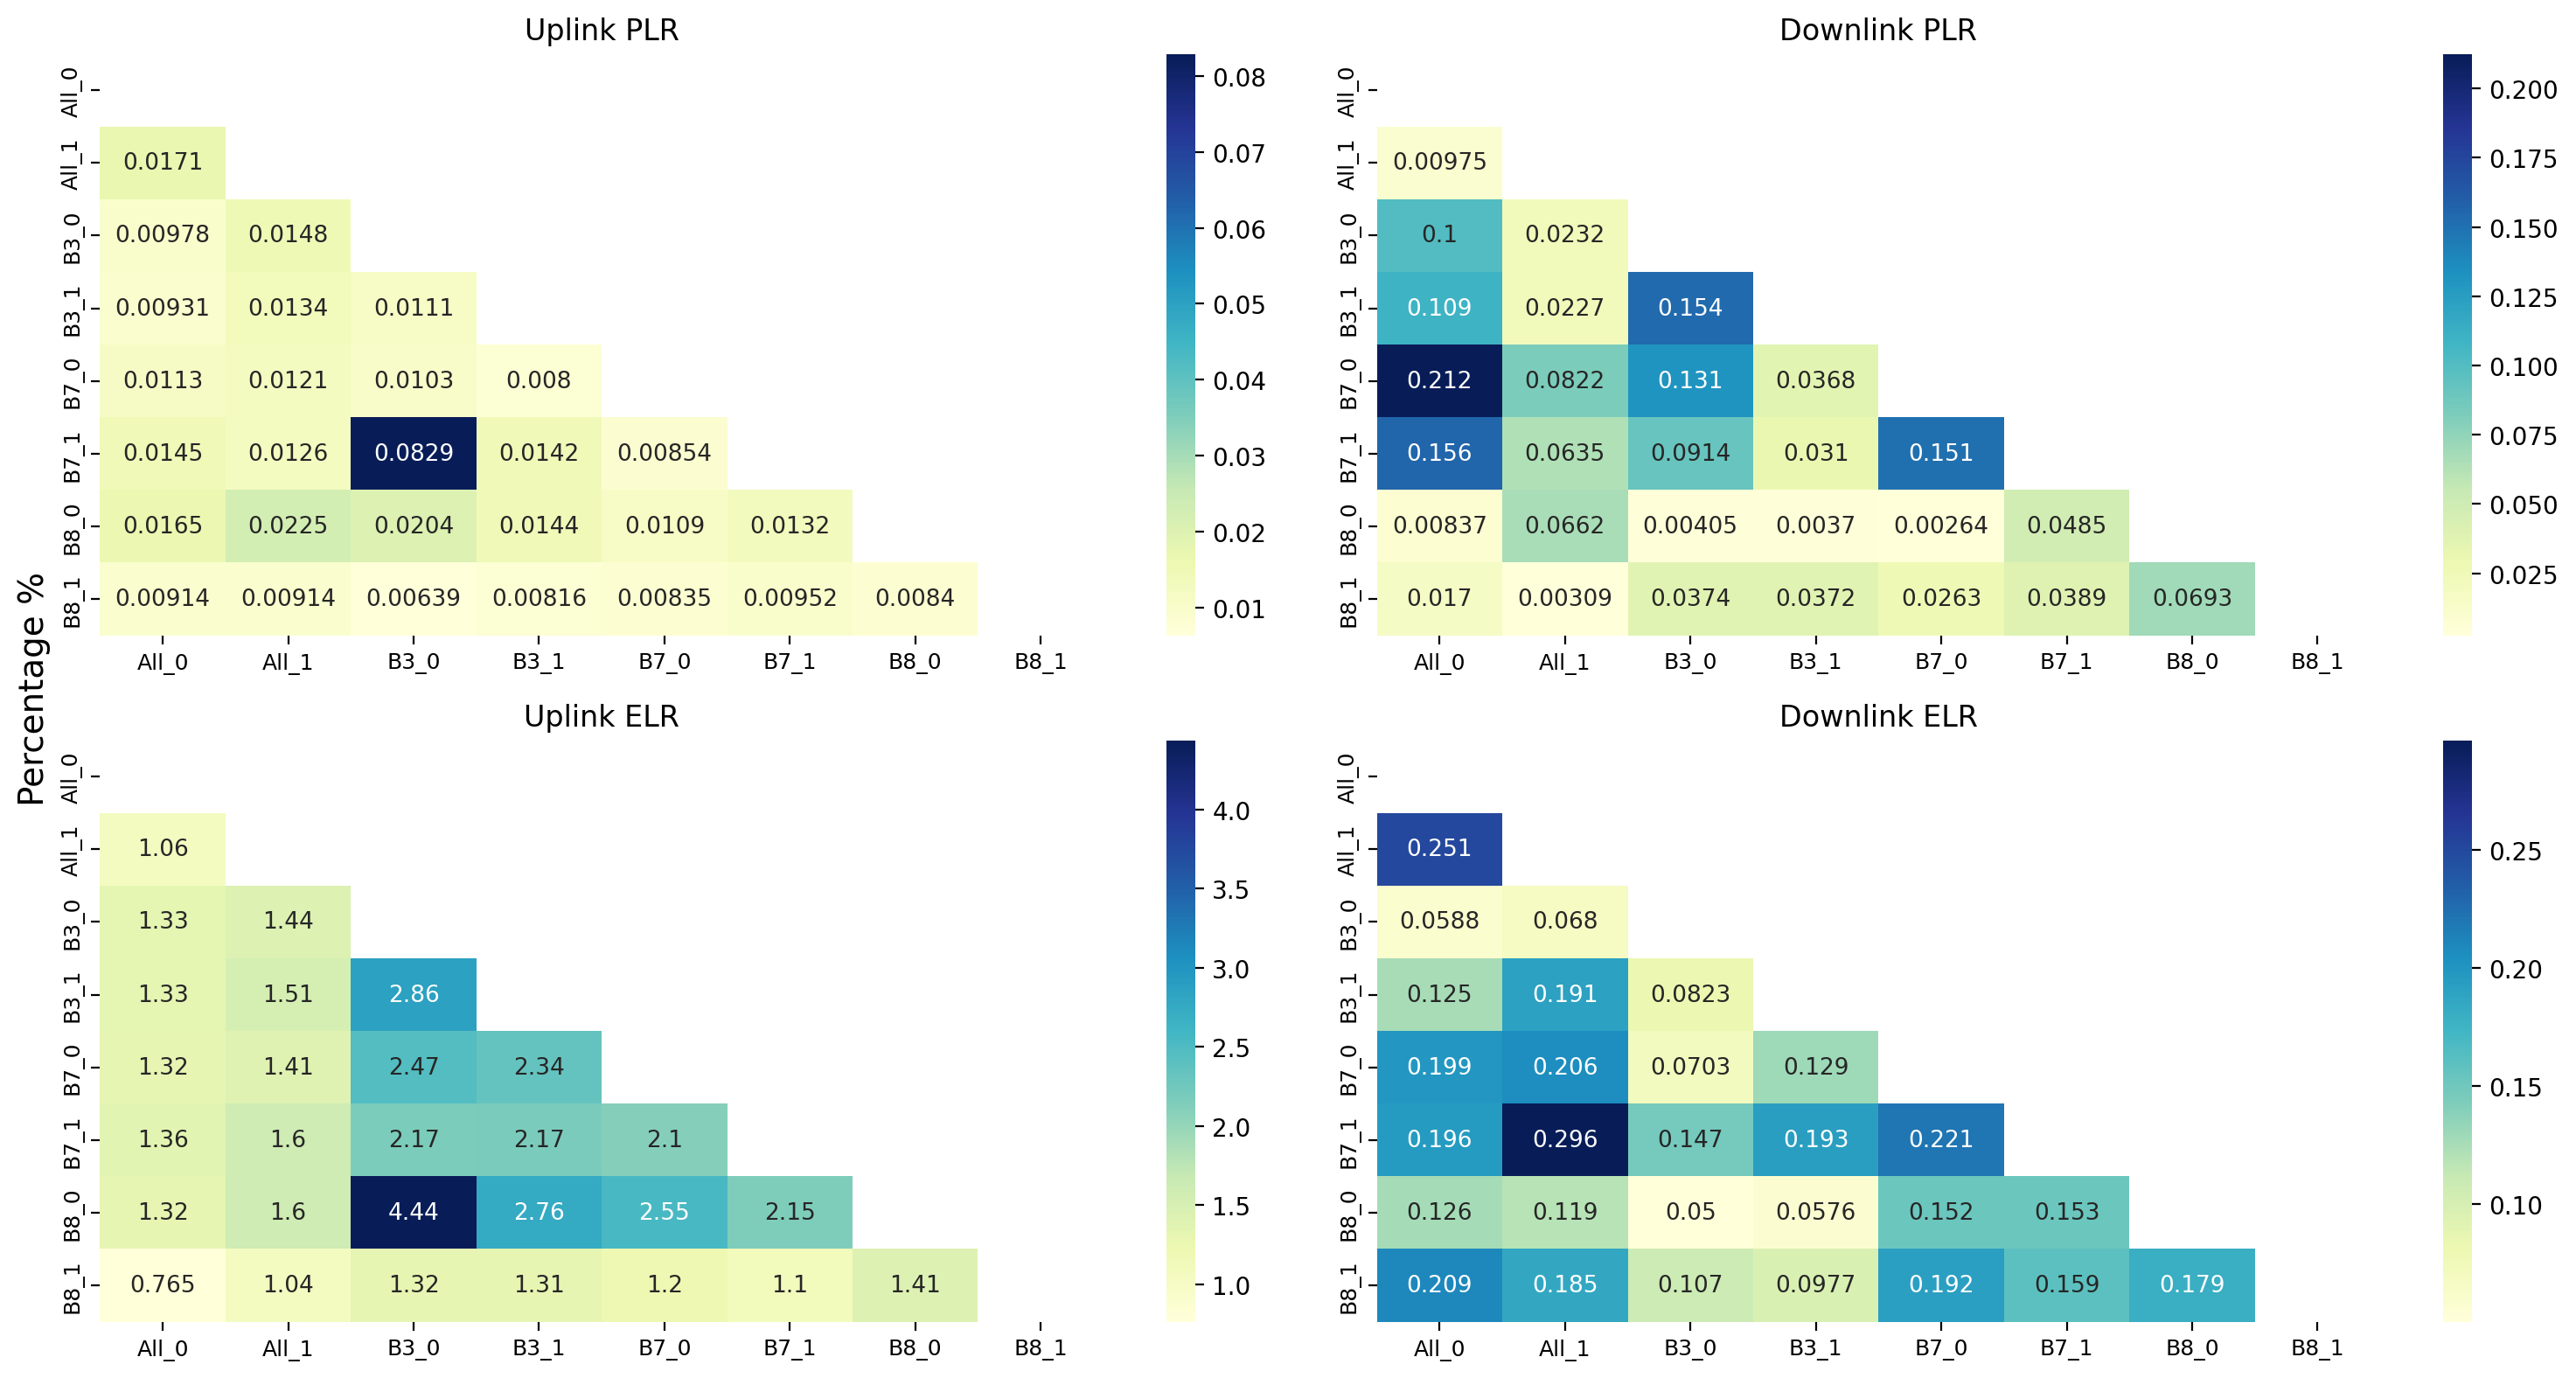

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             5   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             3   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             4   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7       #01, #03, #04, #05, #06     1.278359             7   
6   sm06   B8       #01, #03, #04, #05, #06     1.185786             6   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             2   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             6     0.831878   
5     2.532447             8     2.604340             5     0.461063   
6     1.190465             3     1.640298             3     0.531022   
7     1.476035             4     2.474258             4     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             1  
6             3  
7             4

Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   LTE_0+LTE_1  #01, #02, #03, #04, #05, #06     0.799353            11   
1    LTE_0+B3_0  #01, #02, #03, #04, #05, #06     0.792909             3   
2    LTE_0+B3_1  #01, #02, #03, #04, #05, #06     0.793947             5   
3    LTE_0+B7_0  #01, #02, #03, #04, #05, #06     0.792712             2   
4    LTE_0+B7_1       #01, #03, #04, #05, #06     0.951510            20   
5    LTE_0+B8_0       #01, #03, #04, #05, #06     0.949237            16   
6    LTE_0+B8_1  #01, #02, #03, #04, #05, #06     0.798440            10   
7    LTE_1+B3_0  #01, #02, #03, #04, #05, #06     0.795283             8   
8    LTE_1+B3_1  #01, #02, #03, #04, #05, #06     0.793711             4   
9    LTE_1+B7_0  #01, #02, #03, #04, #05, #06     0.808278            13   
10   LTE_1+B7_1       #01, #03, #04, #05, #06     0.955717            26   
11   LTE_1+B8_0       #01, #03, #04, #05, #06     0.955204            25   
12   LTE_1+B8_1  #01, #02, #03, #04, #05, #06     0.798366             9   
13    B3_0+B3_1  #01, #02, #03, #04, #05, #06     0.801080            12   
14    B3_0+B7_0  #01, #02, #03, #04, #05, #06     0.811982            15   
15    B3_0+B7_1       #01, #03, #04, #05, #06     0.957650            27   
16    B3_0+B8_0       #01, #03, #04, #05, #06     0.950611            18   
17    B3_0+B8_1  #01, #02, #03, #04, #05, #06     0.794188             7   
18    B3_1+B7_0  #01, #02, #03, #04, #05, #06     0.794039             6   
19    B3_1+B7_1       #01, #03, #04, #05, #06     0.953878            23   
20    B3_1+B8_0       #01, #03, #04, #05, #06     0.951018            19   
21    B3_1+B8_1  #01, #02, #03, #04, #05, #06     0.792049             1   
22    B7_0+B7_1       #01, #03, #04, #05, #06     0.989299            28   
23    B7_0+B8_0       #01, #03, #04, #05, #06     0.954692            24   
24    B7_0+B8_1  #01, #02, #03, #04, #05, #06     0.811029            14   
25    B7_1+B8_0       #01, #03, #04, #05, #06     0.953738            22   
26    B7_1+B8_1       #01, #03, #04, #05, #06     0.949414            17   
27    B8_0+B8_1       #01, #03, #04, #05, #06     0.952265            21   

    avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0      0.792646             1     0.028843             3     0.294806   
1      0.792950             3     0.039773             5     0.044183   
2      0.792854             2     0.048648             6     0.046718   
3      0.798591             5     0.082327             7     0.227947   
4      0.951220            10     0.024165             2     0.142134   
5      0.951470            11     0.032411             4     0.016132   
6      0.795002             4     0.022611             1     0.068341   
7      0.875096             6     0.197426            12     0.023538   
8      0.893729             8     0.187152            11     0.014780   
9      0.900598             9     0.170452            10     0.095096   
10     1.084260            23     0.230328            13     0.073510   
11     0.953761            12     0.112465             8     0.023326   
12     0.887442             7     0.131847             9     0.020412   
13     1.086348            24     2.813977            28     0.135948   
14     0.998914            19     1.823793            27     0.291474   
15     1.175339            25     1.384540            22     0.087777   
16     0.978195            15     1.137209            19     0.083050   
17     1.036675            21     1.556509            25     0.062557   
18     0.982675            17     1.546468            24     0.118466   
19     1.218258            26     1.538249            23     0.094161   
20     0.983505            18     1.160644            20     0.125751   
21     1.024718            20     1.689115            26     0.107599   
22     1.320688            28     0.729845            15     0.083088   
23     0.954165            13     0.527476            

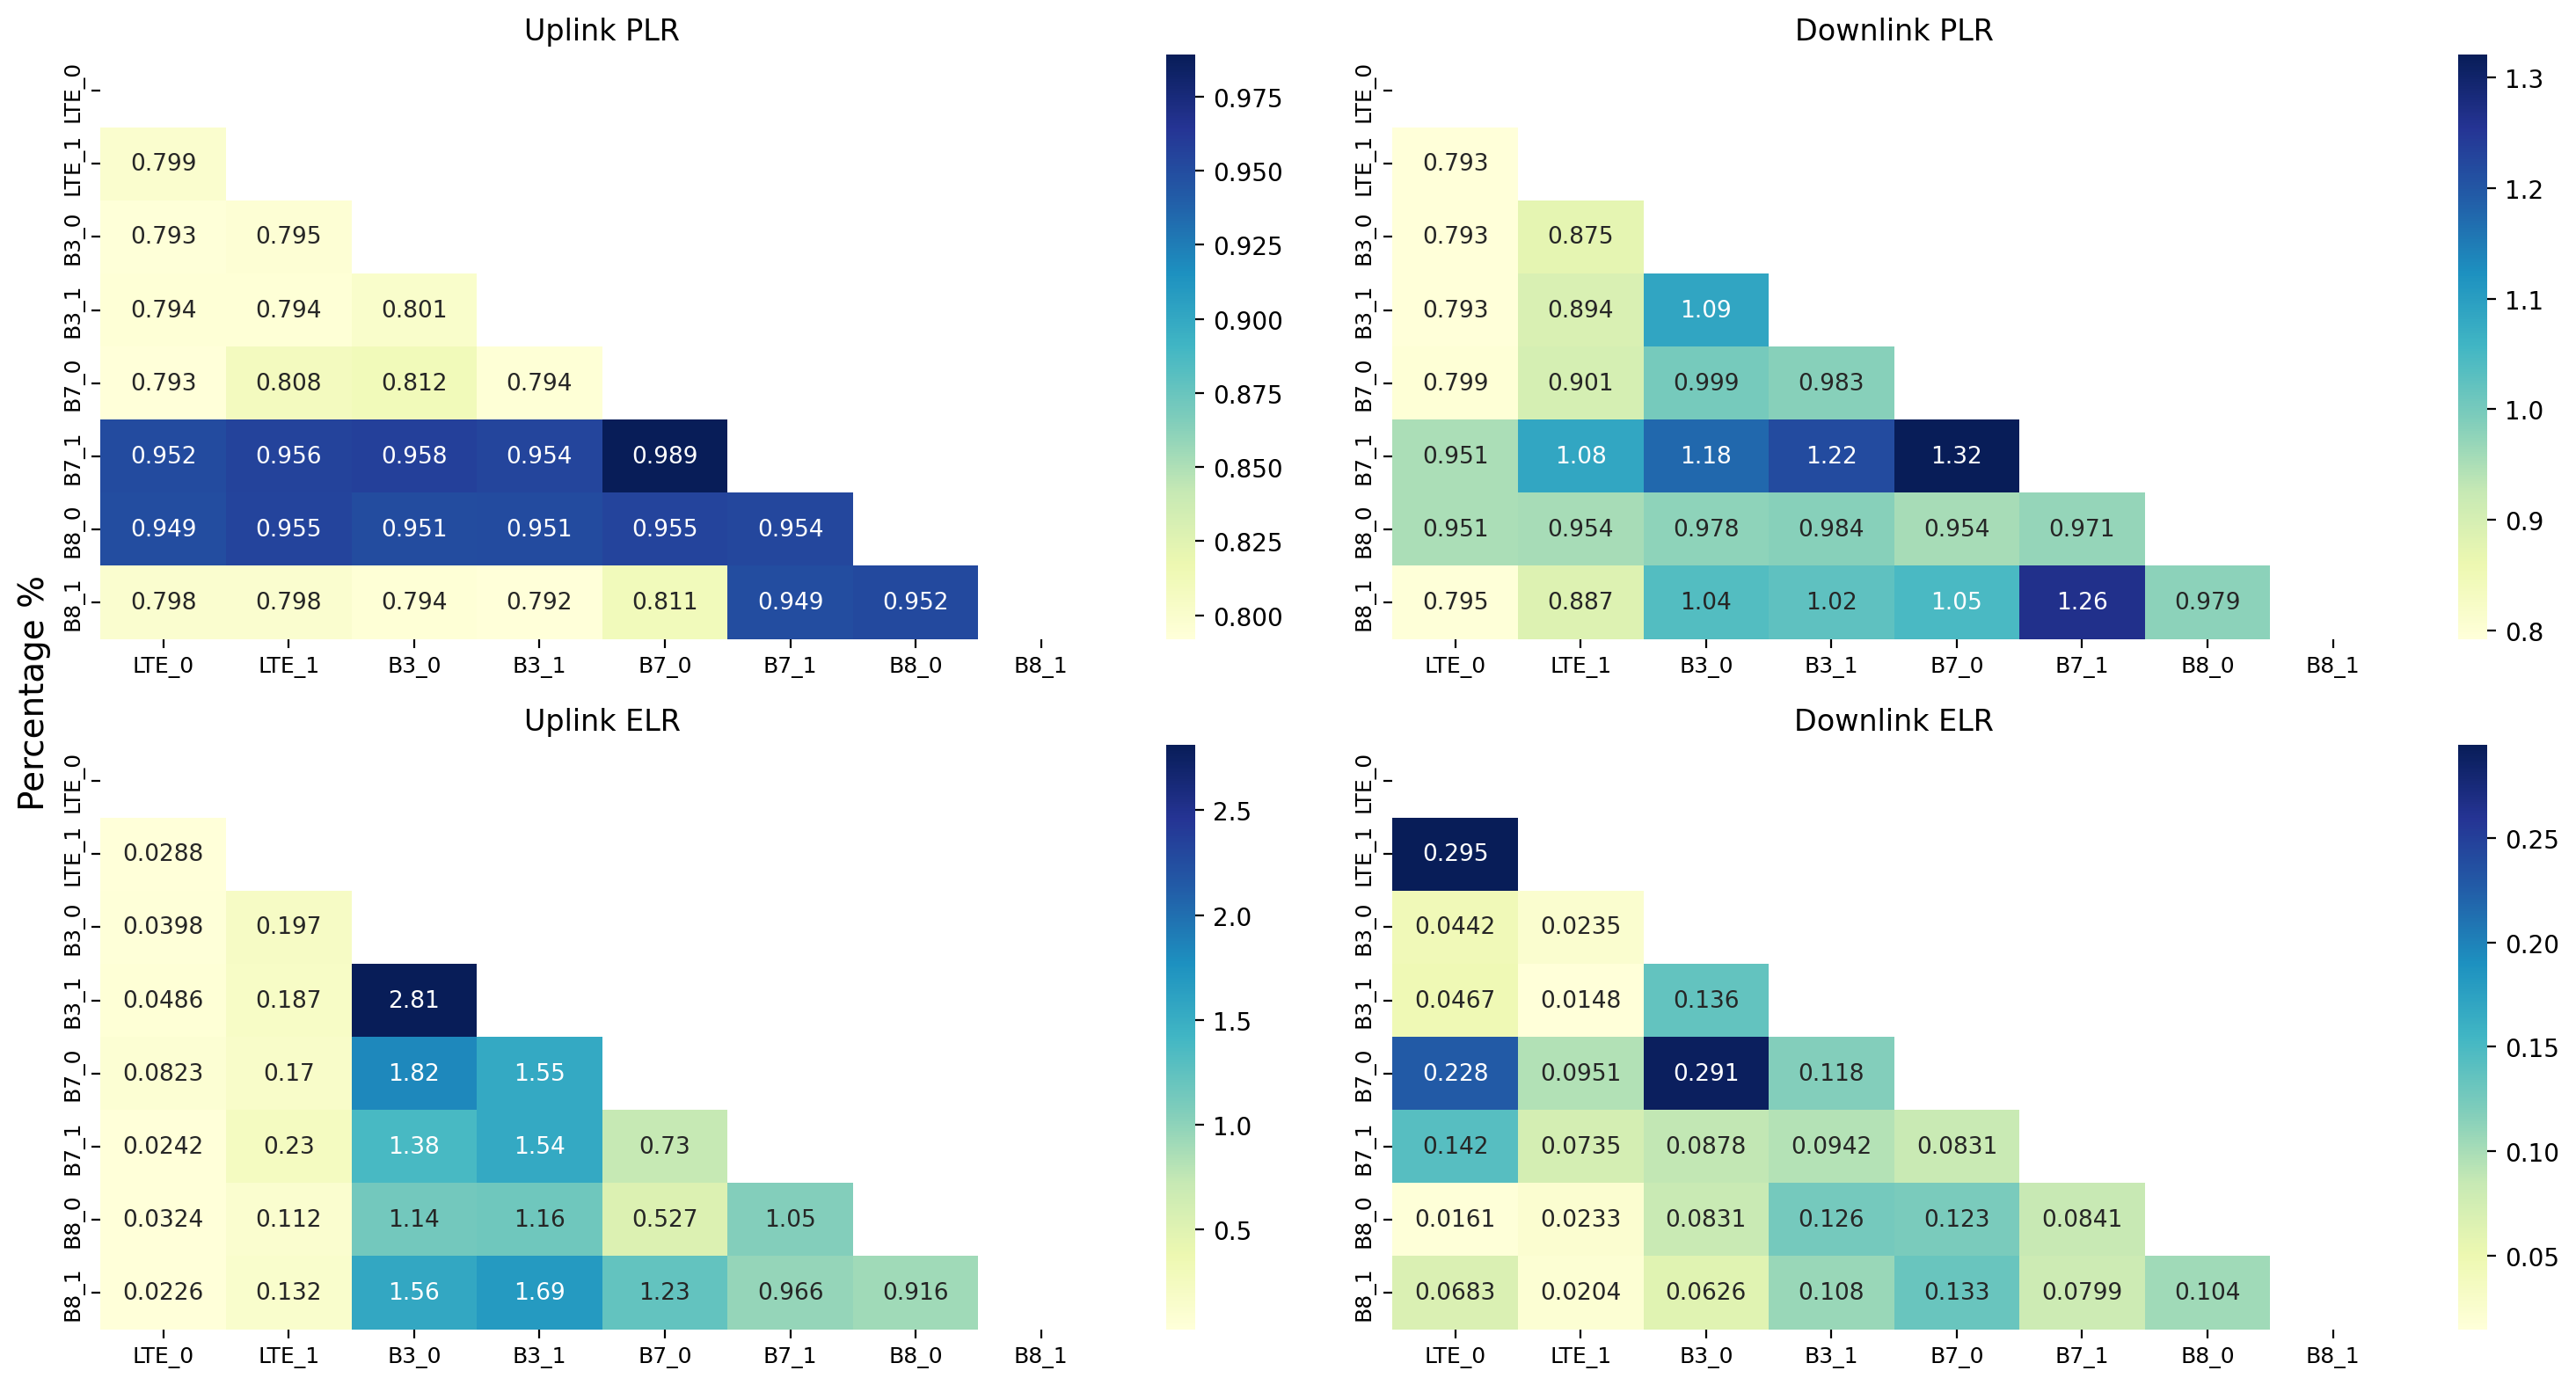

In [292]:
def mask(size, mode='lower', diag=True):
    
    mask = np.ones((size, size))
    if mode == 'lower': # 保留下三角(遮蔽上三角)
        mask[np.tril_indices(size)] = 0
    elif mode == 'upper': # 保留上三角(遮蔽下三角)
        mask[np.triu_indices(size)] = 0
    elif mode == 'square': # 全保留
        mask = np.zeros((size, size))
    else:
        print(f"Warning: mask() has no option '{mode}' for argument: 'mode'.")
        print("Please specify 'upper', 'lower', or 'square' instead.")
    
    if not diag: # 不保留對角線(遮蔽對角線)
        mask[np.diag_indices(size)] = 1

    return mask

for expr, metrics_dict in zip(exp_list, dual_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)
    display(expr.metadata_dual)
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR']
    
    ### 建立表格方便製圖
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    combinations = ['+'.join(s) if s[0] != s[1] else s[0] for s in it.product(schemes, repeat=2)]
    
    size = len(expr.setting)
    
    ### Average
    # print(f'{expr.date} | {expr.name}')
    # for ndiag in [False, True]:
    for ndiag in [True]:
        fig, axes = plt.subplots(2, 2, figsize=(15, 8))
        for pos, tag in enumerate(['ul_loss', 'ul_excl', 'dl_loss', 'dl_excl']):
            title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
            i = pos % 2; j = pos // 2
            
            data = [np.nanmean([num if num >= 0 else np.nan for num in metrics_dict[comb][tag]]) if comb in metrics_dict else -1 for comb in combinations]
            reshaped_data = np.array(data).reshape(size, size)
            sns.heatmap(reshaped_data.T, ax=axes[i][j], annot=True, fmt='.3g', mask=mask(size, diag=not ndiag), annot_kws={"size": 9.5}, cmap="YlGnBu")
            axes[i][j].set_xticklabels(schemes, fontsize=9)
            axes[i][j].set_yticklabels(schemes, fontsize=9)
            axes[i][j].set_title(title)
            
            # 在相应位置上标注"N/A"
            _mask = mask(size, diag=not ndiag)
            rows, cols = reshaped_data.shape
            for k in range(rows):
                for l in range(cols):
                    if np.isnan(reshaped_data.T[k][l]) and _mask[k][l] == 0:
                        axes[i][j].text(l + 0.5, k + 0.5, "N/A", ha='center', va='center', color='red', fontweight='bold')
        
        fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
        
        plt.tight_layout()
        plt.show()

## Heatmap: Per Round

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   All_0+All_1  #01, #02, #03, #04     0.017132            25     0.009754   
1    All_0+B3_0  #01, #02, #03, #04     0.009782            11     0.100379   
2    All_0+B3_1  #01, #02, #03, #04     0.009306             9     0.109208   
3    All_0+B7_0  #01, #02, #03, #04     0.011298            15     0.212467   
4    All_0+B7_1  #01, #02, #03, #04     0.014524            22     0.156036   
5    All_0+B8_0  #01, #02, #03, #04     0.016483            24     0.008374   
6    All_0+B8_1  #01, #02, #03, #04     0.009144             7     0.017000   
7    All_1+B3_0  #01, #02, #03, #04     0.014850            23     0.023164   
8    All_1+B3_1  #01, #02, #03, #04     0.013385            19     0.022727   
9    All_1+B7_0  #01, #02, #03, #04     0.012074            16     0.082244   
10   All_1+B7_1  #01, #02, #03, #04     0.012567            17     0.063534   
11   All_1+B8_0  #01, #02, #03, #04     0.022538            27     0.066177   
12   All_1+B8_1  #01, #02, #03, #04     0.009144             8     0.003086   
13    B3_0+B3_1  #01, #02, #03, #04     0.011085            14     0.154154   
14    B3_0+B7_0  #01, #02, #03, #04     0.010279            12     0.131356   
15    B3_0+B7_1  #01, #02, #03, #04     0.082872            28     0.091406   
16    B3_0+B8_0  #01, #02, #03, #04     0.020405            26     0.004052   
17    B3_0+B8_1  #01, #02, #03, #04     0.006390             1     0.037390   
18    B3_1+B7_0  #01, #02, #03, #04     0.007995             2     0.036802   
19    B3_1+B7_1  #01, #02, #03, #04     0.014228            20     0.031035   
20    B3_1+B8_0  #01, #02, #03, #04     0.014392            21     0.003700   
21    B3_1+B8_1  #01, #02, #03, #04     0.008164             3     0.037212   
22    B7_0+B7_1  #01, #02, #03, #04     0.008537             6     0.150562   
23    B7_0+B8_0  #01, #02, #03, #04     0.010932            13     0.002643   
24    B7_0+B8_1  #01, #02, #03, #04     0.008349             4     0.026321   
25    B7_1+B8_0  #01, #02, #03, #04     0.013230            18     0.048492   
26    B7_1+B8_1  #01, #02, #03, #04     0.009516            10     0.038884   
27    B8_0+B8_1  #01, #02, #03, #04     0.008401             5     0.069271   

    dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0              6     1.060746             3     0.251097            27  
1             22     1.333517            11     0.058754             3  
2             23     1.327328            10     0.125105            10  
3             28     1.322553             9     0.199198            23  
4             27     1.364544            12     0.195594            22  
5              5     1.321083             8     0.126338            11  
6              7     0.764731             1     0.208866            25  
7              9     1.438489            15     0.067973             4  
8              8     1.511727            16     0.191392            19  
9             20     1.410283            13     0.205839            24  
10            17     1.598695            17     0.296444            28  
11            18     1.601976            18     0.118767             9  
12             2     1.039685             2     0.185483            18  
13            26     2.864911            27     0.082260             6  
14            24     2.470136            24     0.070277             5  
15            21     2.169666            21     0.147499            13  
16             4     4.437835            28     0.050003             1  
17            14     1.318347             7     0.107196             8  
18            12     2.339875            23     0.129240            12  
19            11     2.172002            22     0.193380            21  
20             3     2.755402            26     0.057578             2  
21            13     1.312336             6     0.097666             7  
22            25     2.104571           

Uplink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01         3     7    8    2    4    5    1    6
#02         5     8    6    1    7    3    2    4
#03         3     6    7    1    2    8    5    4
#04         6     5    1    3    8    4    7    2
Score       0    -3   -1    5   -2   -2    2    1
Ranking     3     2    6    7    1    5    8    4

All_0+All_1  All_0+B3_0  All_0+B3_1  All_0+B7_0  All_0+B7_1  \
#01              1.0         2.0         3.0         4.0         5.0   
#02             24.0         1.0         2.0        26.0         3.0   
#03             25.0        11.0         8.0        13.0        22.0   
#04              1.0         2.0        19.0        22.0        17.0   
Score            6.0         7.0         3.0        -2.0         1.0   
Ranking          2.0         1.0         3.0        23.0         5.0   

         All_0+B8_0  All_0+B8_1  All_1+B3_0  All_1+B3_1  All_1+B7_0  \
#01            25.0         6.0         7.0        26.0         8.0   
#02             4.0         5.0        23.0         6.0         7.0   
#03            24.0         9.0        23.0        19.0        16.0   
#04             3.0         4.0         5.0         6.0         7.0   
Score           1.0         0.0         0.0        -2.0         0.0   
Ranking         6.0         7.0         8.0        24.0         9.0   

         All_1+B7_1  All_1+B8_0  All_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01             9.0        10.0        11.0       12.0       13.0       27.0   
#02             8.0         9.0        10.0       11.0       12.0       13.0   
#03            17.0        27.0        10.0       15.0       12.0       28.0   
#04            18.0        24.0         8.0        9.0       10.0       23.0   
Score           0.0        -1.0         0.0        0.0        0.0       -4.0   
Ranking        10.0        21.0        11.0       12.0       13.0       27.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01           24.0       21.0       14.0       19.0       20.0       15.0   
#02           25.0       27.0       14.0       15.0       16.0       17.0   
#03           26.0        1.0        4.0       20.0       21.0        6.0   
#04           11.0       12.0       13.0       25.0       26.0       14.0   
Score         -2.0        2.0        0.0        0.0       -2.0        0.0   
Ranking       25.0        4.0       14.0       15.0       26.0       16.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           16.0       17.0       22.0       18.0       28.0       23.0  
#02           18.0       19.0       20.0       21.0       28.0       22.0  
#03            3.0       14.0        5.0       18.0        7.0        2.0  
#04           27.0       15.0       20.0       21.0       16.0       28.0  
Score          0.0        0.0        0.0        0.0       -6.0       -1.0  
Ranking       17.0       18.0       19.0       20.0       28.0       22.0

Downlink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01         8     3    5    2    4    1    6    7
#02         8     3    4    7    6    5    1    2
#03         1     5    6    3    4    8    2    7
#04         7     2    6    4    8    5    3    1
Score      -3     1    0    0   -2    0    3    1
Ranking     2     1    4    7    5    6    3    8

All_0+All_1  All_0+B3_0  All_0+B3_1  All_0+B7_0  All_0+B7_1  \
#01             23.0         1.0        24.0        26.0        27.0   
#02              1.0        25.0        23.0        28.0        26.0   
#03              1.0         2.0         3.0         4.0         5.0   
#04             10.0        21.0        23.0         1.0        25.0   
Score            6.0         5.0         1.0        -2.0        -3.0   
Ranking          1.0         2.0         4.0        22.0        25.0   

         All_0+B8_0  All_0+B8_1  All_1+B3_0  All_1+B3_1  All_1+B7_0  \
#01            22.0        17.0         2.0        20.0        25.0   
#02             2.0        12.0         7.0        10.0        18.0   
#03             6.0         7.0        20.0        21.0        25.0   
#04             2.0         3.0        26.0        18.0         4.0   
Score           4.0         1.0         0.0         0.0         0.0   
Ranking         3.0         5.0         8.0         9.0        10.0   

         All_1+B7_1  All_1+B8_0  All_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            15.0         3.0        18.0        4.0        5.0        6.0   
#02            16.0        21.0         3.0       27.0       20.0       22.0   
#03            26.0        22.0         8.0        9.0       10.0       23.0   
#04             5.0         6.0        12.0       27.0       28.0       22.0   
Score          -2.0         1.0         1.0       -2.0       -3.0        0.0   
Ranking        23.0         6.0         7.0       24.0       26.0       11.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            7.0        8.0       21.0        9.0       10.0       11.0   
#02            4.0       19.0       15.0       13.0        5.0       17.0   
#03           11.0       12.0       13.0       14.0       15.0       16.0   
#04           17.0       13.0       11.0       20.0       16.0       14.0   
Score          0.0        0.0        0.0        0.0        0.0        0.0   
Ranking       12.0       13.0       14.0       15.0       16.0       17.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           14.0       12.0       19.0       13.0       16.0       28.0  
#02           24.0        6.0        8.0       14.0        9.0       11.0  
#03           28.0       17.0       24.0       18.0       27.0       19.0  
#04           19.0       15.0        7.0       24.0        8.0        9.0  
Score         -3.0        0.0        0.0        0.0       -1.0       -3.0  
Ranking       27.0       18.0       19.0       20.0       21.0       28.0

Uplink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01         6     7    5    3    8    2    1    4
#02         3     2    8    6    5    4    7    1
#03         8     6    1    7    5    3    4    2
#04         1     5    7    8    3    6    4    2
Score       0     0   -1   -3   -2    1    1    4
Ranking     1     2    3    7    8    6    4    5

All_0+All_1  All_0+B3_0  All_0+B3_1  All_0+B7_0  All_0+B7_1  \
#01             18.0         7.0        25.0        28.0        19.0   
#02              9.0        16.0        14.0        17.0        15.0   
#03             28.0        10.0        18.0         8.0        21.0   
#04              3.0         6.0         5.0         1.0         7.0   
Score           -2.0         0.0         0.0         0.0         0.0   
Ranking         26.0         7.0         8.0         9.0        10.0   

         All_0+B8_0  All_0+B8_1  All_1+B3_0  All_1+B3_1  All_1+B7_0  \
#01             3.0        26.0        11.0        24.0        23.0   
#02            18.0         2.0         4.0         8.0        12.0   
#03            27.0        17.0        14.0        23.0        22.0   
#04             2.0         4.0        27.0        21.0        12.0   
Score           2.0         0.0        -1.0         0.0         0.0   
Ranking         3.0        11.0        23.0        12.0        13.0   

         All_1+B7_1  All_1+B8_0  All_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            16.0         1.0        20.0        9.0       10.0        8.0   
#02            10.0        11.0         1.0       25.0       24.0       19.0   
#03            24.0        26.0        13.0        9.0        1.0        2.0   
#04            22.0        25.0        14.0       28.0       13.0       26.0   
Score           0.0         1.0         3.0       -3.0        3.0        0.0   
Ranking        14.0         4.0         1.0       27.0        2.0       15.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            4.0       12.0       21.0       15.0        5.0       22.0   
#02           28.0        7.0       23.0       20.0       27.0        5.0   
#03           11.0        6.0       16.0       15.0       20.0        3.0   
#04           24.0       17.0        9.0       23.0       19.0       18.0   
Score         -3.0        0.0        0.0        0.0       -1.0        1.0   
Ranking       28.0       16.0       17.0       18.0       24.0        5.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           17.0        2.0       27.0        6.0       13.0       14.0  
#02           22.0       26.0        6.0       21.0        3.0       13.0  
#03           25.0        4.0        7.0       19.0       12.0        5.0  
#04           15.0       11.0        8.0       20.0       16.0       10.0  
Score          0.0        0.0       -1.0        0.0        1.0        0.0  
Ranking       19.0       20.0       25.0       21.0        6.0       22.0

Downlink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01         5     6    3    4    8    2    1    7
#02         3     8    1    2    5    7    4    6
#03         7     4    3    5    2    8    6    1
#04         4     2    1    5    3    8    7    6
Score      -1    -1    4    1   -1   -4    1    1
Ranking     2     3    8    5    4    1    6    7

All_0+All_1  All_0+B3_0  All_0+B3_1  All_0+B7_0  All_0+B7_1  \
#01             20.0         9.0        17.0        24.0        11.0   
#02             25.0         9.0        12.0        15.0         3.0   
#03             27.0        11.0        13.0        17.0        28.0   
#04             12.0         1.0         9.0        19.0        27.0   
Score           -1.0         3.0         0.0         0.0        -3.0   
Ranking         20.0         1.0         8.0         9.0        26.0   

         All_0+B8_0  All_0+B8_1  All_1+B3_0  All_1+B3_1  All_1+B7_0  \
#01            14.0        25.0         2.0        16.0        26.0   
#02             6.0        16.0        18.0        20.0        10.0   
#03            20.0        24.0        12.0        21.0        18.0   
#04             3.0         6.0        10.0        20.0        15.0   
Score           1.0         0.0         2.0         0.0        -2.0   
Ranking         7.0        10.0         5.0        11.0        24.0   

         All_1+B7_1  All_1+B8_0  All_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            23.0         5.0        27.0        8.0        7.0        4.0   
#02            27.0        17.0         5.0        7.0        8.0       11.0   
#03            26.0        19.0        16.0       14.0        3.0       25.0   
#04             2.0        16.0        11.0       14.0       26.0       24.0   
Score          -1.0         0.0        -1.0        0.0       -1.0        0.0   
Ranking        21.0        12.0        22.0       13.0       23.0       14.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            3.0       19.0       13.0       12.0        6.0       21.0   
#02            2.0       14.0       19.0       22.0        1.0        4.0   
#03            5.0        4.0       10.0       22.0        6.0        2.0   
#04           23.0        7.0       13.0       17.0       21.0        8.0   
Score          3.0        0.0        0.0        0.0        3.0        2.0   
Ranking        2.0       15.0       16.0       17.0        3.0        6.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           22.0       15.0       28.0        1.0       18.0       10.0  
#02           23.0       13.0       21.0       24.0       26.0       28.0  
#03            7.0       15.0        1.0       23.0        8.0        9.0  
#04           28.0       25.0        5.0       22.0        4.0       18.0  
Score         -3.0        0.0        0.0        3.0       -2.0       -3.0  
Ranking       27.0       18.0       19.0        4.0       25.0       28.0

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #01


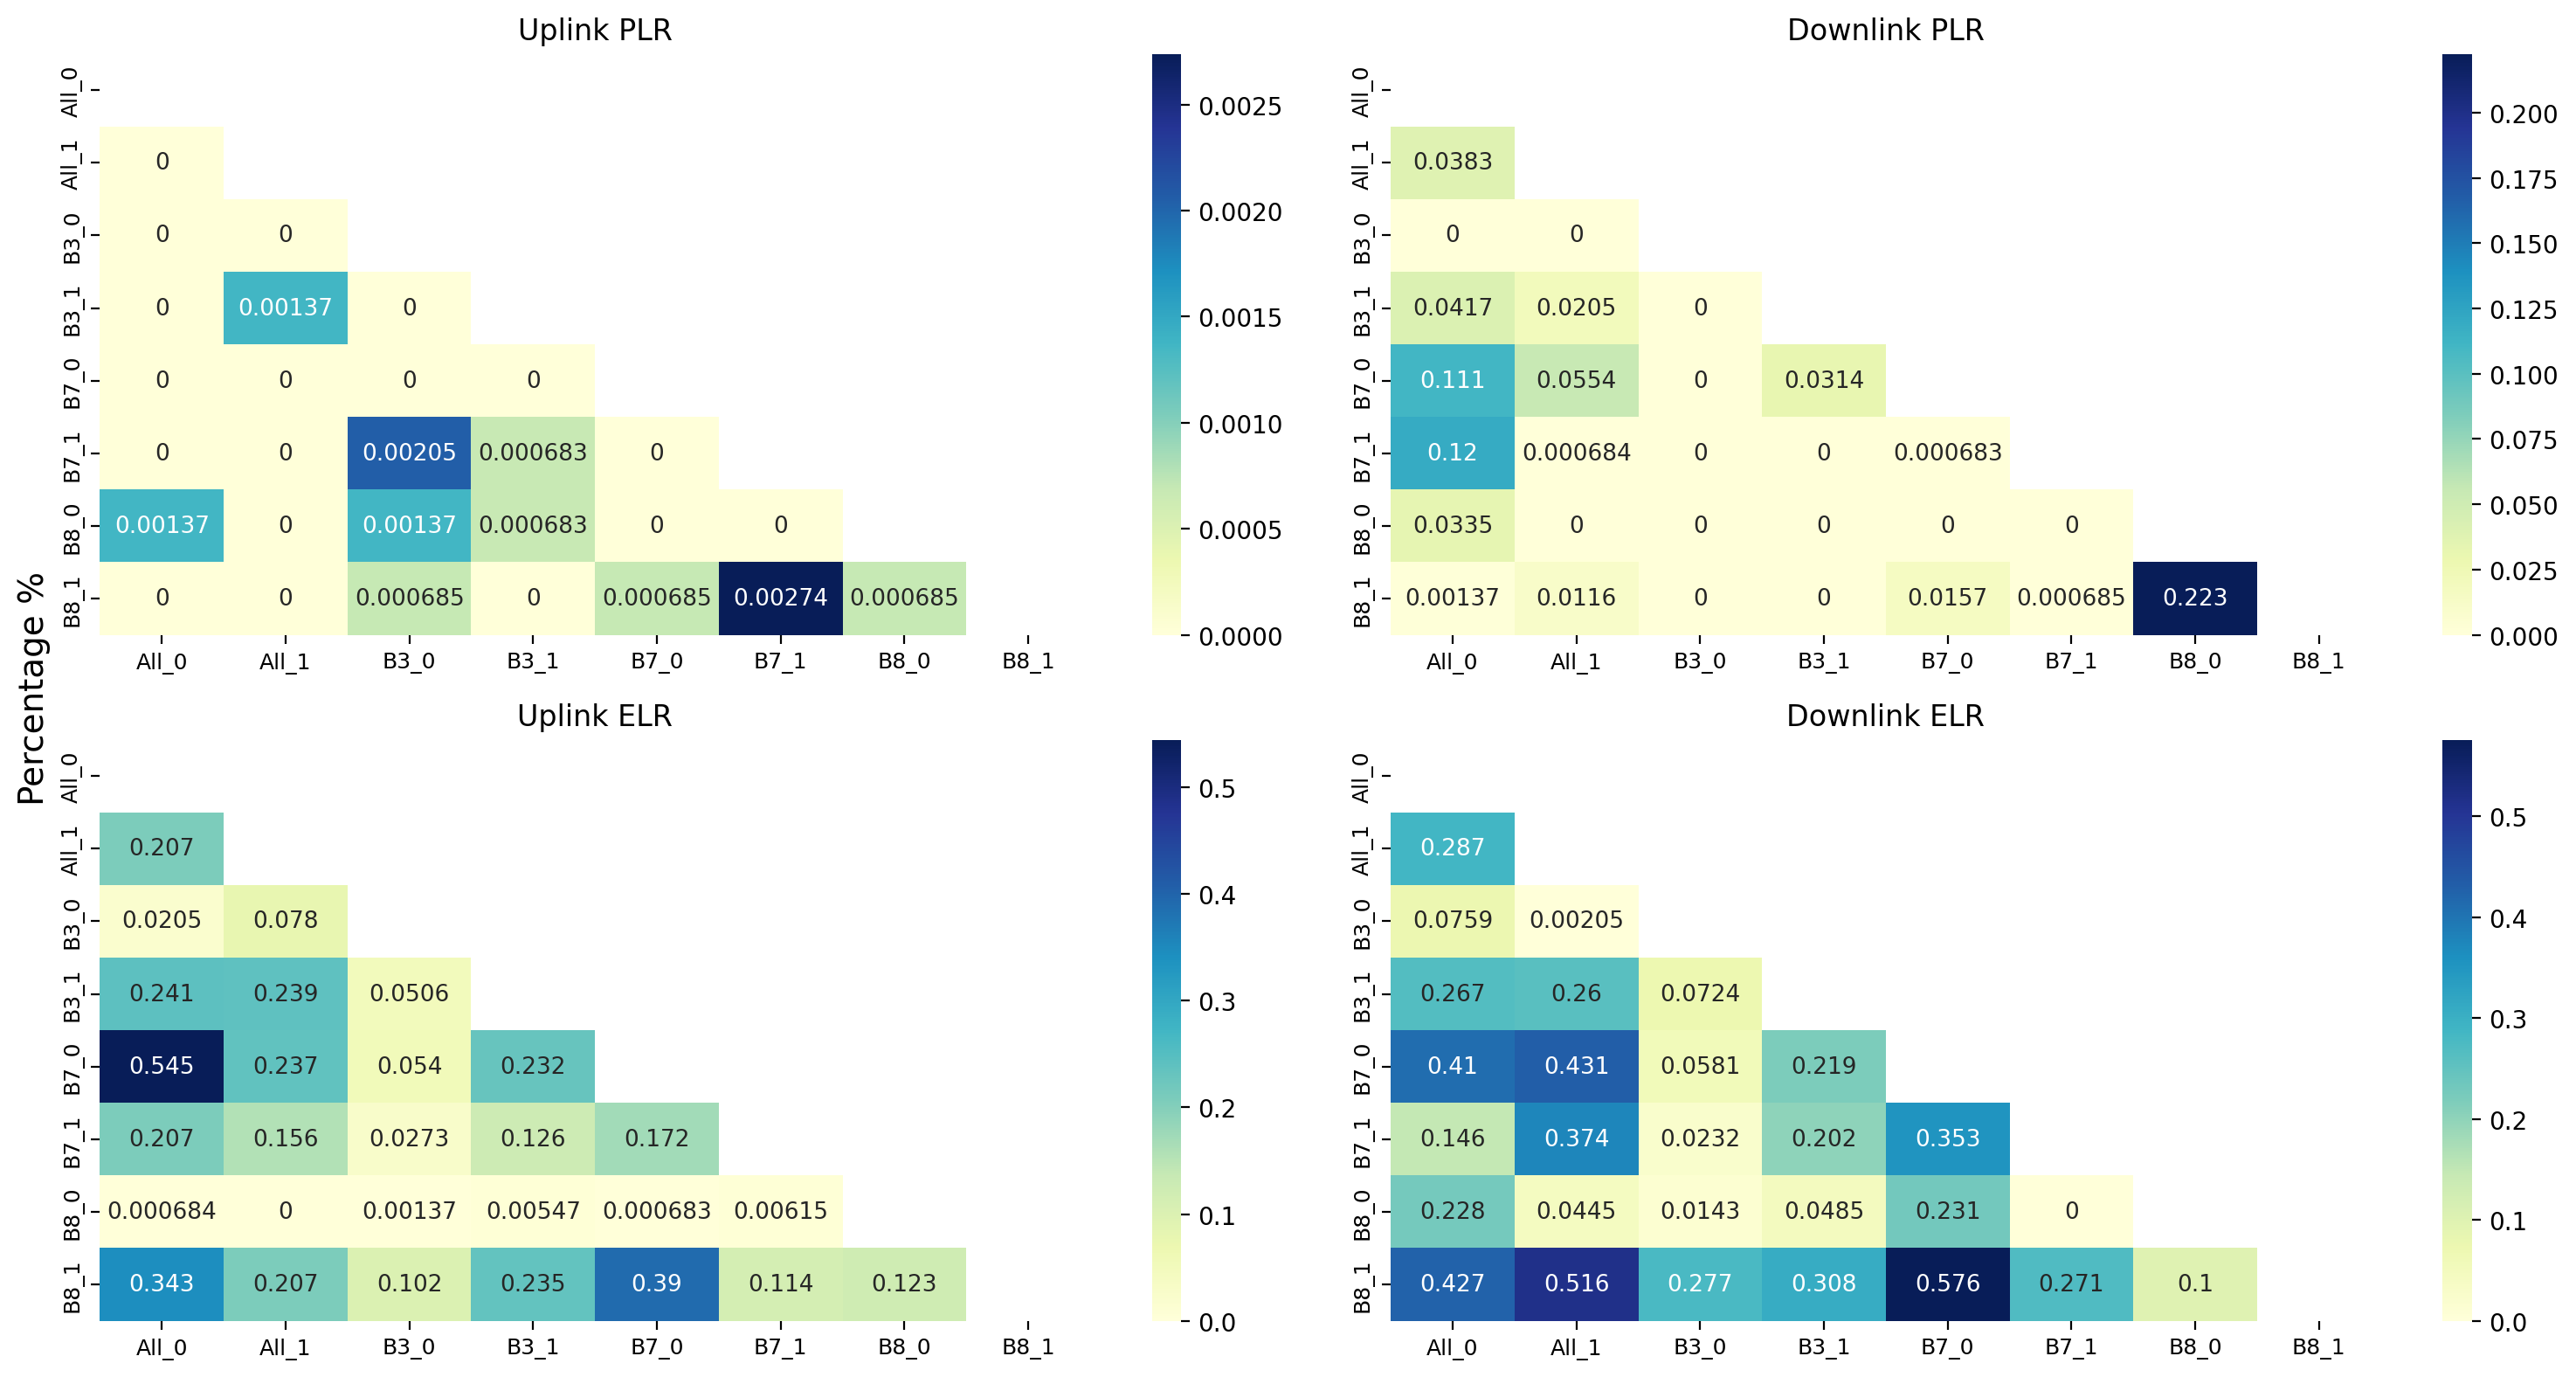

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #02


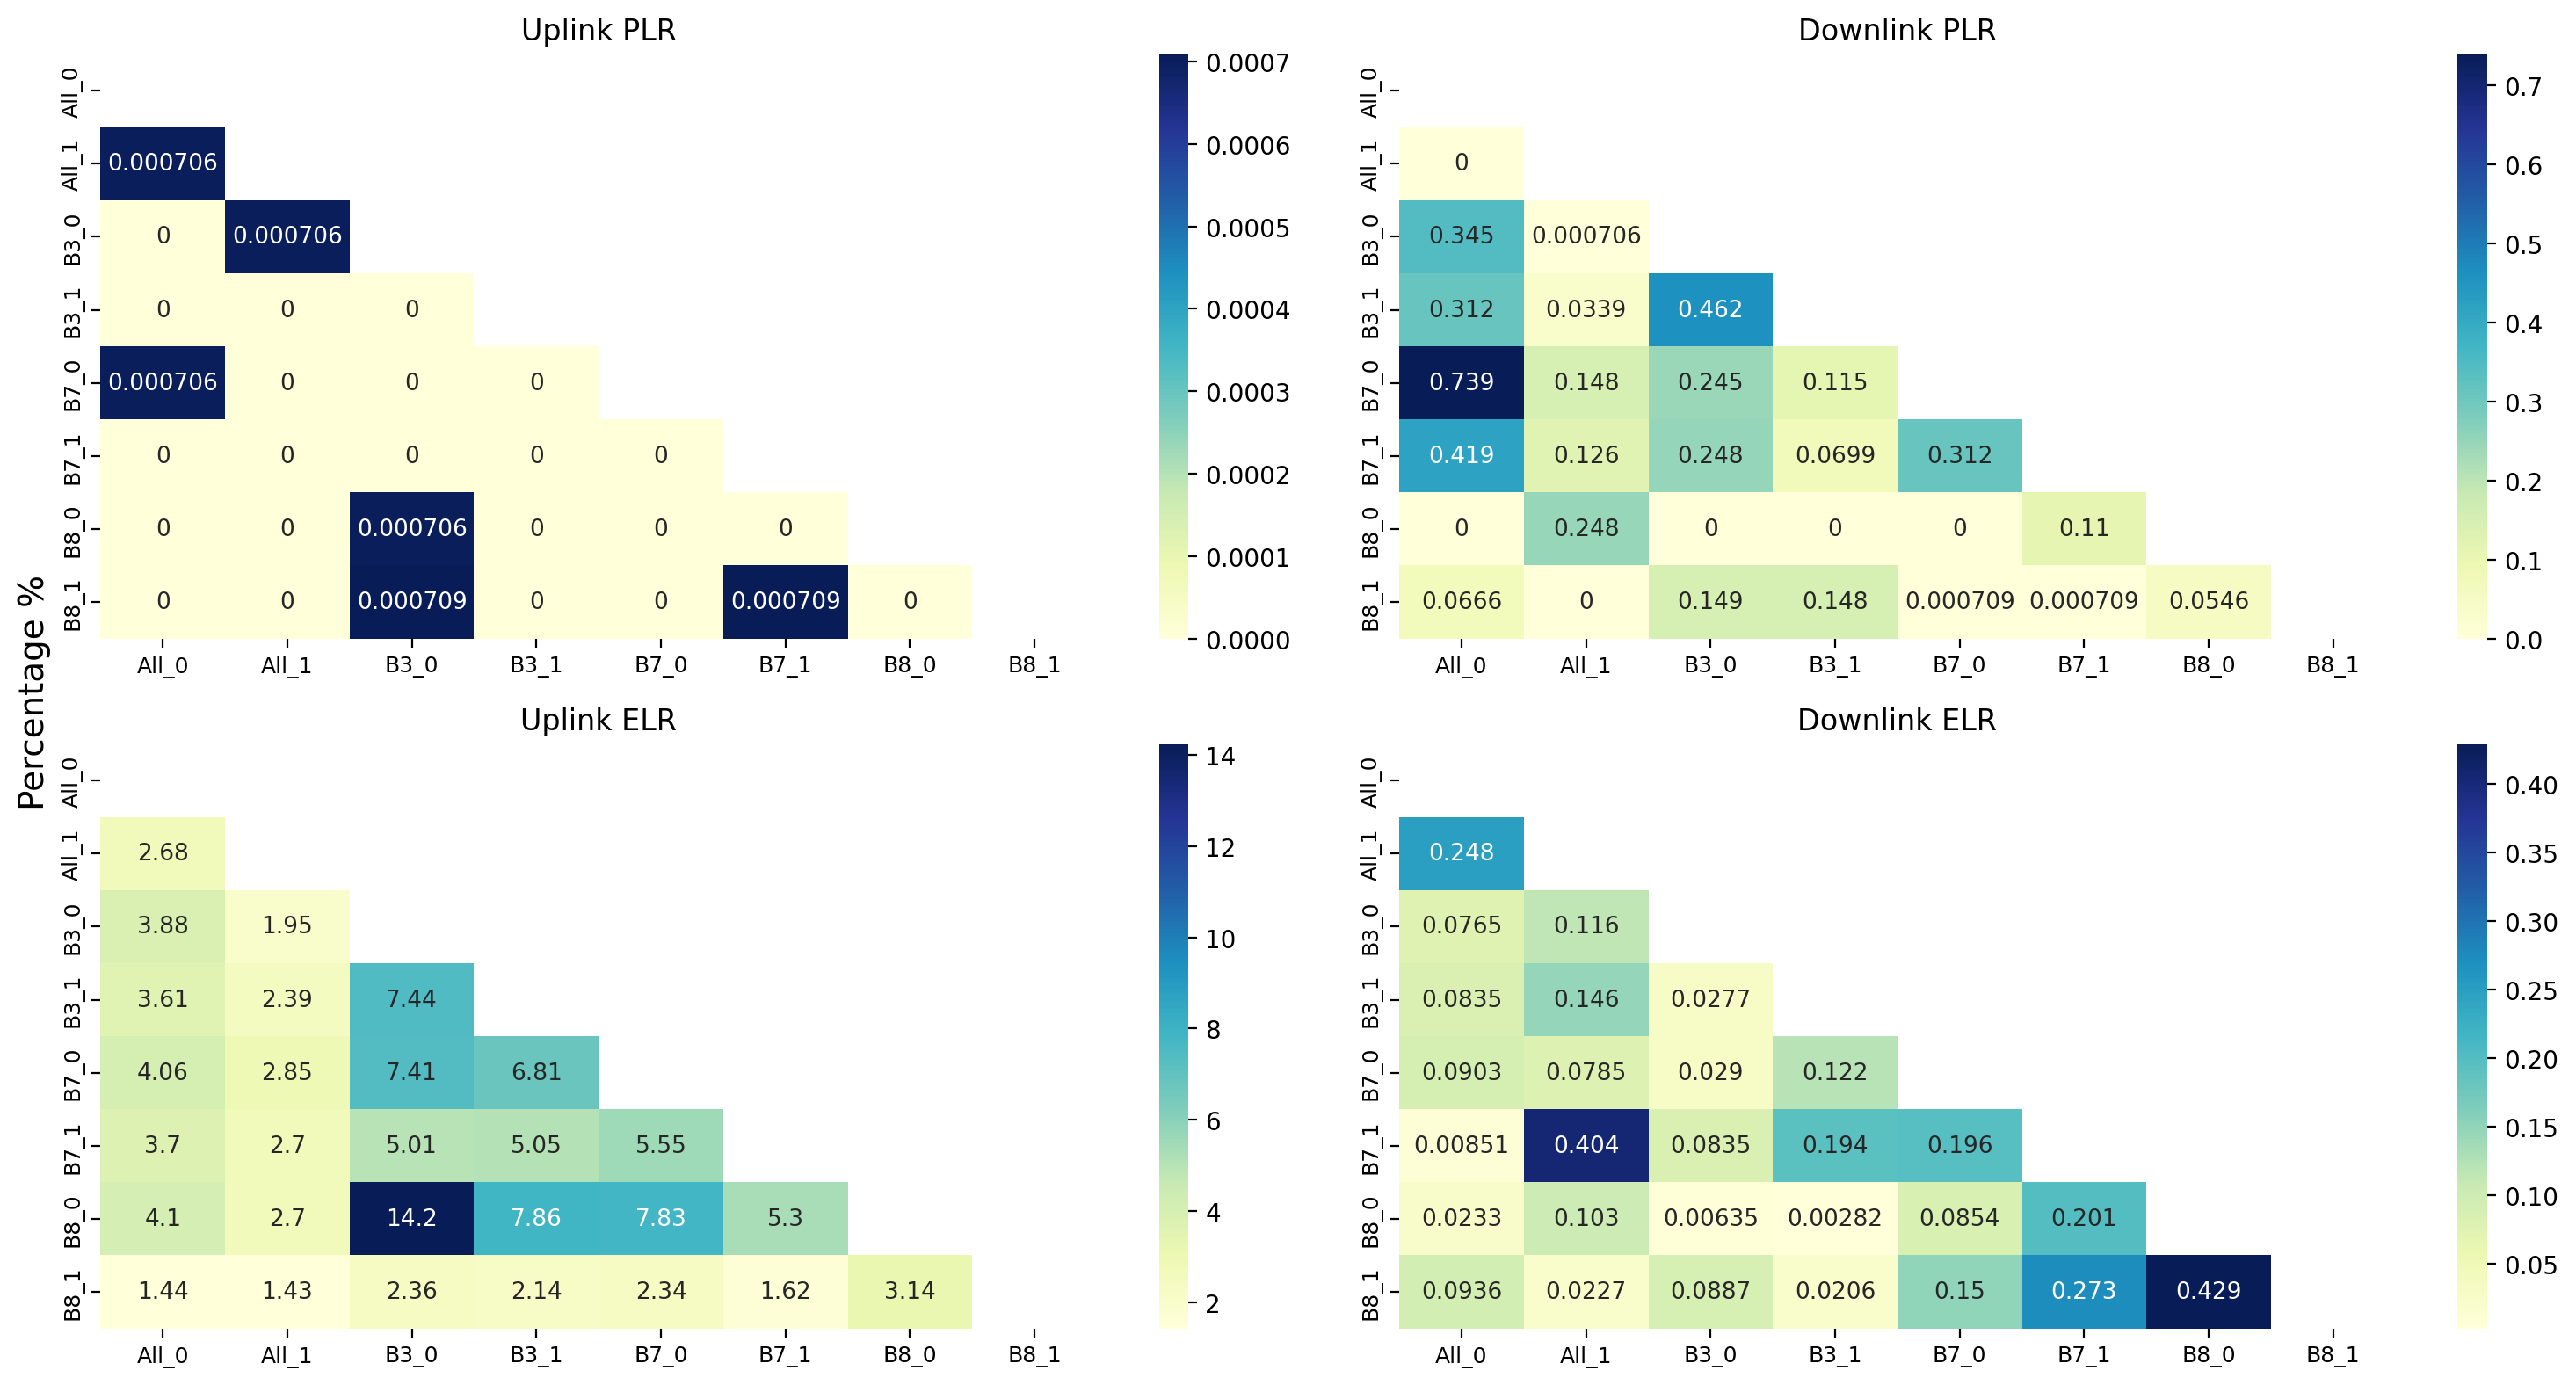

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #03


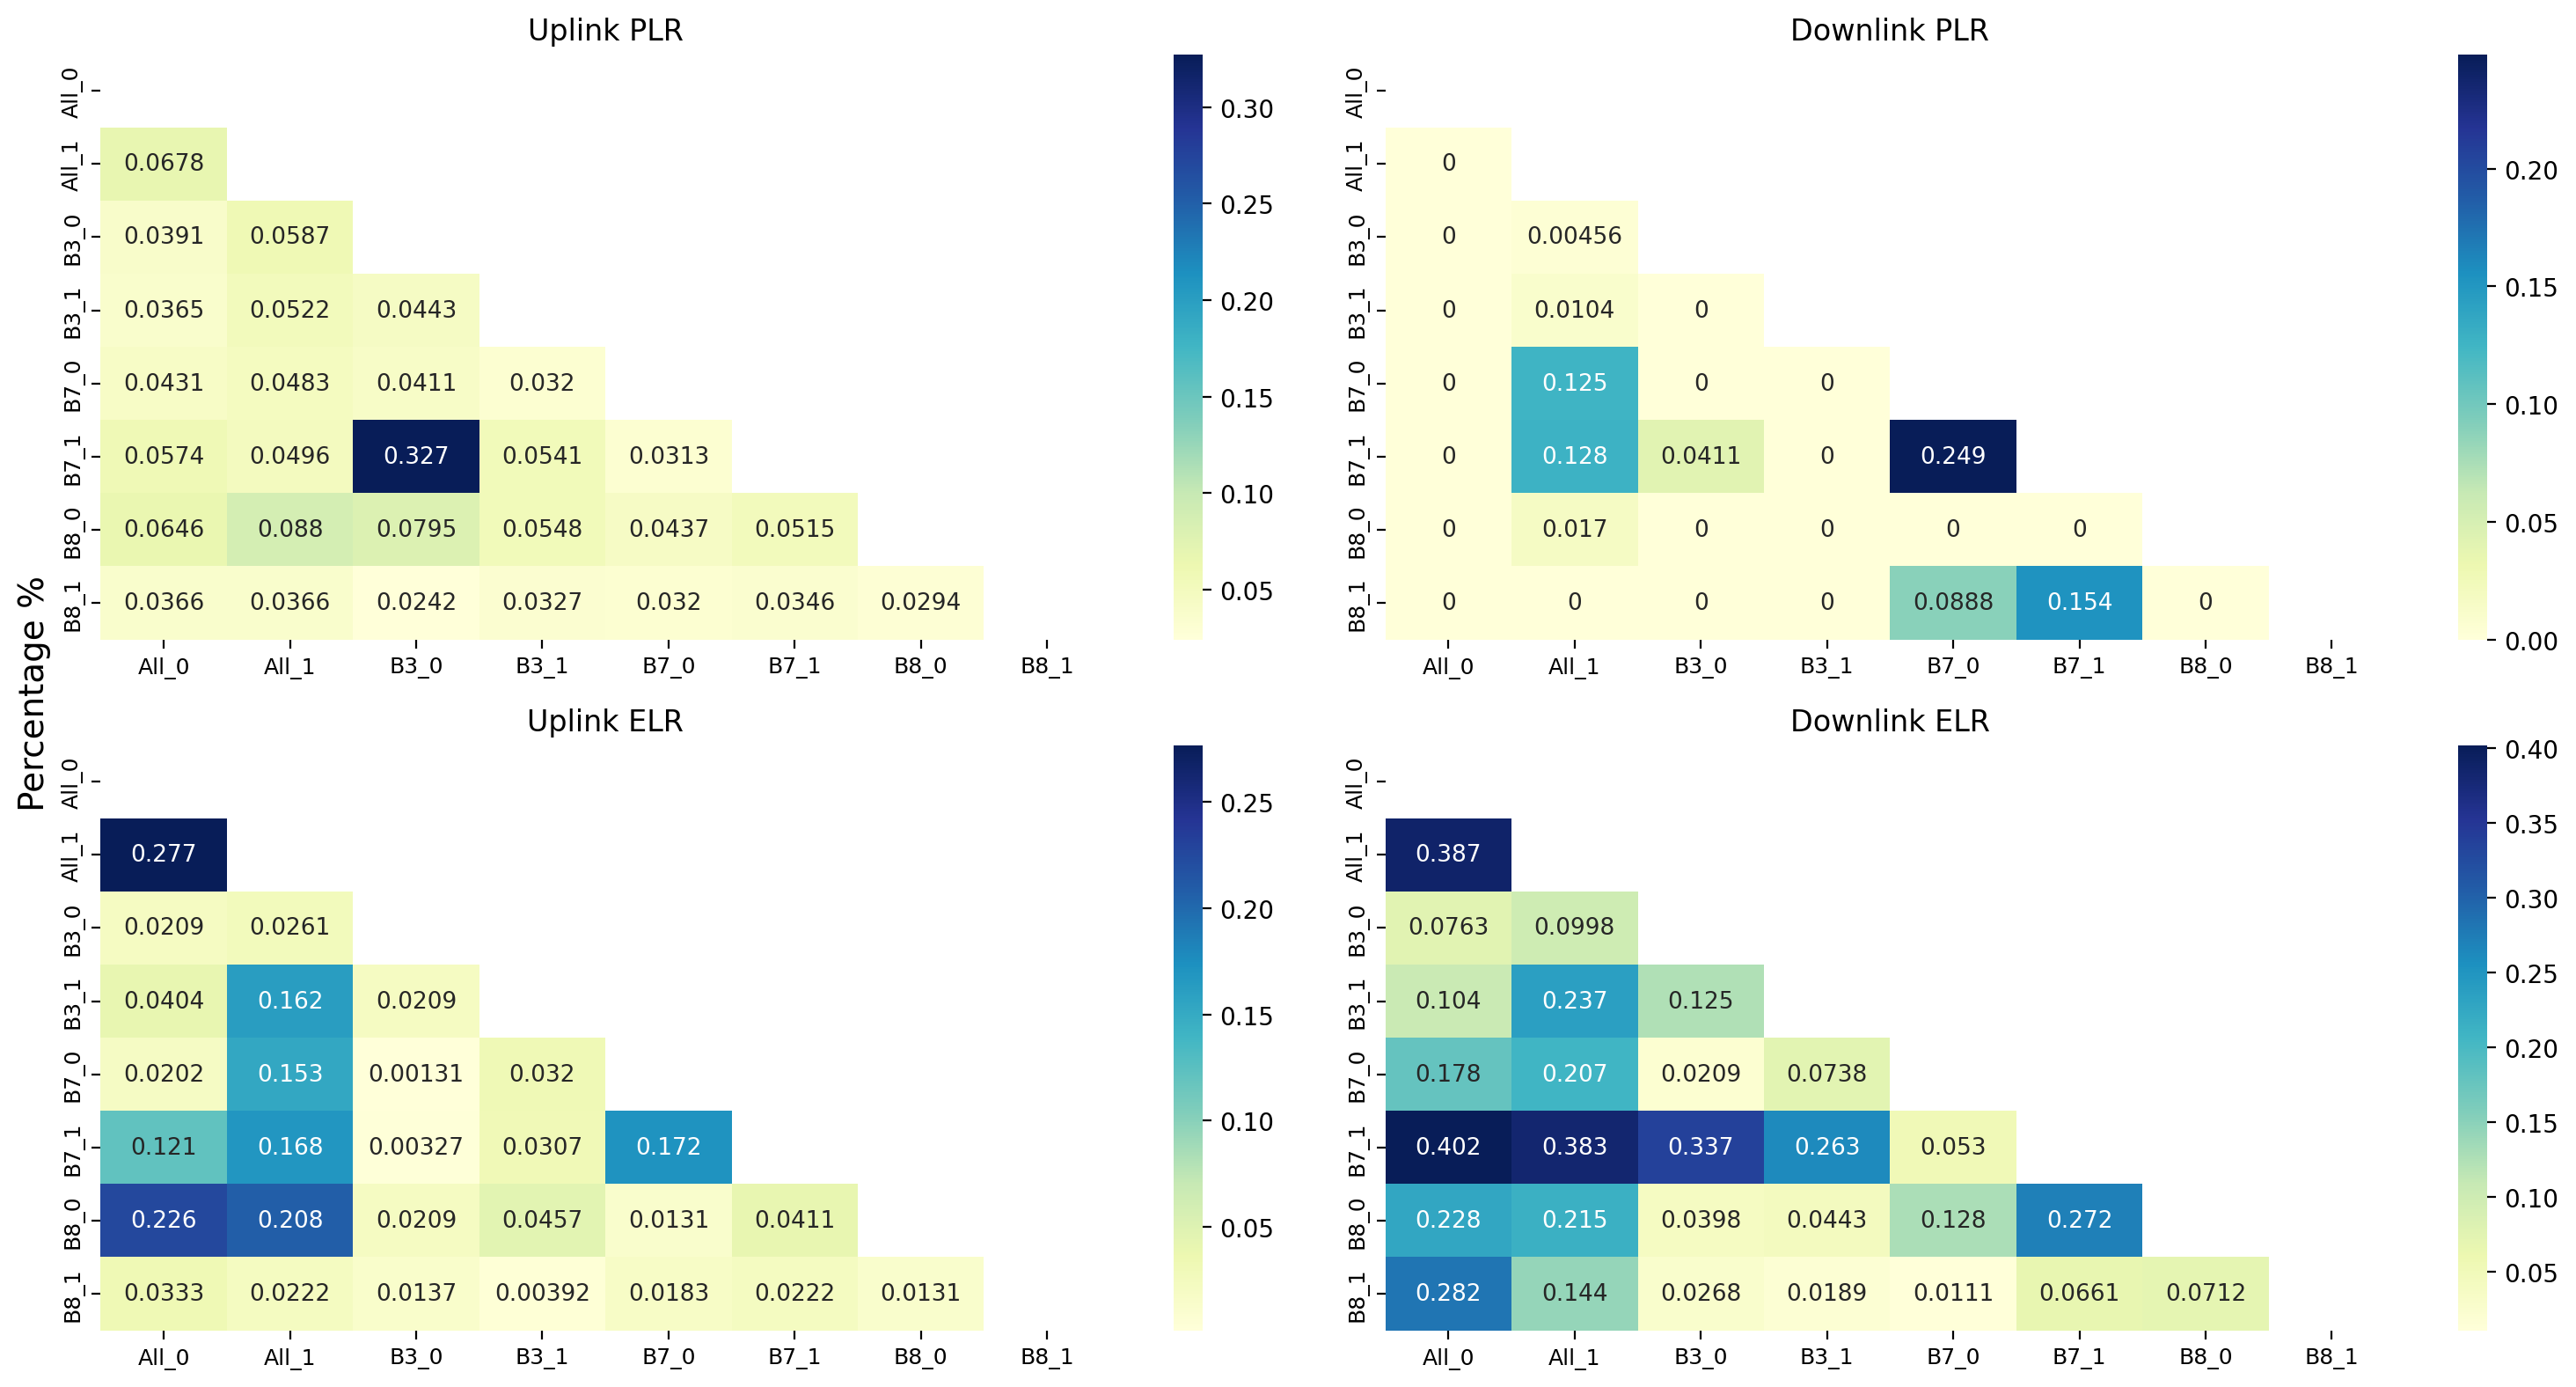

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #04


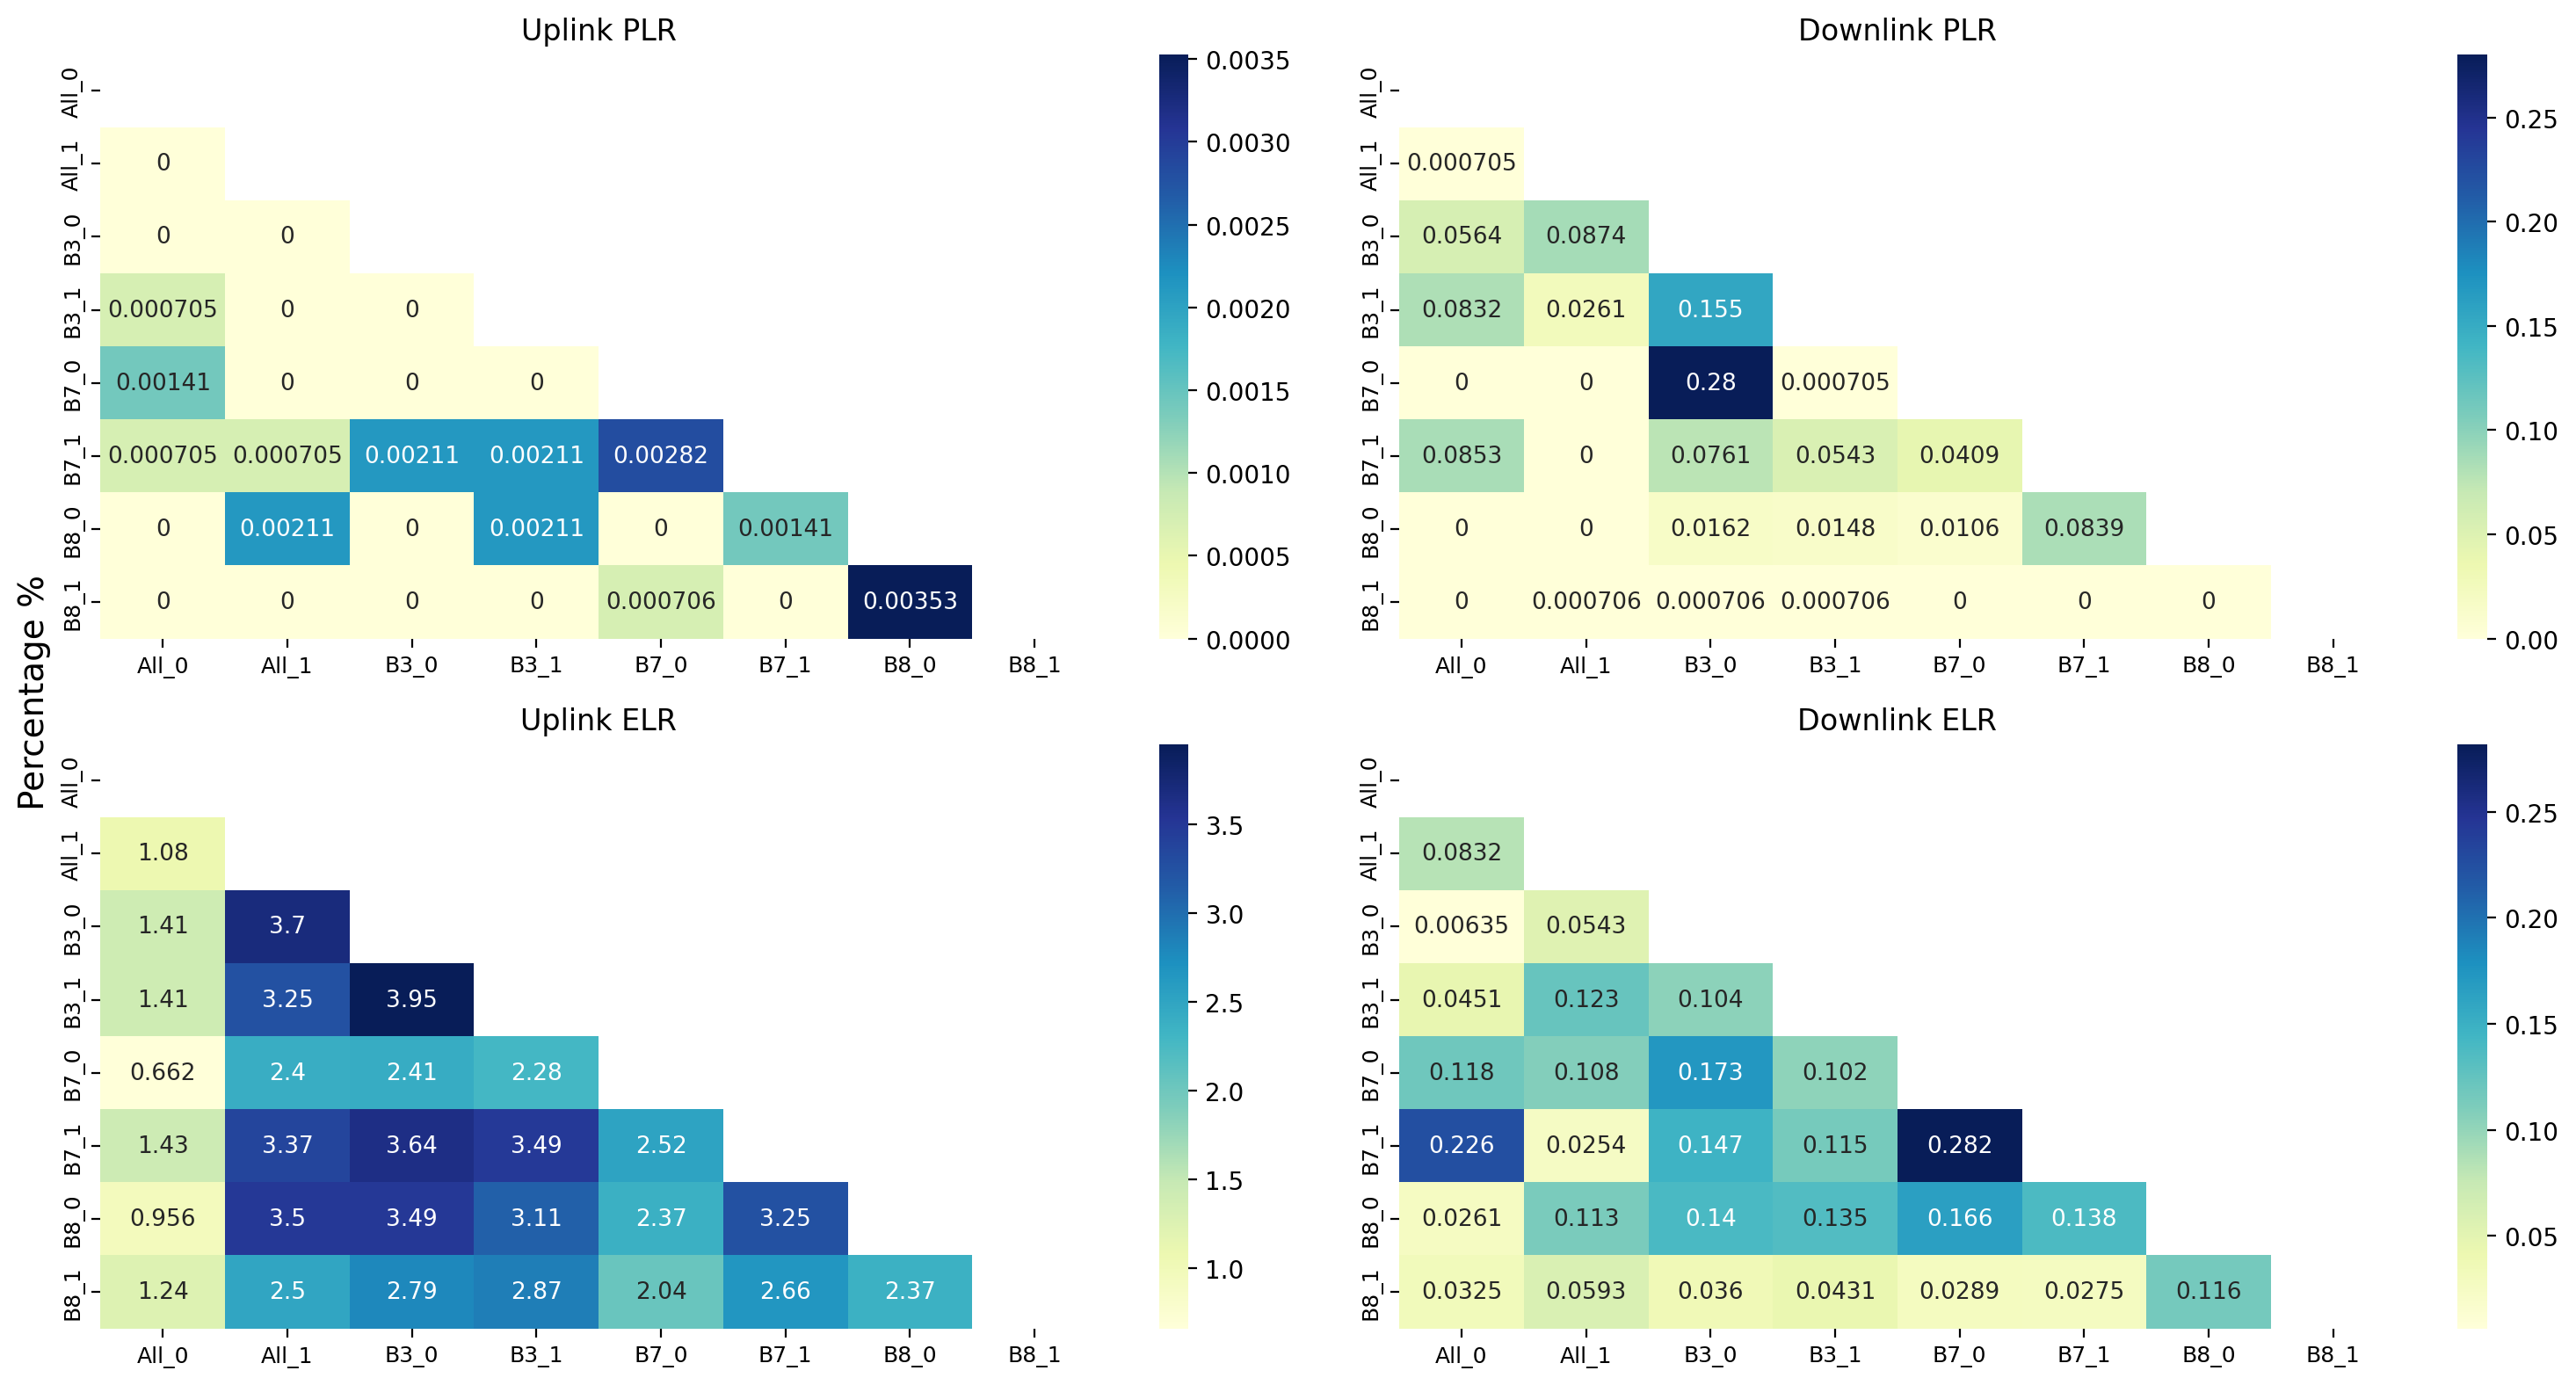

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             5   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             3   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             4   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7       #01, #03, #04, #05, #06     1.278359             7   
6   sm06   B8       #01, #03, #04, #05, #06     1.185786             6   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             2   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             6     0.831878   
5     2.532447             8     2.604340             5     0.461063   
6     1.190465             3     1.640298             3     0.531022   
7     1.476035             4     2.474258             4     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             1  
6             3  
7             4

Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   LTE_0+LTE_1  #01, #02, #03, #04, #05, #06     0.799353            11   
1    LTE_0+B3_0  #01, #02, #03, #04, #05, #06     0.792909             3   
2    LTE_0+B3_1  #01, #02, #03, #04, #05, #06     0.793947             5   
3    LTE_0+B7_0  #01, #02, #03, #04, #05, #06     0.792712             2   
4    LTE_0+B7_1       #01, #03, #04, #05, #06     0.951510            20   
5    LTE_0+B8_0       #01, #03, #04, #05, #06     0.949237            16   
6    LTE_0+B8_1  #01, #02, #03, #04, #05, #06     0.798440            10   
7    LTE_1+B3_0  #01, #02, #03, #04, #05, #06     0.795283             8   
8    LTE_1+B3_1  #01, #02, #03, #04, #05, #06     0.793711             4   
9    LTE_1+B7_0  #01, #02, #03, #04, #05, #06     0.808278            13   
10   LTE_1+B7_1       #01, #03, #04, #05, #06     0.955717            26   
11   LTE_1+B8_0       #01, #03, #04, #05, #06     0.955204            25   
12   LTE_1+B8_1  #01, #02, #03, #04, #05, #06     0.798366             9   
13    B3_0+B3_1  #01, #02, #03, #04, #05, #06     0.801080            12   
14    B3_0+B7_0  #01, #02, #03, #04, #05, #06     0.811982            15   
15    B3_0+B7_1       #01, #03, #04, #05, #06     0.957650            27   
16    B3_0+B8_0       #01, #03, #04, #05, #06     0.950611            18   
17    B3_0+B8_1  #01, #02, #03, #04, #05, #06     0.794188             7   
18    B3_1+B7_0  #01, #02, #03, #04, #05, #06     0.794039             6   
19    B3_1+B7_1       #01, #03, #04, #05, #06     0.953878            23   
20    B3_1+B8_0       #01, #03, #04, #05, #06     0.951018            19   
21    B3_1+B8_1  #01, #02, #03, #04, #05, #06     0.792049             1   
22    B7_0+B7_1       #01, #03, #04, #05, #06     0.989299            28   
23    B7_0+B8_0       #01, #03, #04, #05, #06     0.954692            24   
24    B7_0+B8_1  #01, #02, #03, #04, #05, #06     0.811029            14   
25    B7_1+B8_0       #01, #03, #04, #05, #06     0.953738            22   
26    B7_1+B8_1       #01, #03, #04, #05, #06     0.949414            17   
27    B8_0+B8_1       #01, #03, #04, #05, #06     0.952265            21   

    avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0      0.792646             1     0.028843             3     0.294806   
1      0.792950             3     0.039773             5     0.044183   
2      0.792854             2     0.048648             6     0.046718   
3      0.798591             5     0.082327             7     0.227947   
4      0.951220            10     0.024165             2     0.142134   
5      0.951470            11     0.032411             4     0.016132   
6      0.795002             4     0.022611             1     0.068341   
7      0.875096             6     0.197426            12     0.023538   
8      0.893729             8     0.187152            11     0.014780   
9      0.900598             9     0.170452            10     0.095096   
10     1.084260            23     0.230328            13     0.073510   
11     0.953761            12     0.112465             8     0.023326   
12     0.887442             7     0.131847             9     0.020412   
13     1.086348            24     2.813977            28     0.135948   
14     0.998914            19     1.823793            27     0.291474   
15     1.175339            25     1.384540            22     0.087777   
16     0.978195            15     1.137209            19     0.083050   
17     1.036675            21     1.556509            25     0.062557   
18     0.982675            17     1.546468            24     0.118466   
19     1.218258            26     1.538249            23     0.094161   
20     0.983505            18     1.160644            20     0.125751   
21     1.024718            20     1.689115            26     0.107599   
22     1.320688            28     0.729845            15     0.083088   
23     0.954165            13     0.527476            

Uplink PLR Ranking:


sm00  sm01 sm02 sm03 sm04  sm05  sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0  B7_1  B8_0 B8_1
#01         5     3    6    8    4     7     1    2
#02         2     1    3    4    6  <NA>  <NA>    5
#03         1     2    7    3    5     4     6    8
#04         1     7    4    3    8     6     2    5
#05         2     4    7    6    8     5     3    1
#06         2     1    3    7    4     8     5    6
Score       7     4   -2   -3   -6    -3     3    0
Ranking     4     3    6    8    7     5     2    1

LTE_0+LTE_1  LTE_0+B3_0  LTE_0+B3_1  LTE_0+B7_0  LTE_0+B7_1  \
#01             22.0        25.0        16.0        14.0         8.0   
#02              1.0         2.0         3.0         4.0         NaN   
#03              1.0         2.0         3.0         4.0         5.0   
#04             21.0         1.0        10.0         7.0        14.0   
#05             16.0         8.0        10.0         7.0        11.0   
#06              1.0         2.0         3.0         4.0         5.0   
Score            9.0         9.0         3.0         0.0         0.0   
Ranking          1.0         2.0         3.0         8.0         9.0   

         LTE_0+B8_0  LTE_0+B8_1  LTE_1+B3_0  LTE_1+B3_1  LTE_1+B7_0  \
#01            13.0        10.0        26.0        17.0        28.0   
#02             NaN         5.0        13.0         6.0         7.0   
#03             6.0         7.0         8.0         9.0        10.0   
#04             5.0         8.0        16.0        22.0        25.0   
#05             5.0        27.0         3.0         1.0         6.0   
#06             6.0         7.0         8.0         9.0        10.0   
Score           0.0        -1.0        -3.0         3.0        -3.0   
Ranking        10.0        19.0        22.0         4.0        23.0   

         LTE_1+B7_1  LTE_1+B8_0  LTE_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            20.0        18.0        15.0       27.0       23.0       21.0   
#02             NaN         NaN         8.0        9.0       14.0        NaN   
#03            11.0        12.0        13.0       14.0       15.0       28.0   
#04            23.0        24.0        19.0        2.0       27.0        6.0   
#05             4.0         2.0        25.0       28.0       26.0       24.0   
#06            11.0        12.0        13.0       28.0       14.0       15.0   
Score           0.0         2.0         0.0       -5.0       -4.0       -3.0   
Ranking        11.0         6.0        12.0       27.0       26.0       24.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            1.0       11.0        7.0        6.0        4.0       12.0   
#02            NaN       10.0       11.0        NaN        NaN       12.0   
#03           16.0       17.0       18.0       19.0       20.0       21.0   
#04           11.0       13.0       17.0       15.0        9.0        3.0   
#05           22.0       17.0       15.0       23.0       19.0       13.0   
#06           16.0       27.0       17.0       18.0       25.0       19.0   
Score          3.0       -1.0        0.0        0.0        0.0        1.0   
Ranking        5.0       20.0       13.0       14.0       15.0        7.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           24.0        9.0        5.0       19.0        2.0        3.0  
#02            NaN        NaN       15.0        NaN        NaN        NaN  
#03           22.0       23.0       24.0       25.0       26.0       27.0  
#04           28.0       18.0       26.0       12.0        4.0       20.0  
#05           12.0       20.0       21.0       14.0       18.0        9.0  
#06           20.0       21.0       22.0       23.0       26.0       24.0  
Score         -3.0        0.0       -5.0        0.0       -2.0        0.0  
Ranking       25.0       16.0       28.0       17.0       21.0       18.0

Downlink PLR Ranking:


sm00  sm01 sm02 sm03 sm04  sm05  sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0  B7_1  B8_0 B8_1
#01         1     2    4    7    6     8     3    5
#02         1     2    5    3    6  <NA>  <NA>    4
#03         1     2    7    5    6     8     4    3
#04         1     5    4    6    7     8     2    3
#05         2     1    3    4    8     7     6    5
#06         1     2    7    6    4     8     3    5
Score      11     6   -3   -1   -5    -9     1    0
Ranking     4     3    8    7    5     6     2    1

LTE_0+LTE_1  LTE_0+B3_0  LTE_0+B3_1  LTE_0+B7_0  LTE_0+B7_1  \
#01              1.0         2.0         3.0         4.0         5.0   
#02              1.0         2.0         3.0         4.0         NaN   
#03              1.0         2.0         3.0         4.0         5.0   
#04              1.0         2.0         3.0         4.0         5.0   
#05              1.0         5.0         3.0        22.0         2.0   
#06              1.0         2.0         3.0         4.0         5.0   
Score           18.0        10.0         6.0         0.0         2.0   
Ranking          1.0         2.0         3.0         5.0         4.0   

         LTE_0+B8_0  LTE_0+B8_1  LTE_1+B3_0  LTE_1+B3_1  LTE_1+B7_0  \
#01             6.0         7.0         8.0         9.0        10.0   
#02             NaN         5.0         6.0         7.0         8.0   
#03             6.0         7.0         8.0         9.0        10.0   
#04             6.0         7.0        15.0        23.0        26.0   
#05             4.0        13.0        11.0         8.0         9.0   
#06             6.0         7.0         8.0         9.0        10.0   
Score           0.0         0.0         0.0         0.0        -2.0   
Ranking         6.0         7.0         8.0         9.0        19.0   

         LTE_1+B7_1  LTE_1+B8_0  LTE_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            11.0        12.0        13.0       25.0       14.0       22.0   
#02             NaN         NaN         9.0       14.0       15.0        NaN   
#03            11.0        12.0        13.0       24.0       25.0       28.0   
#04            27.0         8.0        19.0       24.0       16.0       25.0   
#05             6.0        10.0        17.0       23.0       14.0        7.0   
#06            11.0        12.0        13.0       25.0       17.0       23.0   
Score          -1.0         0.0         0.0       -1.0       -3.0       -3.0   
Ranking        15.0        10.0        11.0       16.0       24.0       25.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01           15.0       16.0       17.0       24.0       18.0       19.0   
#02            NaN       10.0       12.0        NaN        NaN       11.0   
#03           22.0       20.0       26.0       14.0       15.0       21.0   
#04            9.0       14.0       20.0       21.0       10.0       22.0   
#05           12.0       19.0       15.0       24.0       27.0       20.0   
#06           21.0       28.0       19.0       27.0       22.0       26.0   
Score          0.0       -3.0       -2.0       -1.0       -1.0       -2.0   
Ranking       12.0       26.0       20.0       17.0       18.0       21.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           28.0       20.0       26.0       21.0       27.0       23.0  
#02            NaN        NaN       13.0        NaN        NaN        NaN  
#03           16.0       17.0       18.0       23.0       27.0       19.0  
#04           28.0       11.0       17.0       12.0       18.0       13.0  
#05           28.0       16.0       21.0       26.0       18.0       25.0  
#06           14.0       15.0       16.0       18.0       24.0       20.0  
Score         -9.0        0.0       -4.0       -2.0       -2.0        0.0  
Ranking       28.0       13.0       27.0       22.0       23.0       14.0

Uplink ELR Ranking:


sm00  sm01 sm02 sm03 sm04  sm05  sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0  B7_1  B8_0 B8_1
#01         5     6    3    7    4     8     1    2
#02         1     2    6    5    3  <NA>  <NA>    4
#03         1     2    7    5    8     6     4    3
#04         1     2    8    7    3     6     5    4
#05         5     1    8    3    7     6     2    4
#06         8     1    5    7    2     4     6    3
Score       4     7   -7   -4   -2    -2     3    1
Ranking     4     3    5    6    7     8     1    2

LTE_0+LTE_1  LTE_0+B3_0  LTE_0+B3_1  LTE_0+B7_0  LTE_0+B7_1  \
#01             24.0        22.0        23.0        20.0        15.0   
#02              1.0         2.0         5.0         3.0         NaN   
#03              1.0         2.0        15.0        10.0        11.0   
#04              3.0         7.0         5.0         6.0         2.0   
#05              1.0        13.0         2.0        28.0        16.0   
#06             11.0         5.0        12.0         2.0         3.0   
Score           10.0         4.0         2.0         0.0         3.0   
Ranking          1.0         2.0         6.0        11.0         4.0   

         LTE_0+B8_0  LTE_0+B8_1  LTE_1+B3_0  LTE_1+B3_1  LTE_1+B7_0  \
#01             3.0        10.0        16.0        11.0        21.0   
#02             NaN         4.0         7.0         9.0         6.0   
#03             7.0        13.0         4.0         6.0        16.0   
#04             4.0         1.0        13.0        12.0        10.0   
#05             5.0         6.0         4.0         8.0         3.0   
#06             9.0         4.0        13.0         7.0         1.0   
Score           1.0         3.0         0.0         0.0         4.0   
Ranking         9.0         5.0        12.0        13.0         3.0   

         LTE_1+B7_1  LTE_1+B8_0  LTE_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            19.0        17.0        13.0       27.0       14.0        8.0   
#02             NaN         NaN         8.0       15.0       13.0        NaN   
#03            21.0         5.0         3.0        9.0       28.0       25.0   
#04            11.0         8.0         9.0       28.0       16.0       26.0   
#05             9.0        14.0         7.0       27.0       18.0       25.0   
#06             6.0         8.0        10.0       26.0       14.0       21.0   
Score           0.0         0.0         1.0      -10.0       -5.0       -2.0   
Ranking        14.0        15.0        10.0       28.0       27.0       22.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            1.0       18.0        9.0        6.0        7.0       12.0   
#02            NaN       11.0       14.0        NaN        NaN       12.0   
#03            8.0       23.0       20.0       27.0       12.0       17.0   
#04           22.0       23.0       18.0       27.0       21.0       24.0   
#05           19.0       11.0       21.0       26.0       10.0       12.0   
#06           27.0       18.0       19.0       23.0       28.0       24.0   
Score          2.0        0.0       -1.0       -4.0       -3.0        0.0   
Ranking        7.0       16.0       21.0       25.0       23.0       17.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           26.0        2.0       25.0        5.0       28.0        4.0  
#02            NaN        NaN       10.0        NaN        NaN        NaN  
#03           26.0       19.0       24.0       18.0       14.0       22.0  
#04           17.0       14.0       15.0       20.0       25.0       19.0  
#05           24.0       17.0       22.0       20.0       23.0       15.0  
#06           16.0       17.0       15.0       25.0       20.0       22.0  
Score         -4.0        2.0        0.0        0.0       -3.0        0.0  
Ranking       26.0        8.0       18.0       19.0       24.0       20.0

Downlink ELR Ranking:


sm00  sm01 sm02 sm03 sm04  sm05  sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0  B7_1  B8_0 B8_1
#01         8     7    5    1    3     6     2    4
#02         5     6    1    3    4  <NA>  <NA>    2
#03         2     6    8    1    7     3     5    4
#04         2     8    7    6    4     3     1    5
#05         8     1    4    5    7     6     2    3
#06         4     2    3    5    7     1     6    8
Score      -3    -2   -1    4   -3     2     4   -1
Ranking     4     1    3    7    2     5     6    8

LTE_0+LTE_1  LTE_0+B3_0  LTE_0+B3_1  LTE_0+B7_0  LTE_0+B7_1  \
#01             25.0         9.0         1.0        28.0        27.0   
#02             15.0         2.0         5.0        10.0         NaN   
#03              1.0        26.0         4.0         8.0         6.0   
#04             27.0         5.0        12.0        22.0        16.0   
#05              8.0         7.0        21.0        28.0        24.0   
#06             21.0         8.0        13.0         1.0         2.0   
Score           -1.0         0.0         3.0        -3.0         1.0   
Ranking         20.0        11.0         3.0        24.0         7.0   

         LTE_0+B8_0  LTE_0+B8_1  LTE_1+B3_0  LTE_1+B3_1  LTE_1+B7_0  \
#01             8.0        26.0        12.0         2.0        23.0   
#02             NaN         4.0         1.0         3.0         9.0   
#03             7.0         9.0        10.0         2.0        16.0   
#04             1.0        13.0        17.0        15.0        28.0   
#05            10.0         9.0         2.0         6.0         1.0   
#06            10.0         6.0        11.0         7.0         3.0   
Score           3.0        -2.0         5.0         5.0         1.0   
Ranking         4.0        22.0         1.0         2.0         8.0   

         LTE_1+B7_1  LTE_1+B8_0  LTE_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            22.0         3.0        11.0       10.0       24.0       18.0   
#02             NaN         NaN         8.0        7.0       12.0        NaN   
#03            24.0        18.0         5.0       13.0       28.0       15.0   
#04            19.0         4.0        11.0       26.0       23.0        7.0   
#05             5.0         3.0         4.0       27.0       14.0       20.0   
#06             4.0         5.0         9.0       23.0       27.0       19.0   
Score           0.0         2.0         0.0       -3.0       -4.0        0.0   
Ranking        12.0         5.0        13.0       25.0       27.0       14.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            4.0       15.0       17.0       13.0       21.0        5.0   
#02            NaN        6.0       13.0        NaN        NaN       11.0   
#03           21.0       17.0       19.0       11.0        3.0       14.0   
#04            9.0       21.0       14.0       20.0       25.0       24.0   
#05           18.0       11.0       13.0       26.0       22.0       25.0   
#06           18.0       15.0       28.0       16.0       24.0       14.0   
Score          0.0        0.0       -5.0       -2.0        1.0        0.0   
Ranking       15.0       16.0       28.0       23.0        9.0       17.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           20.0        6.0       16.0        7.0       19.0       14.0  
#02            NaN        NaN       14.0        NaN        NaN        NaN  
#03           20.0       27.0       25.0       22.0       12.0       23.0  
#04            3.0       18.0        6.0       10.0        8.0        2.0  
#05           23.0       12.0       16.0       15.0       17.0       19.0  
#06           12.0       26.0       22.0       17.0       20.0       25.0  
Score          1.0       -3.0       -1.0        0.0        0.0        2.0  
Ranking       10.0       26.0       21.0       18.0       19.0        6.0

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #01


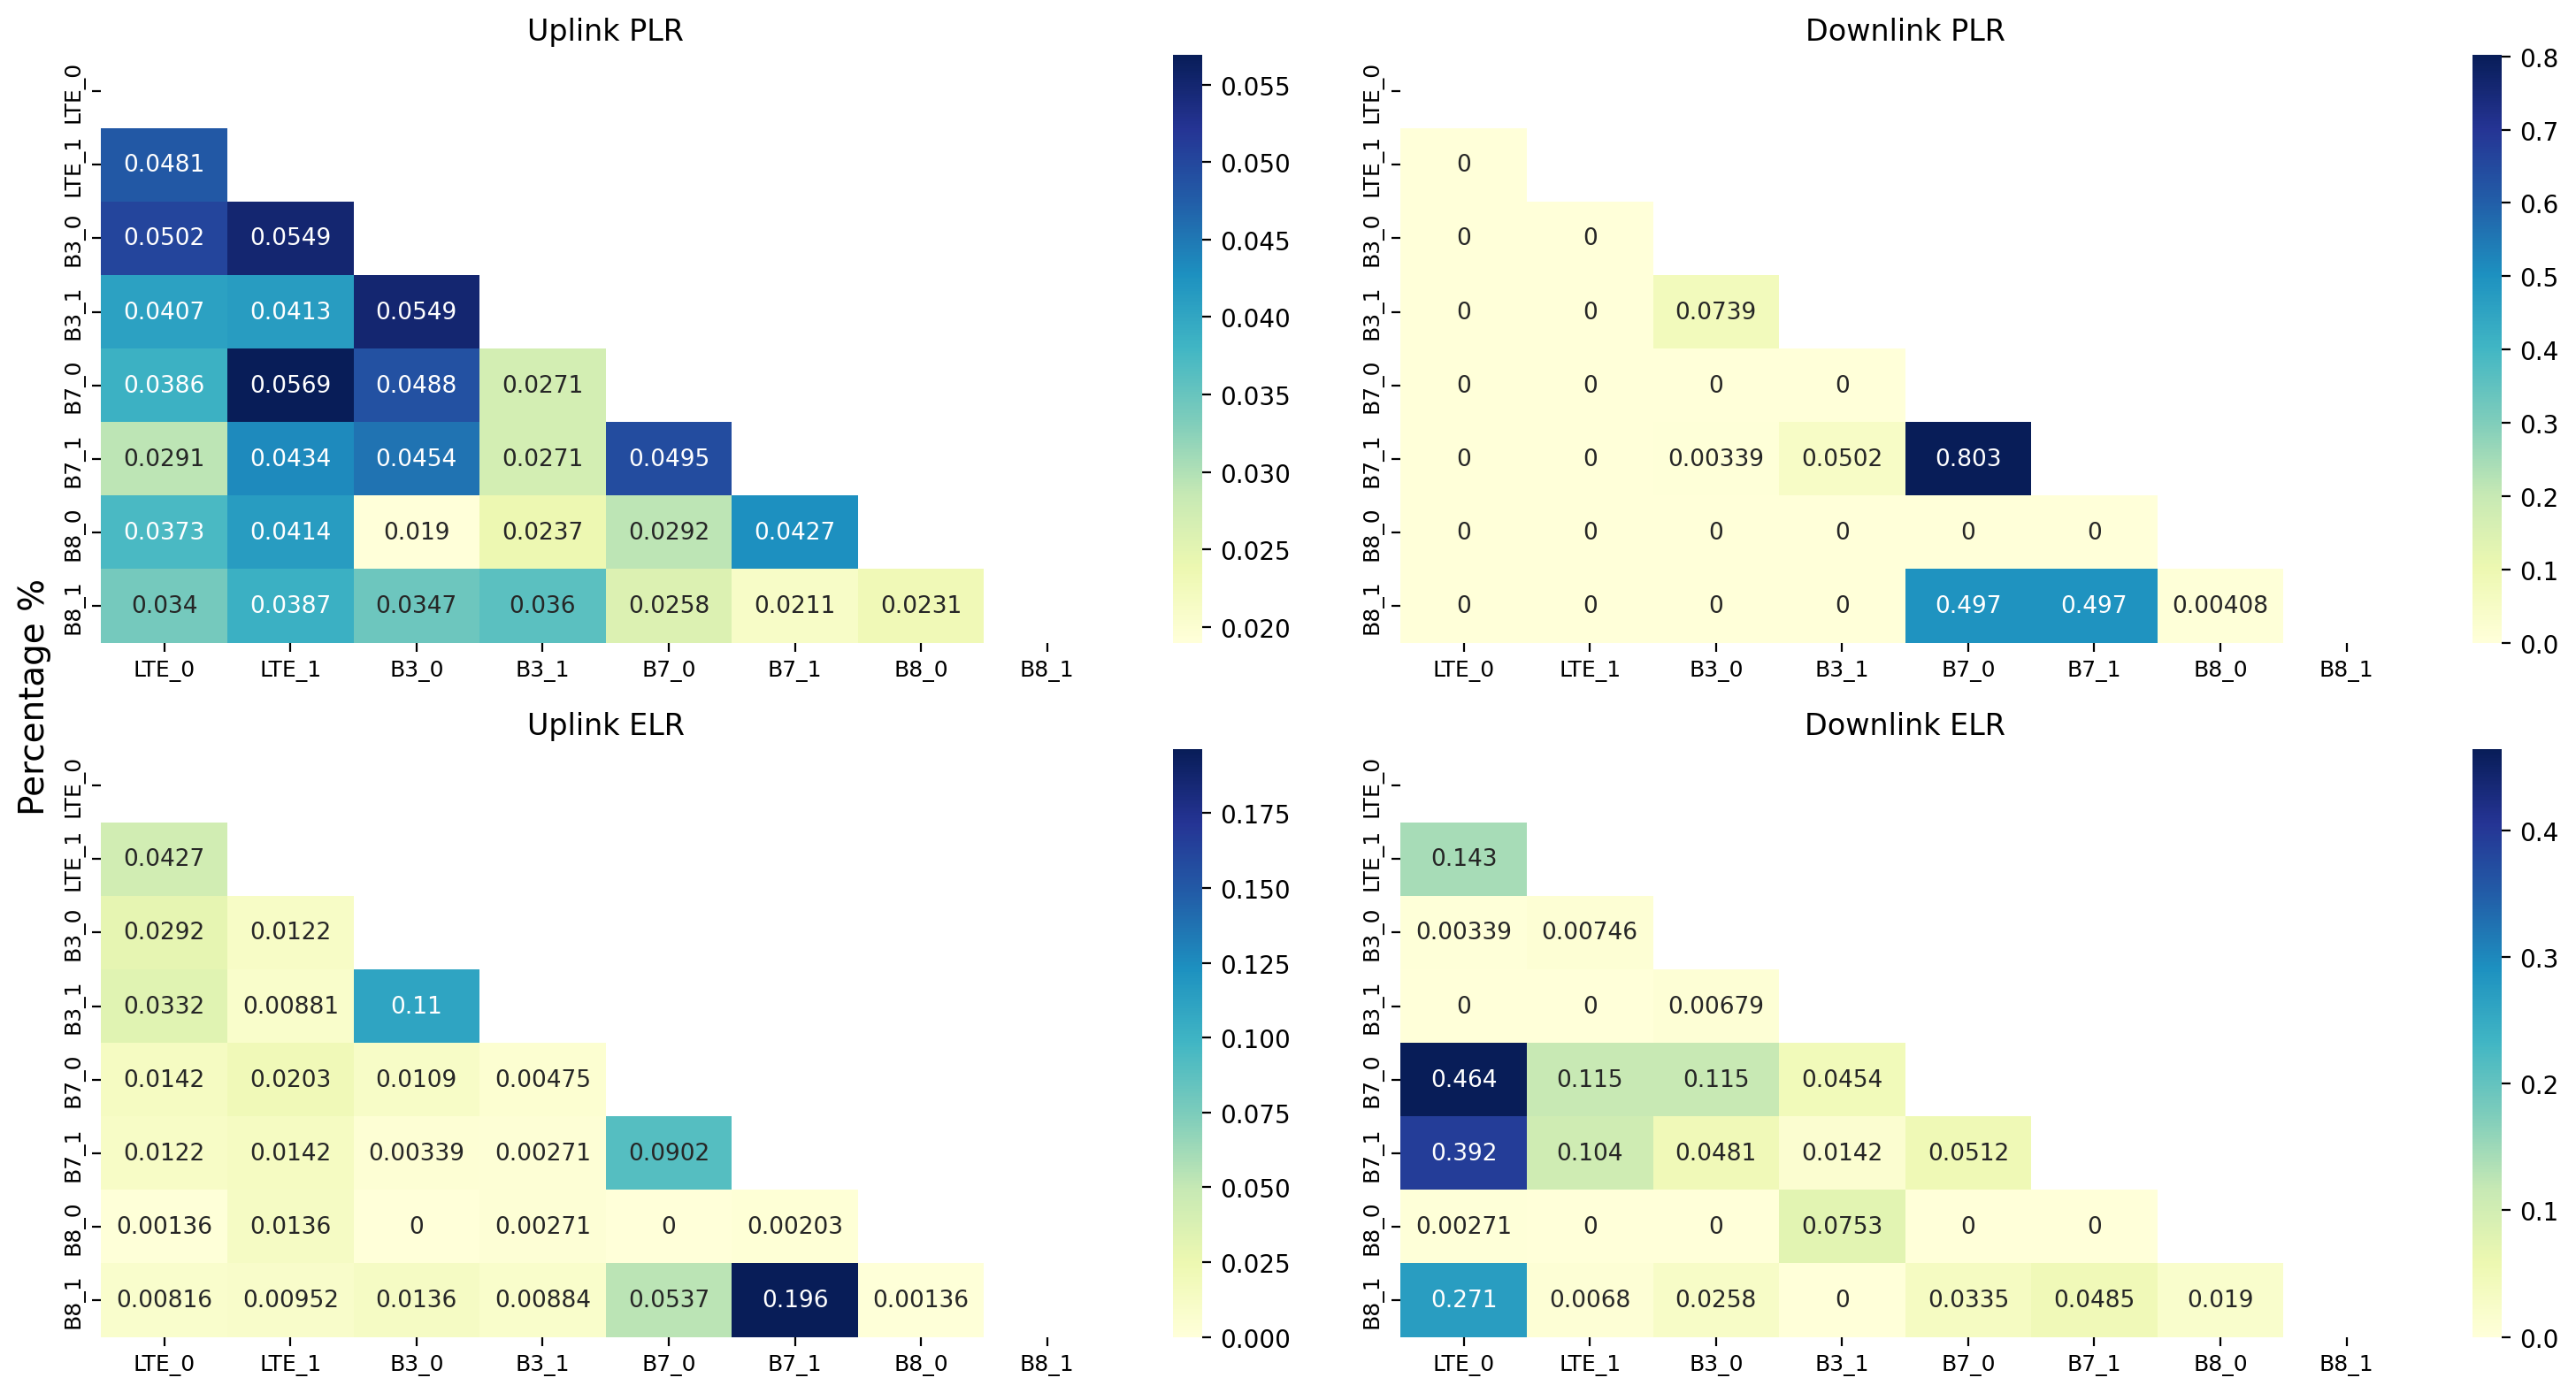

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #02


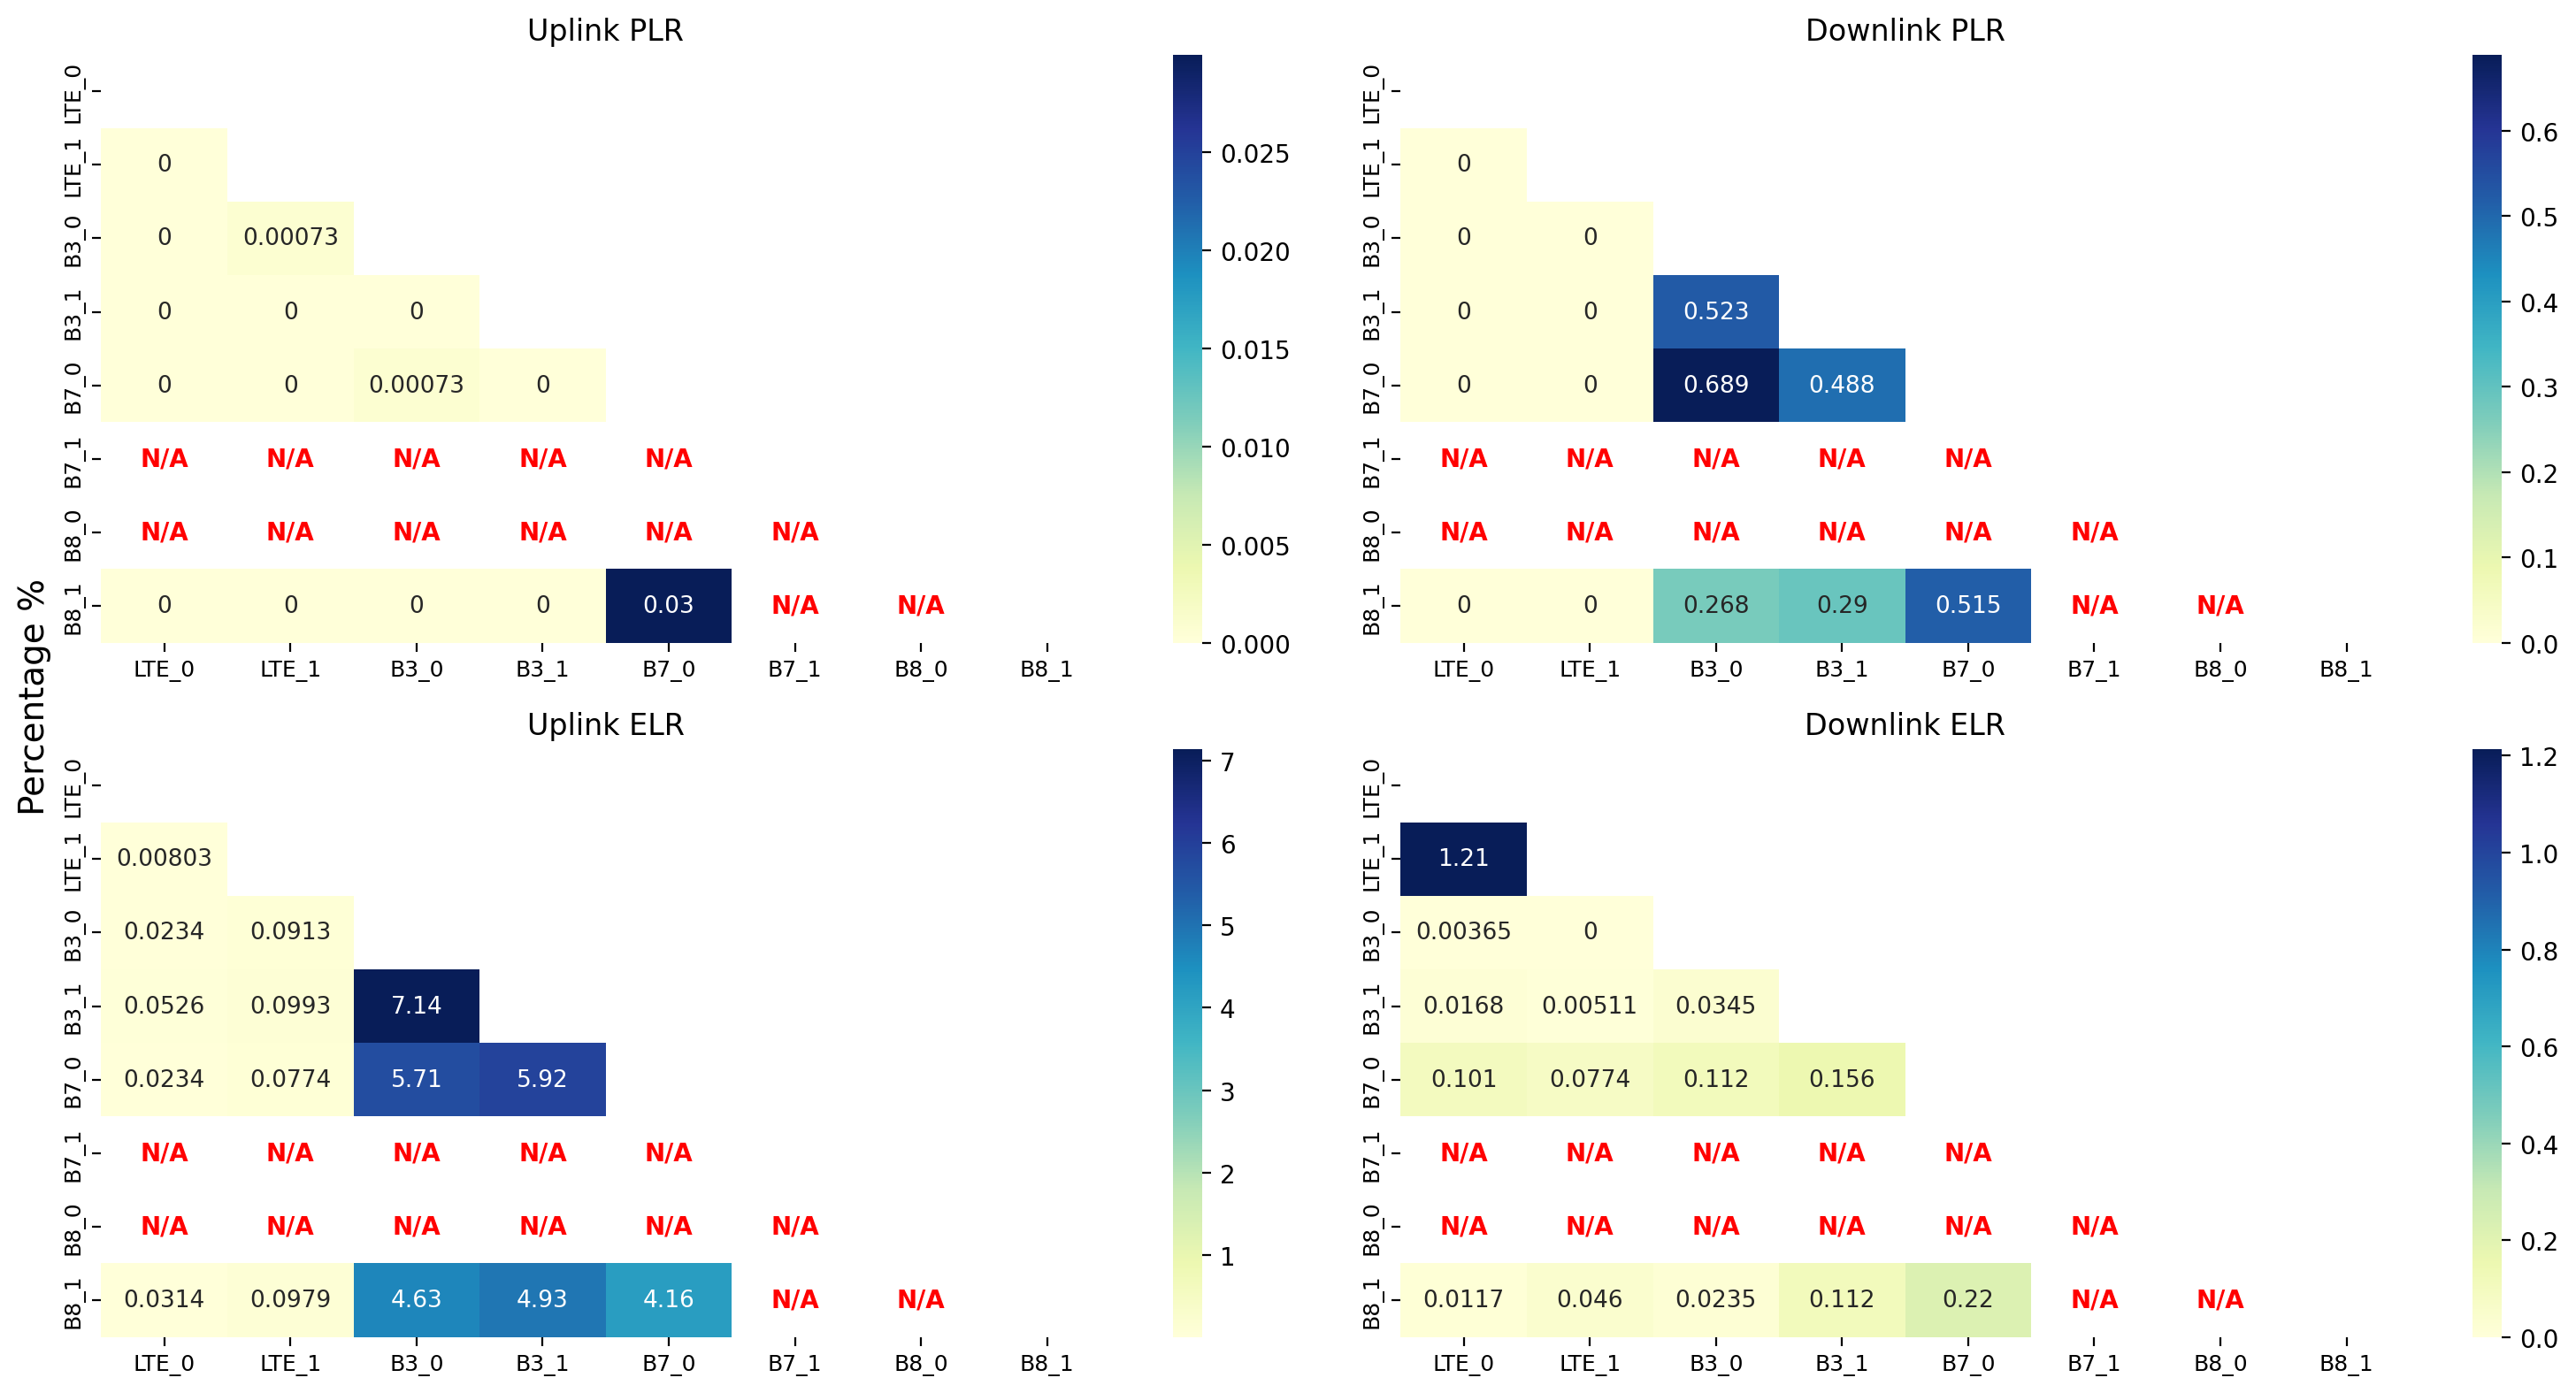

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #03


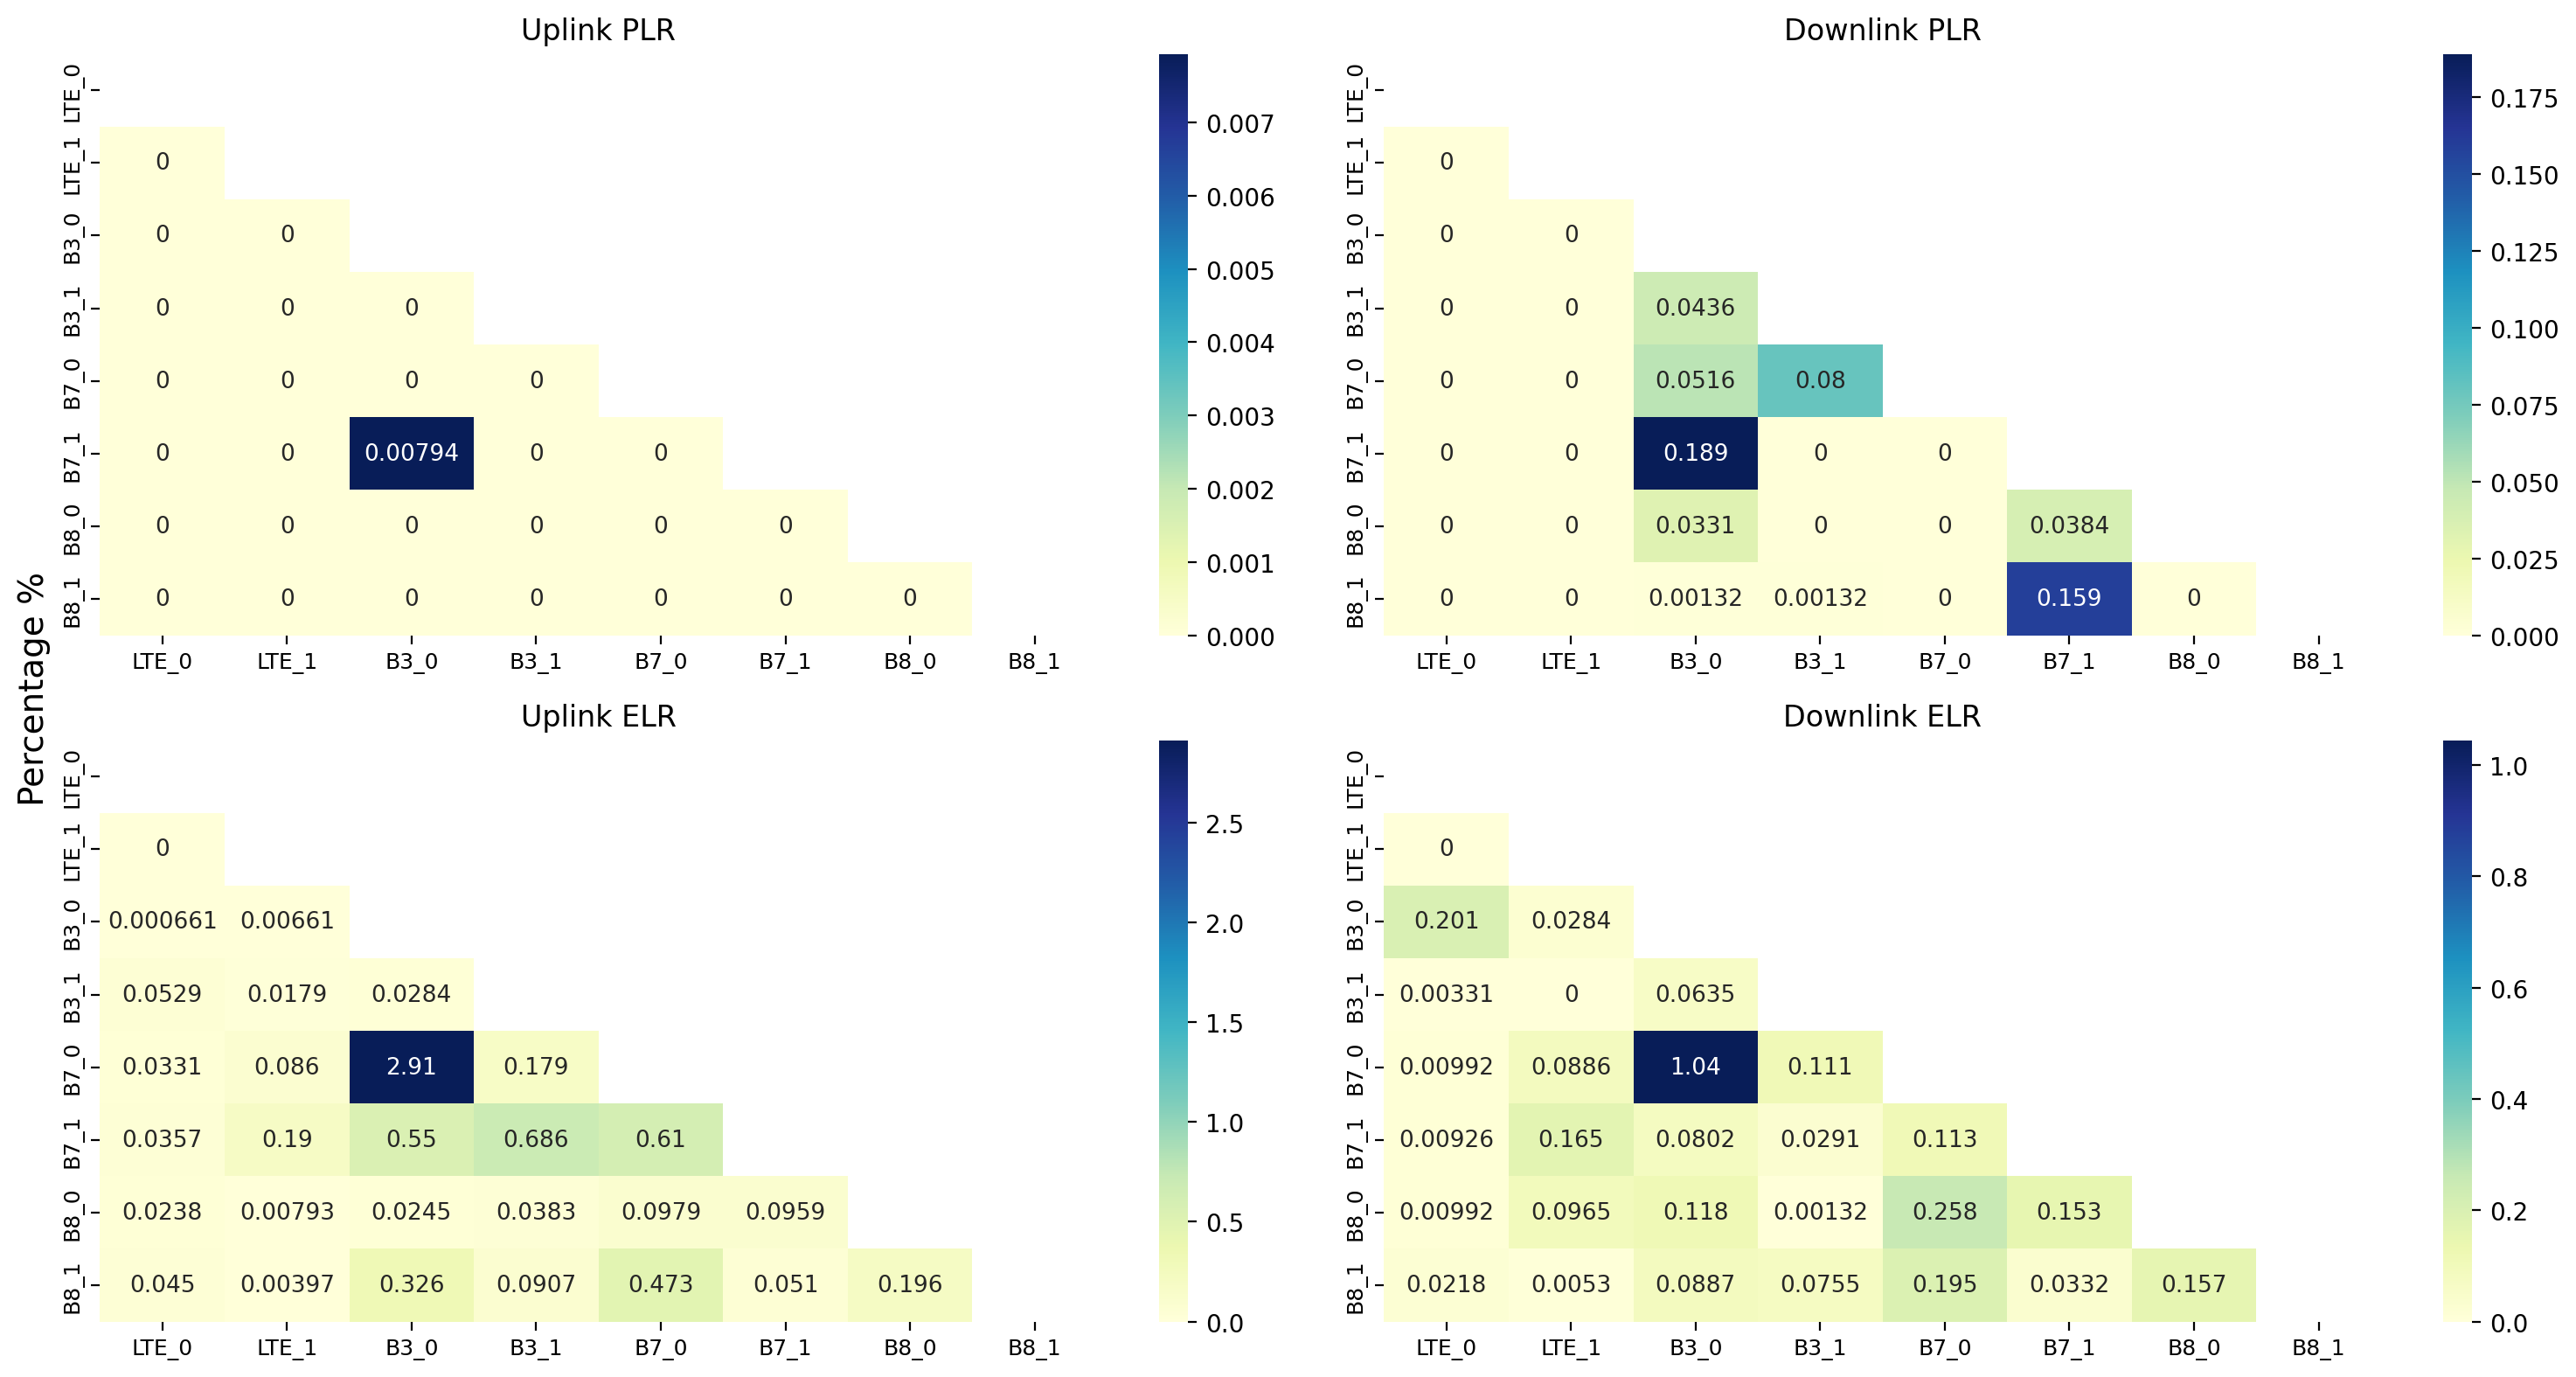

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #04


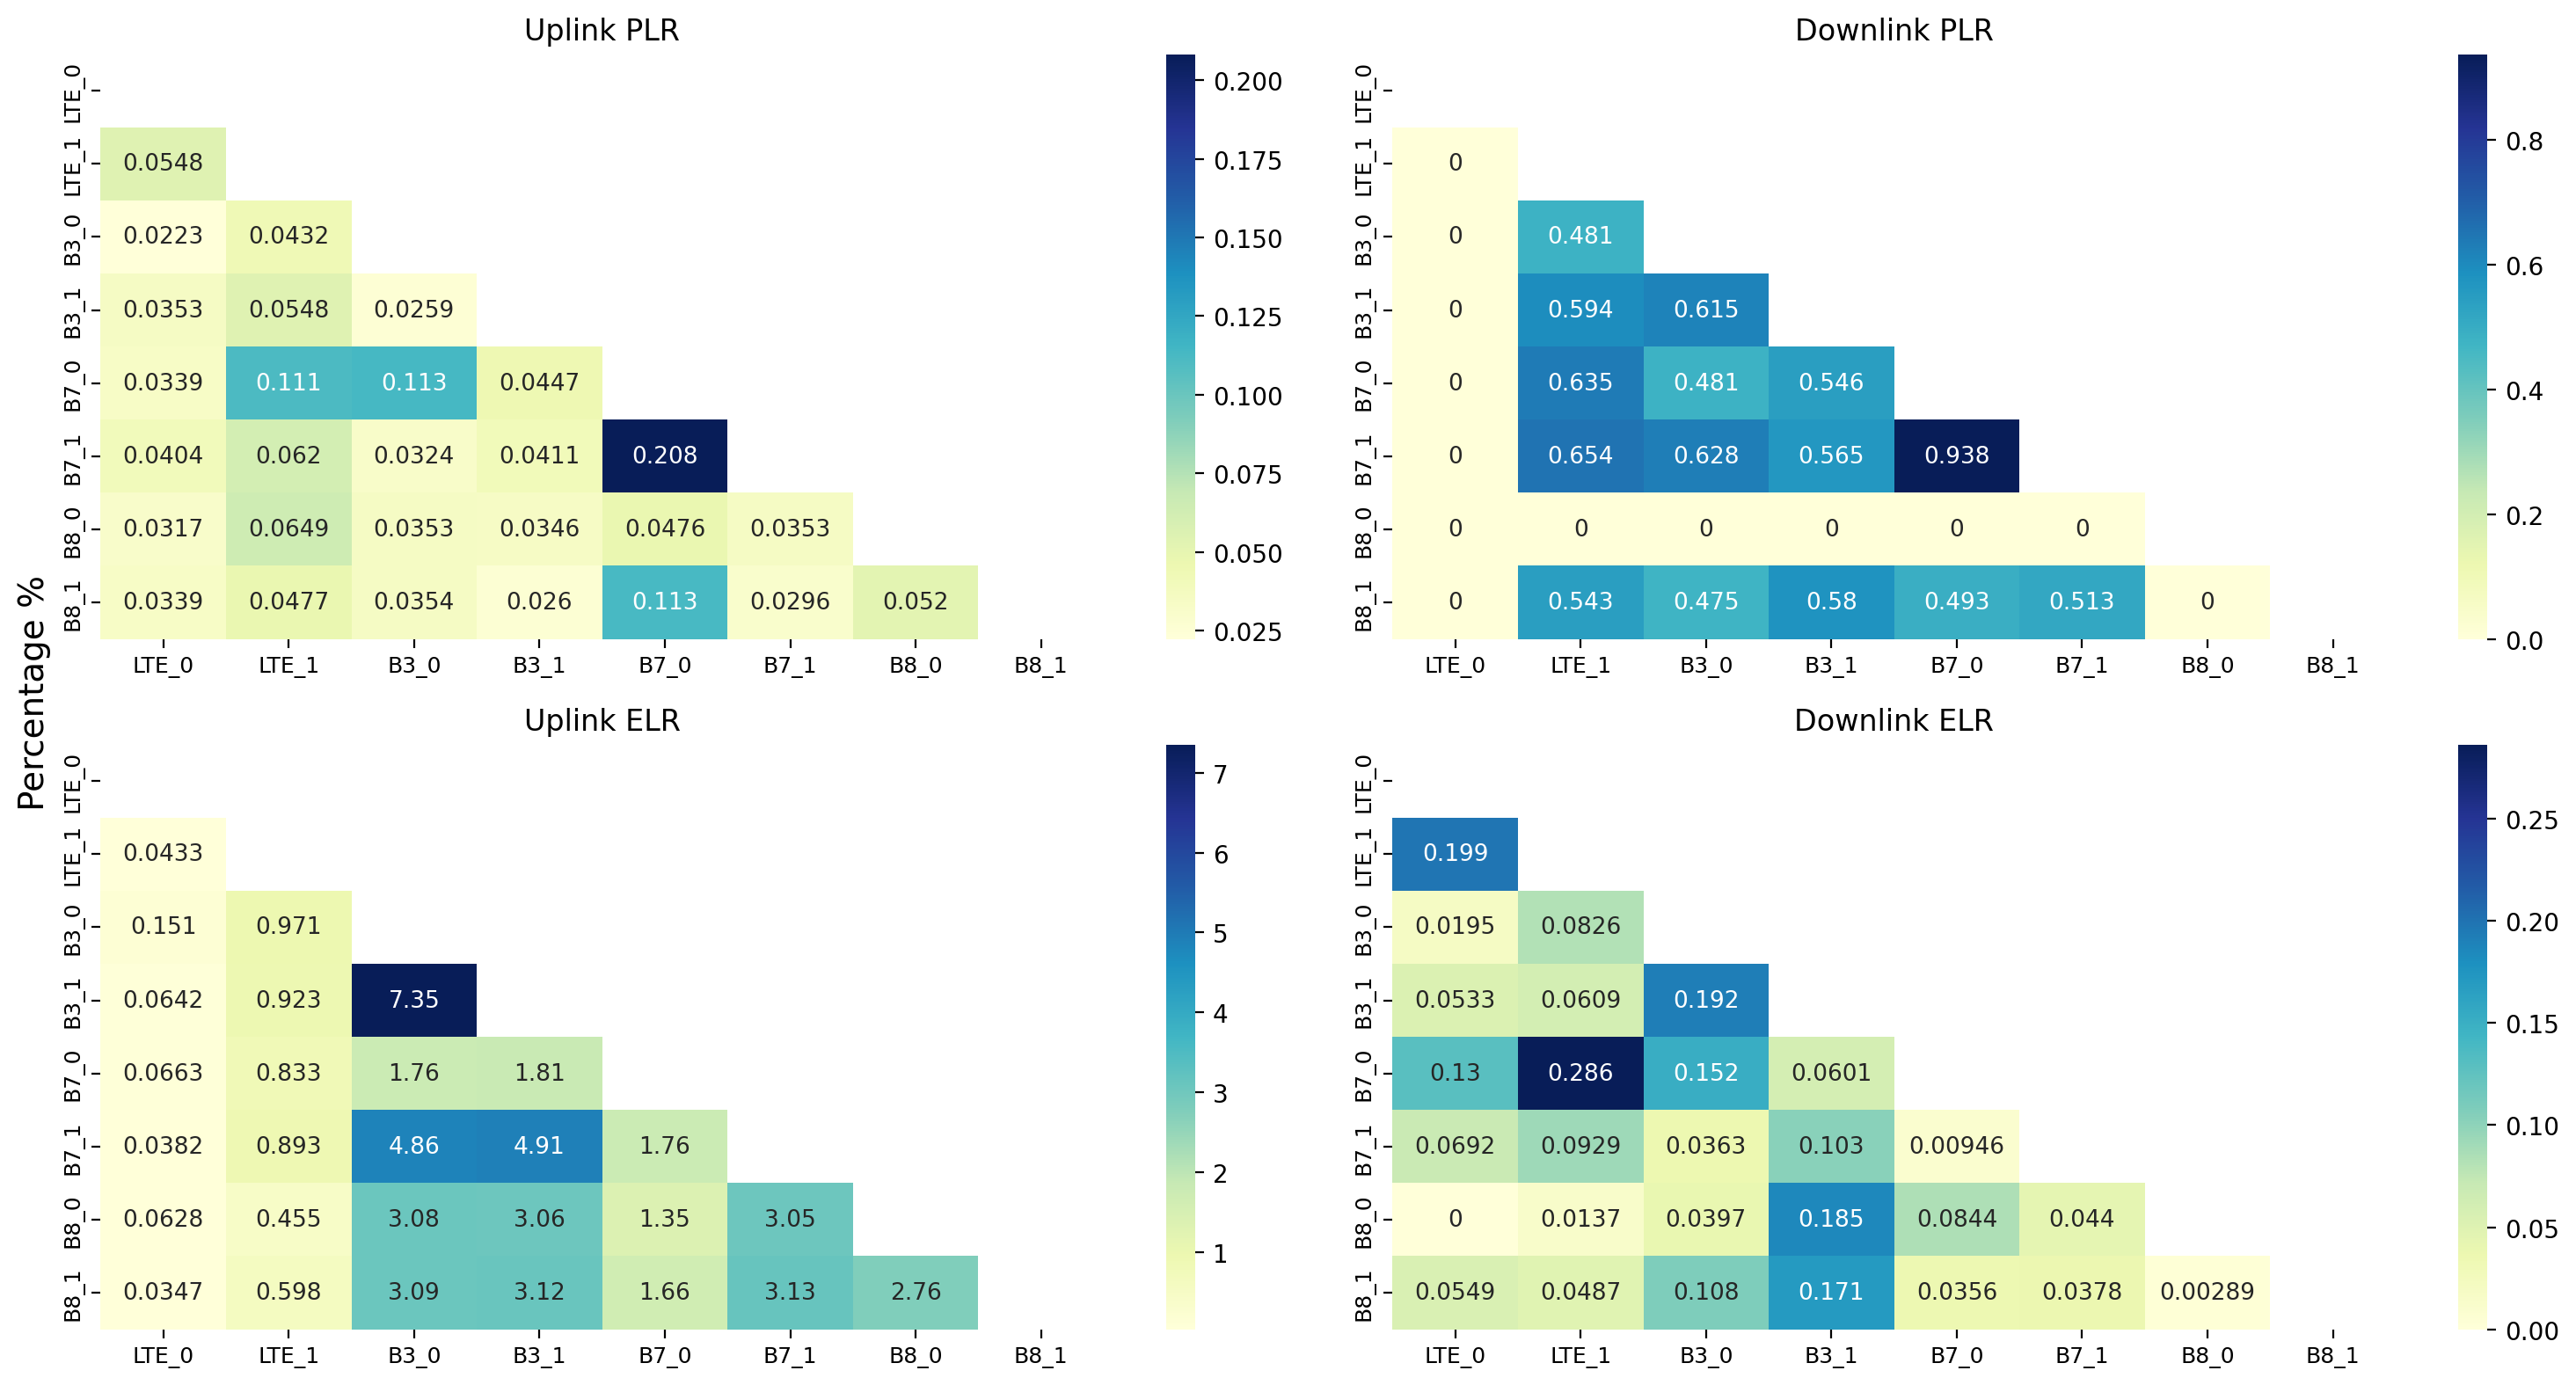

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #05


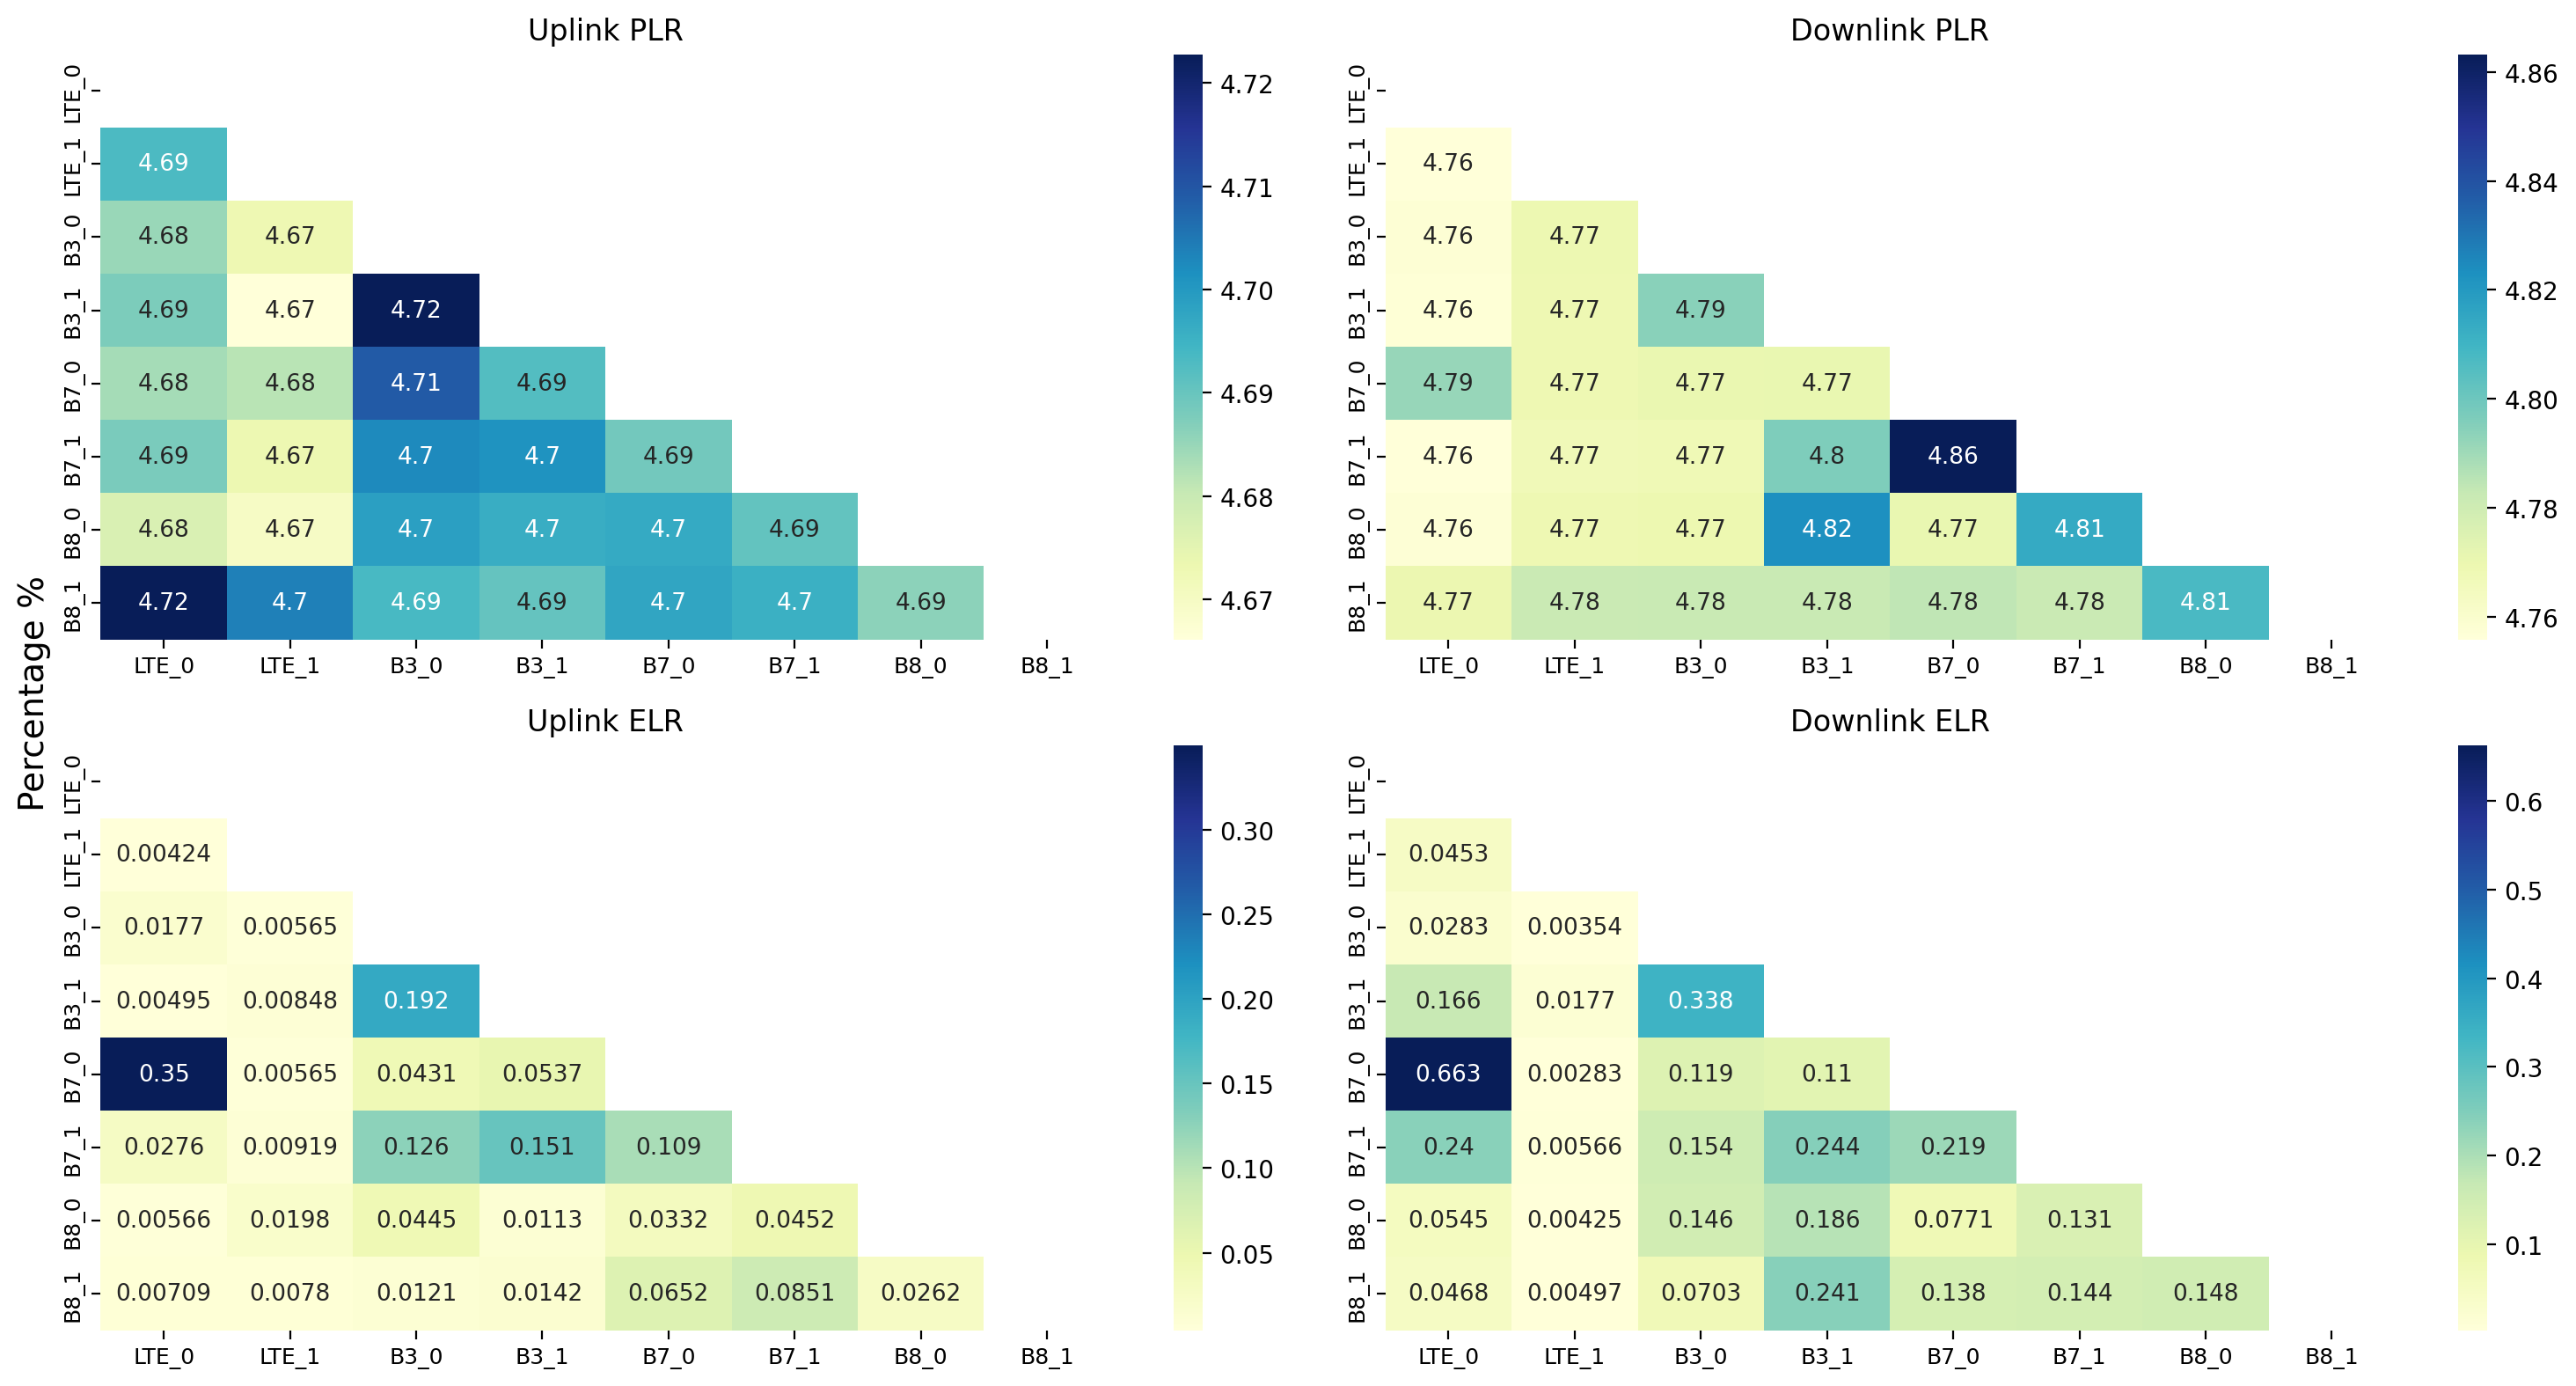

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #06


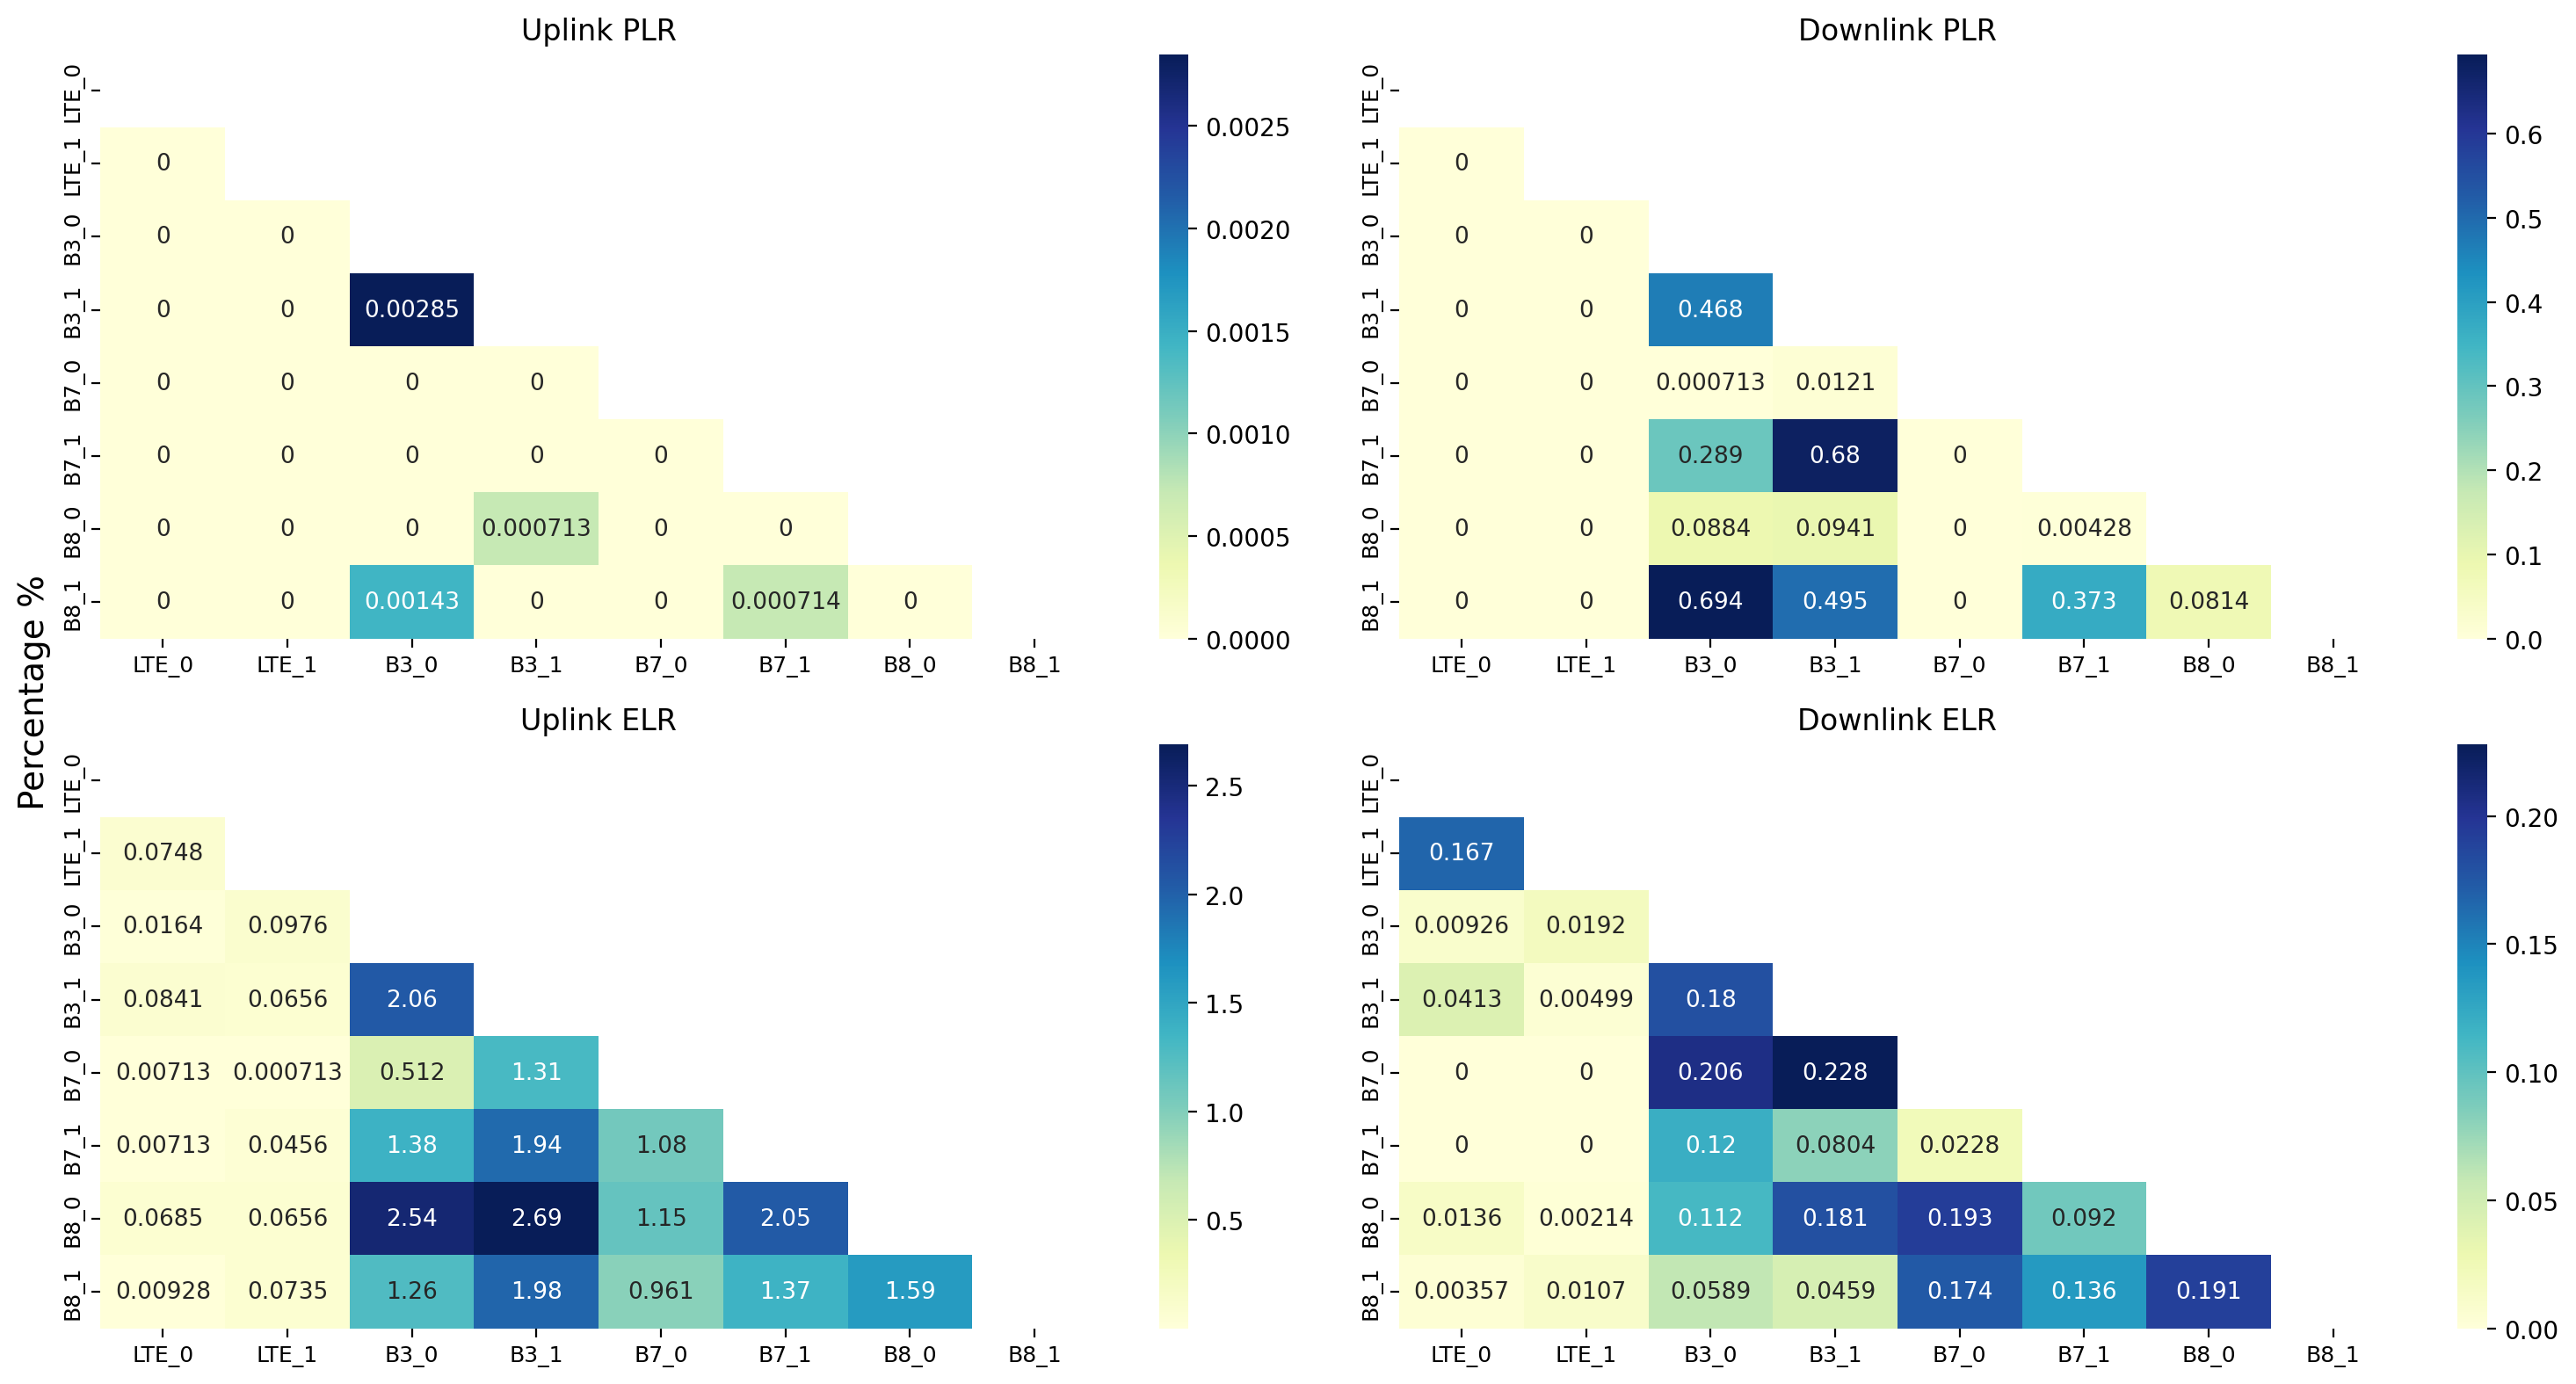

In [293]:
def mask(size, mode='lower', diag=True):
    
    mask = np.ones((size, size))
    if mode == 'lower': # 保留下三角(遮蔽上三角)
        mask[np.tril_indices(size)] = 0
    elif mode == 'upper': # 保留上三角(遮蔽下三角)
        mask[np.triu_indices(size)] = 0
    elif mode == 'square': # 全保留
        mask = np.zeros((size, size))
    else:
        print(f"Warning: mask() has no option '{mode}' for argument: 'mode'.")
        print("Please specify 'upper', 'lower', or 'square' instead.")
    
    if not diag: # 不保留對角線(遮蔽對角線)
        mask[np.diag_indices(size)] = 1

    return mask

for expr, metrics_dict in zip(exp_list, dual_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)
    display(expr.metadata_dual)
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR']
    
    ### 建立表格方便製圖
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    
    size = len(expr.setting)
    schemes = metrics_table[tag].columns[1:size+1]
    schm_list = metrics_table[tag].columns[size+1:]
    for i, tag in enumerate(['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']):
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        print(f'{title} Ranking:')
        
        ### Single Radio Ranking
        display(expr.ranking[tag])
        
        ### Dual Radio Ranking
        ranking_dict = {}
        data_dict = {k: v[tag] for k, v in metrics_dict.items()}
        score_dict = {k: [] for k in schm_list}
        for i, tr in enumerate(expr.traces):
            # print(i, tr)
            data = [v[i] for v in data_dict.values()][size:]
            data = [num if num >= 0 else np.inf for num in data]
            na_indices = [i for i, num in enumerate(data) if np.isinf(num)]
            
            sorted_indices = [i for i, x in sorted(enumerate(data), key=lambda x: x[1])]
            ranking = np.zeros(len(data))
            ranking[sorted_indices] = np.arange(1, len(data) + 1)
            ranking[na_indices] = np.nan
            # ranking = [num if not np.isnan(num) else '-' for num in ranking]
            ranking_dict[tr] = {k: v for k, v in zip(schm_list, ranking)}
            
            # _ranking = [num for num in ranking if num != '-']
            _ranking = [num for num in ranking if not np.isnan(num)]
            _max = max(_ranking); _min = min(_ranking)
            for k, rank in zip(schm_list, ranking):
                if rank == _min: score_dict[k].append(3)
                elif rank == _min + 1: score_dict[k].append(2)
                elif rank == _min + 2: score_dict[k].append(1)
                elif rank == _max - 1: score_dict[k].append(-1)
                elif rank == _max - 2: score_dict[k].append(-2)
                elif rank == _max: score_dict[k].append(-3)
                else: score_dict[k].append(0)
        
        score = [sum(v) for v in score_dict.values()]
        ranking_dict['Score'] = {k: v for k, v in zip(schm_list, score)}
        
        sorted_indices = [i for i, x in sorted(enumerate(score), key=lambda x: x[1], reverse=True)]
        score_ranking = np.zeros(len(score))
        score_ranking[sorted_indices] = np.arange(1, len(score) + 1)
        ranking_dict['Ranking'] = {k: round(v) for k, v in zip(schm_list, score_ranking)}
        
        ranking_table = pd.DataFrame.from_dict(ranking_dict, orient='index') #.reset_index().rename(columns={'index':'Tr.'})
        
        expr.ranking_dual[tag] = ranking_table
        display(ranking_table)
    
    ### Plotting: Per Round
    size = len(expr.setting)
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    combinations = ['+'.join(s) if s[0] != s[1] else s[0] for s in it.product(schemes, repeat=2)]
    for idx, tr in enumerate(expr.traces):
        print(f'{expr.date} | {expr.name} -> {tr}')
        
        # for ndiag in [False, True]:
        for ndiag in [True]:
            fig, axes = plt.subplots(2, 2, figsize=(15, 8))
            for pos, tag in enumerate(['ul_loss', 'ul_excl', 'dl_loss', 'dl_excl']):
                title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
                i = pos % 2; j = pos // 2
                
                data = [metrics_dict[comb][tag][idx] if comb in metrics_dict else -1 for comb in combinations]
                data = [num if num >= 0 else np.nan for num in data]
                reshaped_data = np.array(data).reshape(size, size)
                sns.heatmap(reshaped_data.T, ax=axes[i][j], annot=True, fmt='.3g', mask=mask(size, diag=not ndiag), annot_kws={"size": 9.5}, cmap="YlGnBu")
                axes[i][j].set_xticklabels(schemes, fontsize=9)
                axes[i][j].set_yticklabels(schemes, fontsize=9)
                axes[i][j].set_title(title)
                
                # 在相应位置上标注"N/A"
                _mask = mask(size, diag=not ndiag)
                rows, cols = reshaped_data.shape
                for k in range(rows):
                    for l in range(cols):
                        if np.isnan(reshaped_data.T[k][l]) and _mask[k][l] == 0:
                            axes[i][j].text(l + 0.5, k + 0.5, "N/A", ha='center', va='center', color='red', fontweight='bold')
            
            fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
            
            plt.tight_layout()
            plt.show()

# Trace Inspector

(1) 2個radio 的 packet loss 不同顏色疊在一起

(2) 兩者的 Latency （100ms 為閾值）

(3) 2個radio 的 handover 的發生時間，上為 radio 1，下為 radio 2，數字標間隔時間

(4) 兩者的 serving RSRP (PCI, band 變化，上為 radio 1) 最強的兩個 neighboring RSRP

(5) 兩者的 serving NR RSRP (PCI, band 變化，下為 radio 2) 最強的兩個 neighboring RSRP

(PCI1, EARFCN1, NRPCI1) -> (PCI2, EARFCN2, NRPCI2)

In [309]:
all_path = namedtuple('all_path', ['rrc_path', 'lte_path', 'nr_path', 'ul_path', 'dl_path'])

def find_selected_filepath(id, tr, dev):

    try:
        index = look_up_table[id]
        # print(f'Exp ({id}, {dev}, {tr}) look up succeed!')
    except:
        id_not_found = 1
        for i, expr in enumerate(exp_list):
            if "{:02d}".format(id) == expr.id:
                id_not_found = 0
                look_up_table[id] = i
                index = i
                break
        if id_not_found:
            print(f'Exp id: {id} not found!')
            return '','','','',''
            
    if isinstance(tr, str):
        # tr_name = tr
        tr_index = exp_list[index].traces.index(tr)
    else:
        # tr_name = exp_list[index].traces[tr]
        tr_index = tr
    
    rrc_path = exp_list[index].rrc_paths[dev][tr_index]
    lte_path = exp_list[index].lte_paths[dev][tr_index]
    nr_path = exp_list[index].nr_paths[dev][tr_index]
    ul_path = exp_list[index].ul_paths[dev][tr_index]
    dl_path = exp_list[index].dl_paths[dev][tr_index]
    
    return all_path(rrc_path, lte_path, nr_path, ul_path, dl_path)

## Dual Radio

In [310]:
for expr in exp_list:
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             5   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             3   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             4   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7       #01, #03, #04, #05, #06     1.278359             7   
6   sm06   B8       #01, #03, #04, #05, #06     1.185786             6   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             2   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             6     0.831878   
5     2.532447             8     2.604340             5     0.461063   
6     1.190465             3     1.640298             3     0.531022   
7     1.476035             4     2.474258             4     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             1  
6             3  
7             4

In [323]:
# TODO: Select Traces
expr_id = 22; expr_tr = '#01'
dev1 = 'sm05'
dev2 = 'sm06'

In [324]:
dfs = {'ho': [], 'lte': [], 'nr': [], 'ul': [], 'dl': []}
filepath1 = find_selected_filepath(expr_id, expr_tr, dev1)
filepath2 = find_selected_filepath(expr_id, expr_tr, dev2)

file_not_exist = False
for path1, path2, key in zip(filepath1, filepath2, dfs.keys()):
    print(key)
    print(dev1, expr_tr, path1)
    print(dev2, expr_tr, path2)
    if not (os.path.isfile(path1) and os.path.isfile(path2)):
        file_not_exist = True
        dfs[key].append(pd.DataFrame())
        dfs[key].append(pd.DataFrame())
    else:
        df1 = pd.read_pickle(path1) if path1.endswith('.pkl') else pd.read_csv(path1)
        df2 = pd.read_pickle(path2) if path2.endswith('.pkl') else pd.read_csv(path2)
        if key in ['ho']:
            df1, _, _ = mi_parse_ho(df1, tz=8)
            df2, _, _ = mi_parse_ho(df2, tz=8)
            df1['ho_type0'] = df1['ho_type'].astype('string')
            df2['ho_type0'] = df2['ho_type'].astype('string')
            df1.loc[df1['cause'].notna(), 'ho_type0'] = df1['ho_type'].astype('string') + '_' + df1['cause'].astype('string')
            df2.loc[df2['cause'].notna(), 'ho_type0'] = df2['ho_type'].astype('string') + '_' + df2['cause'].astype('string')
            df1['ho_type0'] = df1['ho_type0'].astype('category')
            df2['ho_type0'] = df2['ho_type0'].astype('category')
        elif key in ['lte', 'nr']:
            df1 = set_data(df1, mode=key, tz=8)
            df2 = set_data(df2, mode=key, tz=8)
        else:
            df1 = set_data(df1)
            df2 = set_data(df2)

        dfs[key].append(df1)
        dfs[key].append(df2)

if file_not_exist:
    print('\nFile not exist!!')
    
else:
    for key in ['ul', 'dl']:
        st_seq = max([dfs[key][0]['seq'].array[0], dfs[key][1]['seq'].array[0]])
        ed_seq = min([dfs[key][0]['seq'].array[-1], dfs[key][1]['seq'].array[-1]])
        dfs[key][0] = dfs[key][0][(dfs[key][0]['seq'] >= st_seq) & (dfs[key][0]['seq'] <= ed_seq)].reset_index(drop=True)
        dfs[key][1] = dfs[key][1][(dfs[key][1]['seq'] >= st_seq) & (dfs[key][1]['seq'] <= ed_seq)].reset_index(drop=True)

    st_time = min(dfs['ul'][0]['Timestamp'].array[0], dfs['ul'][1]['Timestamp'].array[0], dfs['dl'][0]['Timestamp'].array[0], dfs['dl'][1]['Timestamp'].array[0])
    ed_time = min(dfs['ul'][0]['Timestamp'].array[-1], dfs['ul'][1]['Timestamp'].array[-1], dfs['dl'][0]['Timestamp'].array[-1], dfs['dl'][1]['Timestamp'].array[-1])
    for key in ['ho', 'lte', 'nr']:
        dfs[key][0] = dfs[key][0][(dfs[key][0]['Timestamp'] > st_time) & (dfs[key][0]['Timestamp'] < ed_time)].reset_index(drop=True)
        dfs[key][1] = dfs[key][1][(dfs[key][1]['Timestamp'] > st_time) & (dfs[key][1]['Timestamp'] < ed_time)].reset_index(drop=True)

ho
sm05 #01 /Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm05/#01/data/diag_log_sm05_2023-06-15_16-00-51_rrc.pkl
sm06 #01 /Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm06/#01/data/diag_log_sm06_2023-06-15_16-00-51_rrc.pkl
lte
sm05 #01 /Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm05/#01/data/diag_log_sm05_2023-06-15_16-00-51_ml1.pkl
sm06 #01 /Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm06/#01/data/diag_log_sm06_2023-06-15_16-00-51_ml1.pkl
nr
sm05 #01 /Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm05/#01/data/diag_log_sm05_2023-06-15_16-00-51_nr_ml1.pkl
sm06 #01 /Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm06/#01/data/diag_log_sm06_2023-06-15_16-00-51_nr_ml1.pkl
ul
sm05 #01 /Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_

In [325]:
dfs['nr'][0]

Timestamp  \
0    2023-06-15 16:00:53.898954   
1    2023-06-15 16:00:54.058945   
2    2023-06-15 16:00:54.219432   
3    2023-06-15 16:00:54.379004   
4    2023-06-15 16:00:54.538993   
...                         ...   
1821 2023-06-15 16:05:48.077155   
1822 2023-06-15 16:05:48.237147   
1823 2023-06-15 16:05:48.397153   
1824 2023-06-15 16:05:48.557159   
1825 2023-06-15 16:05:48.717152   

                                                type_id  PCI       RSRP  \
0     5G_NR_ML1_Searcher_Measurement_Database_Update...  386 -79.234001   
1     5G_NR_ML1_Searcher_Measurement_Database_Update...  386 -79.570000   
2     5G_NR_ML1_Searcher_Measurement_Database_Update...  386 -80.085999   
3     5G_NR_ML1_Searcher_Measurement_Database_Update...  386 -80.484001   
4     5G_NR_ML1_Searcher_Measurement_Database_Update...  386 -79.601997   
...                                                 ...  ...        ...   
1821  5G_NR_ML1_Searcher_Measurement_Database_Update...  362 -90.148003   
1822  5G_NR_ML1_Searcher_Measurement_Database_Update...  362 -89.070000   
1823  5G_NR_ML1_Searcher_Measurement_Database_Update...  362 -87.758003   
1824  5G_NR_ML1_Searcher_Measurement_Database_Update...  362 -87.828003   
1825  5G_NR_ML1_Searcher_Measurement_Database_Update...  362 -90.383003   

        RSRQ serv_cel_index  EARFCN  NR_ARFCN  num_cels  num_neigh_cels  \
0    -14.930         PSCell    <NA>    631000         4               3   
1    -15.062         PSCell    <NA>    631000         4               3   
2    -15.367         PSCell    <NA>    631000         3               2   
3    -15.805         PSCell    <NA>    631000         3               2   
4    -15.086         PSCell    <NA>    631000         3               2   
...      ...            ...     ...       ...       ...             ...   
1821 -14.125         PSCell    <NA>    631000         5               4   
1822 -14.344         PSCell    <NA>    631000         5               4   
1823 -14.195         PSCell    <NA>    631000         5               4   
1824 -14.102         PSCell    <NA>    631000         5               4   
1825 -14.656         PSCell    <NA>    631000         5               4   

      serv_cel_pos  PCI0       RSRP0      RSRQ0  PCI1      RSRP1   RSRQ1  \
0                1   394  -79.500000 -14.625000   386 -79.234001 -14.930   
1                1   394  -79.078003 -13.750000   386 -79.570000 -15.062   
2                1   394  -78.140999 -13.391000   386 -80.085999 -15.367   
3                1   394  -77.655998 -13.383000   386 -80.484001 -15.805   
4                1   394  -82.960999 -14.188000   386 -79.601997 -15.086   
...            ...   ...         ...        ...   ...        ...     ...   
1821             1   378 -103.905998 -21.858999   362 -90.148003 -14.125   
1822             1   378  -98.405998 -21.391001   362 -89.070000 -14.344   
1823             1   378 -115.375000 -24.601999   362 -87.758003 -14.195   
1824             1   378 -101.430000 -23.351999   362 -87.828003 -14.102   
1825             1   378  -96.445000 -21.827999   362 -90.383003 -14.656   

      PCI2      RSRP2      RSRQ2  PCI3       RSRP3      RSRQ3  PCI4  \
0        3 -82.616997 -18.594000   178  -83.664001 -17.531000  <NA>   
1        3 -83.438004 -18.891001   178  -83.414001 -17.922001  <NA>   
2        3 -85.648003 -18.608999  <NA>         NaN        NaN  <NA>   
3        3 -83.195000 -18.483999  <NA>         NaN        NaN  <NA>   
4        3 -82.366997 -18.047001  <NA>         NaN        NaN  <NA>   
...    ...        ...        ...   ...         ...        ...   ...   
1821   286 -91.500000 -17.406000   350 -104.655998 -24.983999   370   
1822   286 -91.515999 -17.742001   350  -97.984001 -22.601999   370   
1823   286 -91.210999 -17.438000   350  -97.398003 -21.062000   370   
1824   286 -95.796997 -17.156000   350  -93.061996 -19.750000   370   
1825   286 -98.508003 -17.711000   350  -92.094002 -18.766001   370   

          RSRP4   RSRQ4  
0      

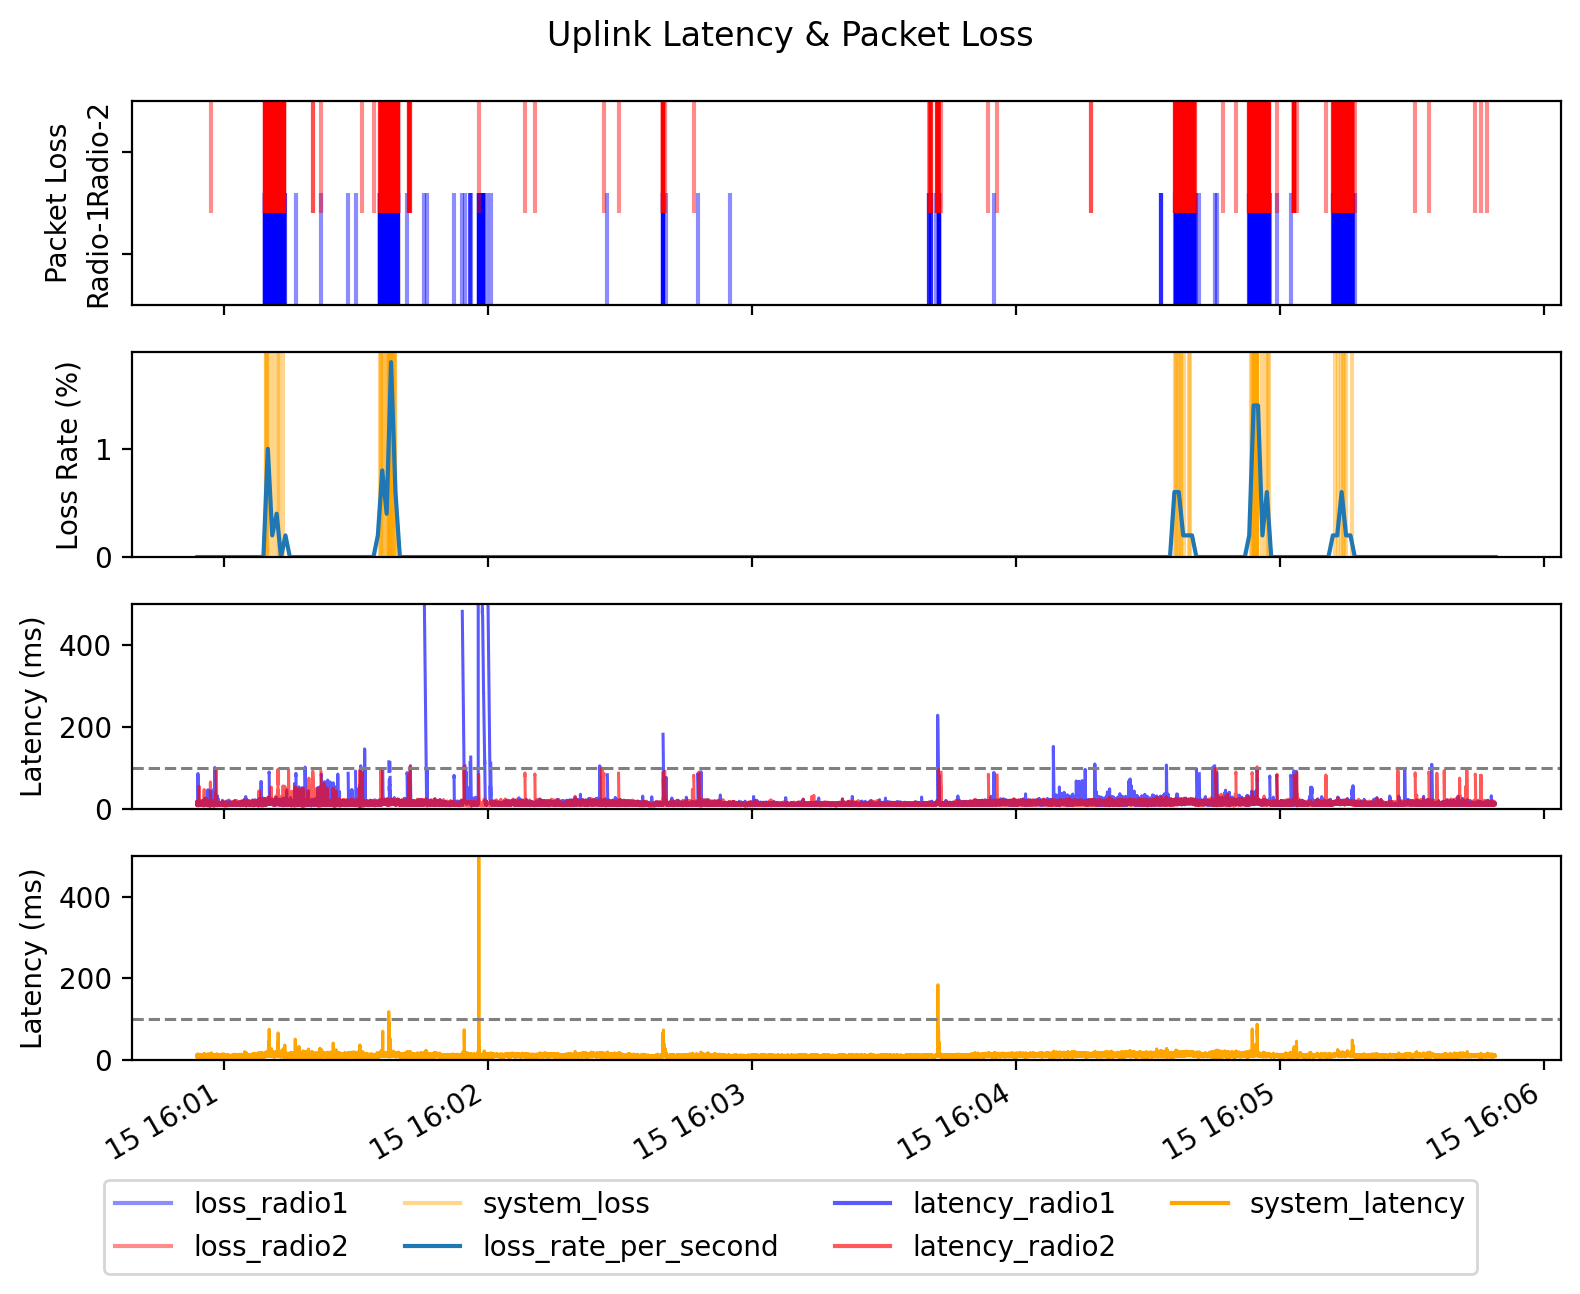

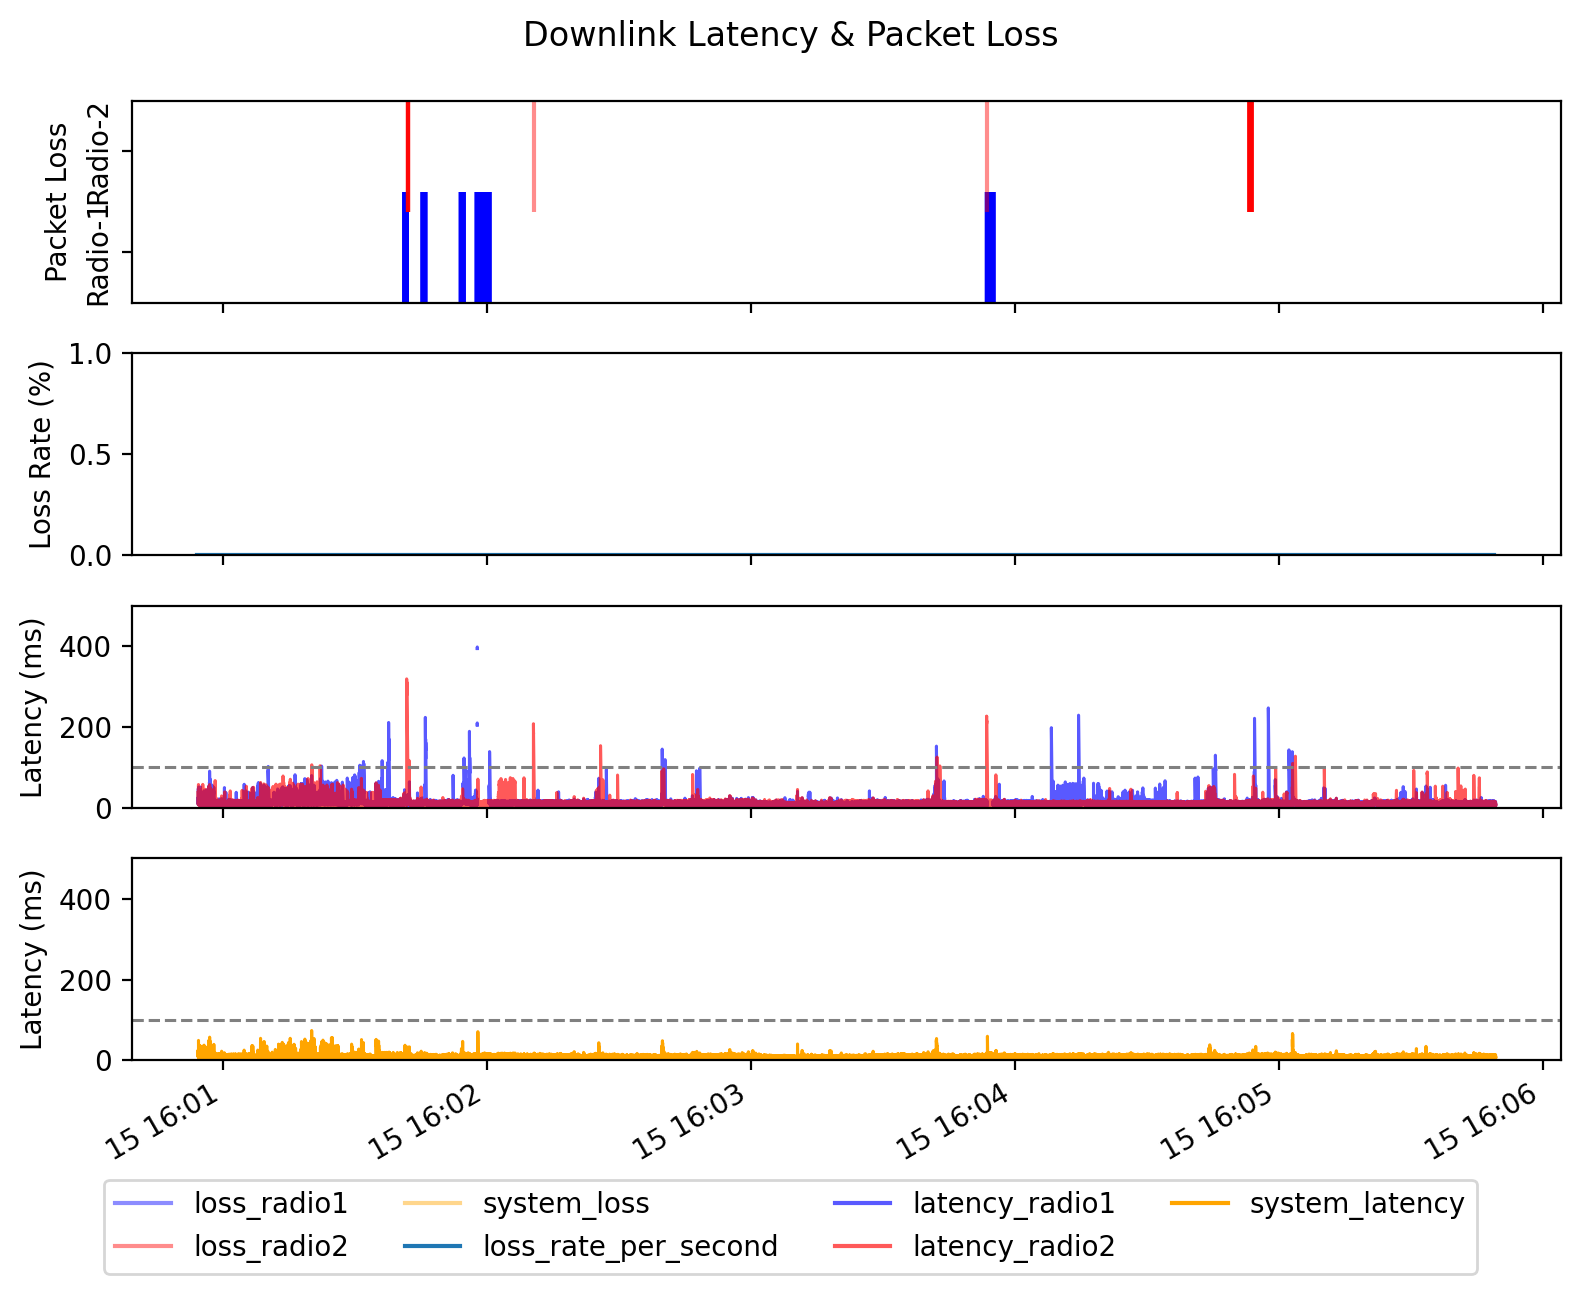

In [571]:
def plot_latency_loss(df1, df2, excl_threshold, title):
    fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
    legend_lines = []
    legend_labels = []

    def add_legend_lines(ax, label, color, alpha=1):
        line = ax.plot([], [], color=color, alpha=alpha)[0]
        legend_lines.append(line)
        legend_labels.append(label)

    ### Packet Loss
    loss1 = df1.loc[df1['lost'], "Timestamp"].iloc[:]
    loss2 = df2.loc[df2['lost'], "Timestamp"].iloc[:]
    loss = df1.loc[df1['lost'] & df2['lost'], "Timestamp"].iloc[:]

    axes[0].vlines(loss1, ymin=0, ymax=0.55, color='b', alpha=0.45)
    axes[0].vlines(loss2, ymin=0.45, ymax=1, color='r', alpha=0.45)
    axes[0].set_ylim(0, 1)
    axes[0].set_yticks([0.25, 0.75])
    axes[0].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')
    axes[0].set_ylabel('Packet Loss')

    df = df1.merge(df2, on='seq').rename(columns={'Timestamp_x': 'Timestamp'}).reset_index(drop=True).copy()
    df['lost'] = df['lost_x'] & df['lost_y']
    df = df[['Timestamp', 'lost']]
    df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.round('1s')

    lost_rate_per_second = (df.groupby('Timestamp')['lost'].mean() * 100).reset_index()
    timestamp = lost_rate_per_second['Timestamp'].iloc[:]
    lost_rate = lost_rate_per_second['lost'].iloc[:]

    axes[1].vlines(loss, ymin=0, ymax=100, color='orange', alpha=0.45)
    axes[1].plot(timestamp, lost_rate)
    axes[1].set_ylim(0, max(min(max(lost_rate) * 1.05, 100), 1))
    axes[1].set_ylabel('Loss Rate (%)')
    
    add_legend_lines(axes[0], 'loss_radio1', 'b', 0.45)
    add_legend_lines(axes[0], 'loss_radio2', 'r', 0.45)
    add_legend_lines(axes[1], 'system_loss', 'orange', 0.45)
    add_legend_lines(axes[1], 'loss_rate_per_second', 'tab:blue')

    ### Latency
    timestamp1 = df1["Timestamp"].iloc[:]
    latency1 = df1["latency"].iloc[:].astype(float) * 1e3
    timestamp2 = df2["Timestamp"].iloc[:]
    latency2 = df2["latency"].iloc[:].astype(float) * 1e3

    latency_min = np.minimum(latency1, latency2)

    axes[2].plot(timestamp1, latency1, linewidth=1.1, color='b', alpha=0.65)
    axes[2].plot(timestamp2, latency2, linewidth=1.1, color='r', alpha=0.65)
    axes[3].plot(timestamp1, latency_min, linewidth=1.1, color='orange')
        
    for ax in [axes[2], axes[3]]:
        ax.set_ylim(0, 500)
        ax.axhline(y=excl_threshold, color='gray', linestyle='--', linewidth=1.1)
    
    add_legend_lines(axes[2], 'latency_radio1', 'b', 0.65)
    add_legend_lines(axes[2], 'latency_radio2', 'r', 0.65)
    add_legend_lines(axes[3], 'system_latency', 'orange')

    axes[2].set_ylabel('Latency (ms)')
    axes[3].set_ylabel('Latency (ms)')
    # fig.text(0, (axes[2].get_position().y1 + axes[3].get_position().y0) / 2, \
    #     'milliseconds', ha='center', va='center', rotation='vertical', fontsize=10)

    fig.legend(legend_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.025), fancybox=True, ncol=4)
    fig.suptitle(title)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Call the function for uplink and downlink
plot_latency_loss(dfs['ul'][0].copy(), dfs['ul'][1].copy(), 100, 'Uplink Latency & Packet Loss')
plot_latency_loss(dfs['dl'][0].copy(), dfs['dl'][1].copy(), 100, 'Downlink Latency & Packet Loss')

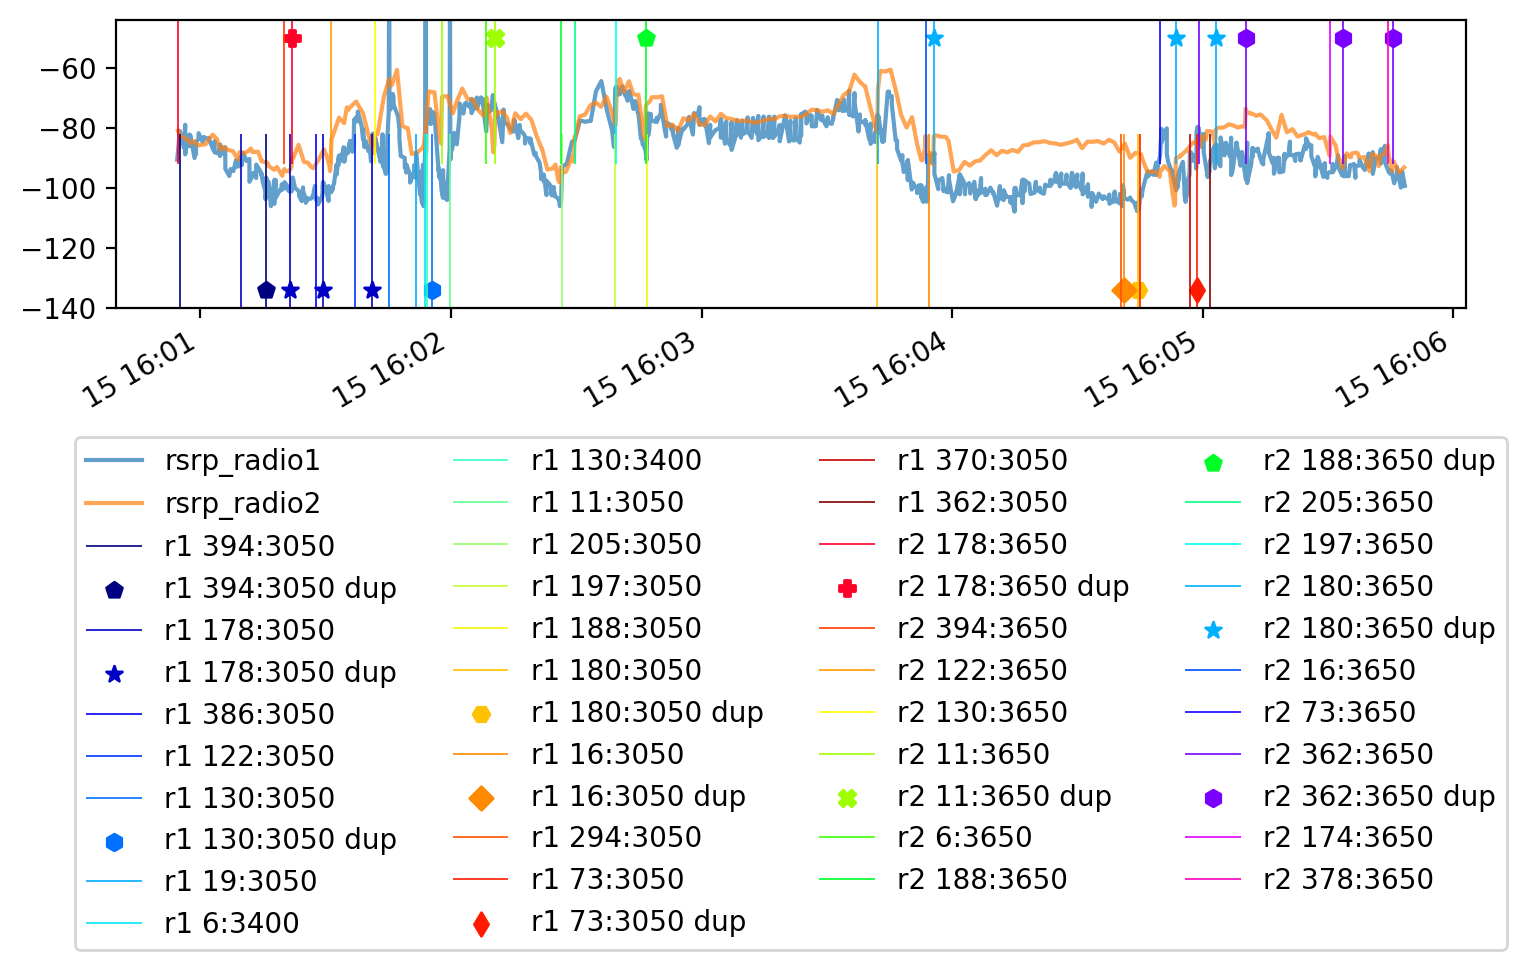

In [684]:
df1 = dfs['lte'][0].copy()
df2 = dfs['lte'][1].copy()

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df1['Timestamp'], df1['RSRP'], color='tab:blue', alpha=0.7, label='rsrp_radio1')
ax.plot(df2['Timestamp'], df2['RSRP'], color='tab:orange', alpha=0.7, label='rsrp_radio2')
ax.set_ylim(-140, -44)

def drop_unchanged(df):
    df = df[df['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
    
    df['prev_PCI'] = df['PCI'].shift(1)
    df['prev_EARFCN'] = df['EARFCN'].shift(1)
    df['handover'] = (df['PCI'] != df['prev_PCI']) | (df['EARFCN'] != df['prev_EARFCN'])
    df.loc[0, 'handover'] = True
    
    df = df[df['handover']].reset_index(drop=True).drop(['prev_PCI', 'prev_EARFCN'], axis=1)
    df['duplicate'] = df.duplicated(subset=['PCI', 'EARFCN'])
    
    pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['EARFCN'].array)]
    
    return df, pairs

def drop_duplicate(my_list):
    unique_list = []
    seen = set()
    
    for item in my_list:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)

    return unique_list

df1, pairs1 = drop_unchanged(df1)
df2, pairs2 = drop_unchanged(df2)

cmap = plt.get_cmap('jet', len(pairs1))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict1 = {pair: color for pair, color in zip(pairs1, colors)}

cmap = plt.get_cmap('gist_rainbow', len(pairs2))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict2 = {pair: color for pair, color in zip(pairs2, colors)}

markers = ['p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
mdict = {}
 
k = 0       
for pair in pairs1:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    tmp = df[(df['PCI'] == pair[0]) & (df['EARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        ax.vlines(tmp.Timestamp, ymin=-140, ymax=-82, color=cdict1[pair], linewidth=0.7, alpha=0.85, label=f'r1 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0])
    if not tmp.empty:
        ax.scatter(tmp.Timestamp, [-134]*len(tmp), c=cdict1[pair], marker=markers[k % len(markers)], label=f'r1 {pci_earfcn} dup')
        k += 1

for pair in pairs2:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    tmp = df[(df['PCI'] == pair[0]) & (df['EARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        ax.vlines(tmp.Timestamp, ymin=-92, ymax=-44, color=cdict2[pair], linewidth=0.7, alpha=0.85, label=f'r2 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0])
    if not tmp.empty:
        ax.scatter(tmp.Timestamp, [-50]*len(tmp), c=cdict2[pair], marker=markers[k % len(markers)], label=f'r2 {pci_earfcn} dup')
        k += 1

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=4)

# Show the plot
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()